In [1]:
!nvidia-smi

Fri Jan 31 10:57:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   34C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os, natsort, re
from tqdm import tqdm
import time, random

In [3]:
from itertools import repeat, chain

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("fivethirtyeight")
# 이미지가 레이아웃 안으로 들어오도록 함
mpl.rcParams.update({"figure.constrained_layout.use": True})
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [5]:
cd /content/drive/MyDrive/kdt-EST-AI/project/project2/

/content/drive/MyDrive/kdt-EST-AI/project/project2


In [6]:
# 로컬에서

#plt.rc("font", family = "D2Coding")
#plt.rcParams["axes.unicode_minus"] = False

In [7]:
#PRJCT_PATH = '/home/doeun/code/AI/ESTSOFT2024/workspace/2.project_text/aladin_usedbook/'
PRJCT_PATH = '/content/drive/MyDrive/kdt-EST-AI/project/project2/'
save_dir = 'processed/model_input'
dir_path = os.path.join(PRJCT_PATH,save_dir)
#dir_path = './'

In [8]:
import sys
sys.path.append(PRJCT_PATH)

In [9]:
RSLT_DIR = PRJCT_PATH + 'processed/'

bookinfo_name = 'bookinfo_ver{}.pkl'.format(0.75)
bookinfo_path = os.path.join(RSLT_DIR,bookinfo_name)

sys.path.append(PRJCT_PATH)
from module_aladin.file_io import load_pkl, save_pkl
from module_aladin.reg_tool import make_reg_score_dict

from module_aladin.util import read_run_rslt
from module_aladin.plot import plot_area

In [10]:
input_dir = os.path.join(RSLT_DIR,'model_input')
files = list(filter(lambda x : 'scaled-scalar' in x,os.listdir(input_dir)))
files

['scaled-scalar.v1.0_st-0_X_vld.pkl',
 'scaled-scalar.v1.0_st-0_X_trn.pkl',
 'scaled-scalar.v1.0_st-0_y_vld.pkl',
 'scaled-scalar.v1.0_st-0_y_trn.pkl',
 'scaled-scalar.v1.0_st-0_y_tst.pkl',
 'scaled-scalar.v1.0_st-0_X_tst.pkl']

In [11]:
from collections import defaultdict

data_dict=defaultdict(dict)
for f in files:
    data_dict[f[-7:-4]][f[-9]] = load_pkl(os.path.join(input_dir,f))

In [12]:
data_dict.keys()

dict_keys(['vld', 'trn', 'tst'])

In [13]:
cols_tknz = ['Category','BName','BName_sub']
cols_scalar = ['Author','Author_mul','Publshr','Pdate', 'SalesPoint']
maxlens={
    'Category' : 5,
    'BName' : 30,
    'BName_sub' : 25
}
col_idx = [0,5,35,60,61,62,63,64,65]
col_start = [0,5,35,60,65]

In [14]:

import torch

# GPU device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.set_default_device(device)

In [15]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["TORCH_USE_CUDA_DSA"] = '1'

In [16]:
device

device(type='cuda', index=0)

# train & evaluation module

In [17]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install torcheval
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlin

In [18]:
from module_aladin.torch_train import trainer_setting, train, evaluate, run, test_n_plot, test_plot_err_dist, get_test_rslt, test_plot_reg_val

cuda:0


# Make model & setting

## Attention based model

In [19]:
import math
import time

from torch import nn, optim
from torch.optim import Adam


In [20]:
from module_aladin.attention_based_model import EncoderWithEmbedding

cuda:0


In [21]:
#col_start = np.array([0,5,35,60,64])
col_start = np.array([0,60,64])
col_len = col_start[1:]- col_start[:-1]
col_len

array([60,  4])

In [22]:
class Model4_5(nn.Module):
  def __init__(self,col_start,d_model,head,d_ff,dropout,n_layers,device):
    super().__init__()
    self.device=device
    self.d_model = d_model #300 # should be common multiplyer of col_len[:-1]
    self.col_start=col_start
    col_len = col_start[1:]- col_start[:-1]
    self.embd_encoder = nn.ModuleList([EncoderWithEmbedding(seq_len,d_model,head,d_ff,seq_len,dropout,n_layers,device)
                          for seq_len in col_len[:-1]])
    d_out= d_model*np.sum(col_len[:-1])+col_len[-1]
    self.fc1 = nn.Linear(d_out,d_out//2)
    self.fc2 = nn.Linear(d_out//2,d_out//2)
    self.fc3 = nn.Linear(d_out//2,1)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(dropout)

  def cut_vec(self,src,col_start):
    return [src[:,i:j] for i,j in zip(col_start[:-1],col_start[1:])]

  def forward(self,src): #차원 체크해봐야 함
    vecs = self.cut_vec(src,self.col_start)
    intrmd, masks = [], []
    batch_size,_ = src.size()

    for vec,encoder in zip(vecs[:-1],self.embd_encoder):
      out = encoder(vec.to(torch.int32))
      intrmd.append(out.view(batch_size,-1))

    intrmd.append(vecs[-1])
    output = torch.cat(intrmd,dim=1)

    output = self.dropout(self.relu(self.fc1(output)))
    output = self.dropout(self.relu(self.fc2(output)))
    output = self.fc3(output)

    return output


In [23]:
from math import sqrt

print((len(data_dict['trn']['X'])/8192* 60 *sqrt(6) * 450)**(-0.5) /8.228676261460045e-05 )
print(1/((len(data_dict['trn']['X'])/8192* 60 *sqrt(6) * 450)**(-0.5) /8.228676261460045e-05 ))
print((len(data_dict['trn']['X'])/8192* 60 *6 * 450)**(-0.5) /8.228676261460045e-05 )
print(1/((len(data_dict['trn']['X'])/8192* 60 *6 * 450)**(-0.5) /8.228676261460045e-05 ))

13.446615507153101
0.07436815602171692
8.591622253746467
0.11639245423807355


init_lr = a * (len(data) / (b_size) * k_dim * N * best_epoch) ^(-0.5)

init_lr^(-2) = a * (len(data)/b_size * k_dim * N ) * best_epoch

In [24]:
(len(data_dict['trn']['X'])/(8192*2.5)* 60 *sqrt(6) * 450)**(-0.5)/(13.45)

0.000130074056128077

In [25]:
# model parameter setting
batch_size = 20480

# optimizer parameter setting
factor = 0.92
adam_eps = 5e-7
patience = 10
warmup = 3
epoch = 550
clip = 1.0
weight_decay = 5e-20
drop_prob = 0.1

## make dataloader

In [26]:
from module_aladin.load_data import load_dataloader_iters
from module_aladin.plot import plot_area

cuda:0


In [27]:
iter_dict = load_dataloader_iters(data_dict,batch_size)

In [28]:
class answer_out(nn.Module):
  def __init__(self,iter):
    super().__init__()
    self.input, self.output = zip(*iter)
  def forward(self,src):
    for i,x in enumerate(self.input):
      if x.shape != src.shape: continue
      cond = x.reshape(-1) == src.reshape(-1)
      if torch.sum(cond) == len(cond) : return self.output[i]
    else : return False

answer_trn = answer_out(iter_dict['trn'])
answer_vld = answer_out(iter_dict['vld'])
answer_tst = answer_out(iter_dict['tst'])

In [29]:
d_model = 60 #64
head = 6
d_ff = 128
n_layers= 6

In [30]:
def expt_config(title='test',coeff=1,init='auto',date='250101'):
  if init == 'auto' : init_lr=(len(data_dict['trn']['X'])/8192* 60 *sqrt(6) * 450)**(-0.5)/(13.45)
  else : init_lr = init
  init_lr *= coeff
  model = Model4_5(col_start,d_model,head,d_ff,drop_prob,n_layers,device)
  model, optimizer, scheduler, criterion =trainer_setting(model,init_lr,weight_decay,adam_eps,factor,patience)

  model_name = 'model4.5'
  expt_name = f'{model_name}_{batch_size}_{title}_lr{str(init)}_{coeff}'
  save_dir = os.path.join(RSLT_DIR,'model_test',expt_name)
  if not os.path.exists(save_dir) : os.makedirs(save_dir)
  file_name = 'model_{}_{}.pt'.format(title,date)
  train_config =[optimizer, scheduler, criterion, clip]
  return model, train_config, init_lr,save_dir,file_name

# GET TEST RSLT

- load best model
- inference and save output
- clean cache



In [31]:
ls {os.path.join(RSLT_DIR,'model_test','model4.5_20480_2.0_11_lr0.000176_1')}

best_model_2.0_11_250111.pt  rslt_best_model_2.0_11_250111..pkl  valid_loss.pkl
model_2.0_11_250111.pt       train_loss.pkl                      valid_score.pkl


In [32]:
from module_aladin.torch_train import get_test_rslt

In [35]:
from tqdm.auto import tqdm

def expt_test_rslt(base_dir,expt_name,data='tst'):
  dirs = filter(lambda x : expt_name in x,os.listdir(base_dir))
  for dir in tqdm(list(dirs)):
    dir_path = os.path.join(base_dir,dir)
    model_subs= list(filter(lambda x : ('best_' in x) & (x[-3:] == '.pt'), os.listdir(dir_path)))
    if len(model_subs) == 1 : model_file = model_subs[0]
    else : continue

    best_model = torch.load(os.path.join(dir_path,model_file), map_location=device)
    criterion = nn.MSELoss()
    temp = get_test_rslt(best_model,iter_dict[data],criterion,device)
    save_pkl(os.path.join(base_dir,dir),f'rslt-{data}_{model_file[:-2]}.pkl',temp)


In [37]:
#expt_test_rslt(os.path.join(RSLT_DIR,'model_test'),'20480_2.')
#expt_test_rslt(os.path.join(RSLT_DIR,'model_test'),'20480_2.','vld')
expt_test_rslt(os.path.join(RSLT_DIR,'model_test'),'20480_2.','trn')

  0%|          | 0/209 [00:00<?, ?it/s]

<ipython-input-35-77e44cfdd2ae>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(os.path.join(dir_path,model_file), map_location=device)


In [ ]:
def lr_conv_test(init,num,title,date,coeff=1,idx=0):
  for i in range(idx,idx+num):
    model, train_config, init_lr,save_dir,file_name = expt_config(title=f'{title}_{i}',coeff=coeff,init=init,date=date)
    model,train_loss,val_loss,train_score,val_score,best_epoch = run(model,train_config,iter_dict['trn'],iter_dict['vld'],epoch,warmup,10100,save_dir,file_name[:-3])
    torch.save(model,os.path.join(save_dir,file_name))
    save_pkl(save_dir,'train_loss.pkl',train_loss)
    save_pkl(save_dir,'valid_loss.pkl',val_loss)
    save_pkl(save_dir,'valid_score.pkl',val_score)
    coeff *= (best_epoch/450)

### check rslt

In [ ]:
import natsort
from functools import reduce

def check_best_epoch(base_dir,exptname,feat='valid_score',high=True,set_print=False):
  dirs = list(filter(lambda x: exptname in x,os.listdir(base_dir)))
  dirs = natsort.natsorted(dirs)
  files = list(map(lambda x : os.path.join(base_dir,x,f'{feat}.pkl'),dirs))
  scores=dict()
  for dir, file in zip(dirs,files):
      try : scores[dir] = load_pkl(file)
      except : continue
  rslt = {
      dir : [np.argmax(score)+1 if high else np.argmin(score)+1,
             np.max(score) if high else np.min(score)]
      for dir,score in scores.items()
  }
  if set_print :
    for dir in dirs :
      print(dir,'\t',rslt[dir])
  return rslt

def get_total_coeff(rslt,unit=450):
  vals = list(map(lambda x : x/unit,rslt))
  return reduce(lambda x,y:x*y,vals,1)

In [ ]:
def get_expt_rslt_epoch(base_dir,expt_name,print=False):
  feat = {
      'valid_score' : True,
      'valid_loss' : False
  }
  rslt_dict = {
      key : check_best_epoch(base_dir,expt_name,key,val,print)
      for key,val in feat.items() }
  return rslt_dict

In [ ]:
def get_expt2_rslt_whole(base_dir,expt_name,unit=450):
  rslt_dict = get_expt_rslt_epoch(base_dir,expt_name)
  rslt= dict()
  for key,best in rslt_dict.items():
    epoch, score = dict(), dict()
    dirs = list(best.keys())
    first = dirs[0]
    for (i,dir) in list(enumerate(dirs)):
      epoch[dir] = best[dir][0]
      score[dir] = best[dir][1]

    rslt[key] = {
       'epoch' : epoch,
       'score' : score
    }

  return rslt

In [ ]:
expt20_rslt = get_expt2_rslt_whole(os.path.join(RSLT_DIR,'model_test'),'20480_2.0')
expt21_rslt = get_expt2_rslt_whole(os.path.join(RSLT_DIR,'model_test'),'20480_2.1')
expt22_rslt = get_expt2_rslt_whole(os.path.join(RSLT_DIR,'model_test'),'20480_2.2')
expt23_rslt = get_expt2_rslt_whole(os.path.join(RSLT_DIR,'model_test'),'20480_2.3')
expt24_rslt = get_expt2_rslt_whole(os.path.join(RSLT_DIR,'model_test'),'20480_2.4')
expt25_rslt = get_expt2_rslt_whole(os.path.join(RSLT_DIR,'model_test'),'20480_2.5')
expt26_rslt = get_expt2_rslt_whole(os.path.join(RSLT_DIR,'model_test'),'20480_2.6')

In [ ]:
from decimal import Decimal

def plot_expt_dist_rslt(expt_rslt,y_down=[]):
  fig,axes = plt.subplots(2,3,figsize=(16,8))
  axes_flat = axes.flatten()
  data = expt_rslt['valid_loss']
  sns.histplot(data=data,x='epoch',ax=axes_flat[0],bins=(len(data['epoch'])//3)+1)
  axes_flat[0].set_xlabel('best_epoch_loss')

  sns.scatterplot(data = data,x='epoch',y='score',ax=axes_flat[1])
  for i,dir in enumerate(data['epoch'].keys()):
    x,y = data['epoch'][dir],data['score'][dir]
    axes_flat[1].annotate(f'{i}',xy = (x,y),xytext = (x,y+10), fontsize = 10, ha='center')
  axes_flat[1].set_ylabel('best_loss')

  sns.histplot(data=data,x='score',ax=axes_flat[2],binwidth=25)
  axes_flat[2].set_xlabel('best_loss')

  data2 = expt_rslt['valid_score']
  sns.histplot(data=data2,x='epoch',ax=axes_flat[3],bins=(len(data['epoch'])//3)+1)#,binwidth=7.5)
  axes_flat[3].set_xlabel('best_epoch_score')

  sns.scatterplot(data = data2,x='epoch',y='score',ax=axes_flat[4])
  for i,dir in enumerate(data2['epoch'].keys()):
    x,y = data2['epoch'][dir],data2['score'][dir]
    axes_flat[4].annotate(f'{i}',xy = (x,y),xytext = (x,y+0.0011), fontsize = 10, ha='center')
  axes_flat[4].set_ylabel('best_score')

  sns.histplot(data=data2,x='score',ax=axes_flat[5],binwidth=0.0025)
  axes_flat[5].set_xlabel('best_score')

#  data2 = {
#      'valid_loss' : expt_rslt['valid_loss']['score'],
#      'valid_score' : expt_rslt['valid_score']['score']
#  }
#  sns.scatterplot(data = data2,x='valid_loss',y='valid_score',ax=axes_flat[2])
#  for i,dir in enumerate(data2['valid_loss'].keys()):
#    x,y = data2['valid_loss'][dir],data2['valid_score'][dir]
#    axes_flat[2].annotate(f'{i}',xy = (x,y),xytext = (x,y+0.0011), fontsize = 10, ha='center')



#### 확인하고 싶은 것
- init_lr vs best_epoch, loss, score
- 봉우리가 두 개인 경우 train, valid loss 그래프가 첫번째 봉우리에 있을 때와 두번째 봉우리에 있을 때가 다른지
- 어쨌든 전반적으로 train 및 valid loss 그래프를 봤을 때 best epoch이 어느 시점 즈음에 있는지 궁금 (안정기? or 과적합 시기? or 아직 학습 덜 되었다거나?)
  - 만약 한참 전에 best epoch 나왔어야 했는데 550 즈음에서 갱신된 경우
- loss 기준 best epoch에서 score값으로도 비교
- best model의 test score도 비교 - predict 결과값 pkl로 저장
- 현재 init_lr과 loss 및 score가 음의 상관관계를 갖는 것 같아 보이는데 이게 맞는지 (단 진짜 best epoch이 아직 안 나온 경우는 배제)
- init_lr가 best epoch 사이에 내가 추측했던 식이 얼추 맞는지 비교 -> 식 다시 정리하여 두 식이 선형 상관관계를 갖는지 보이는 식으로 진행


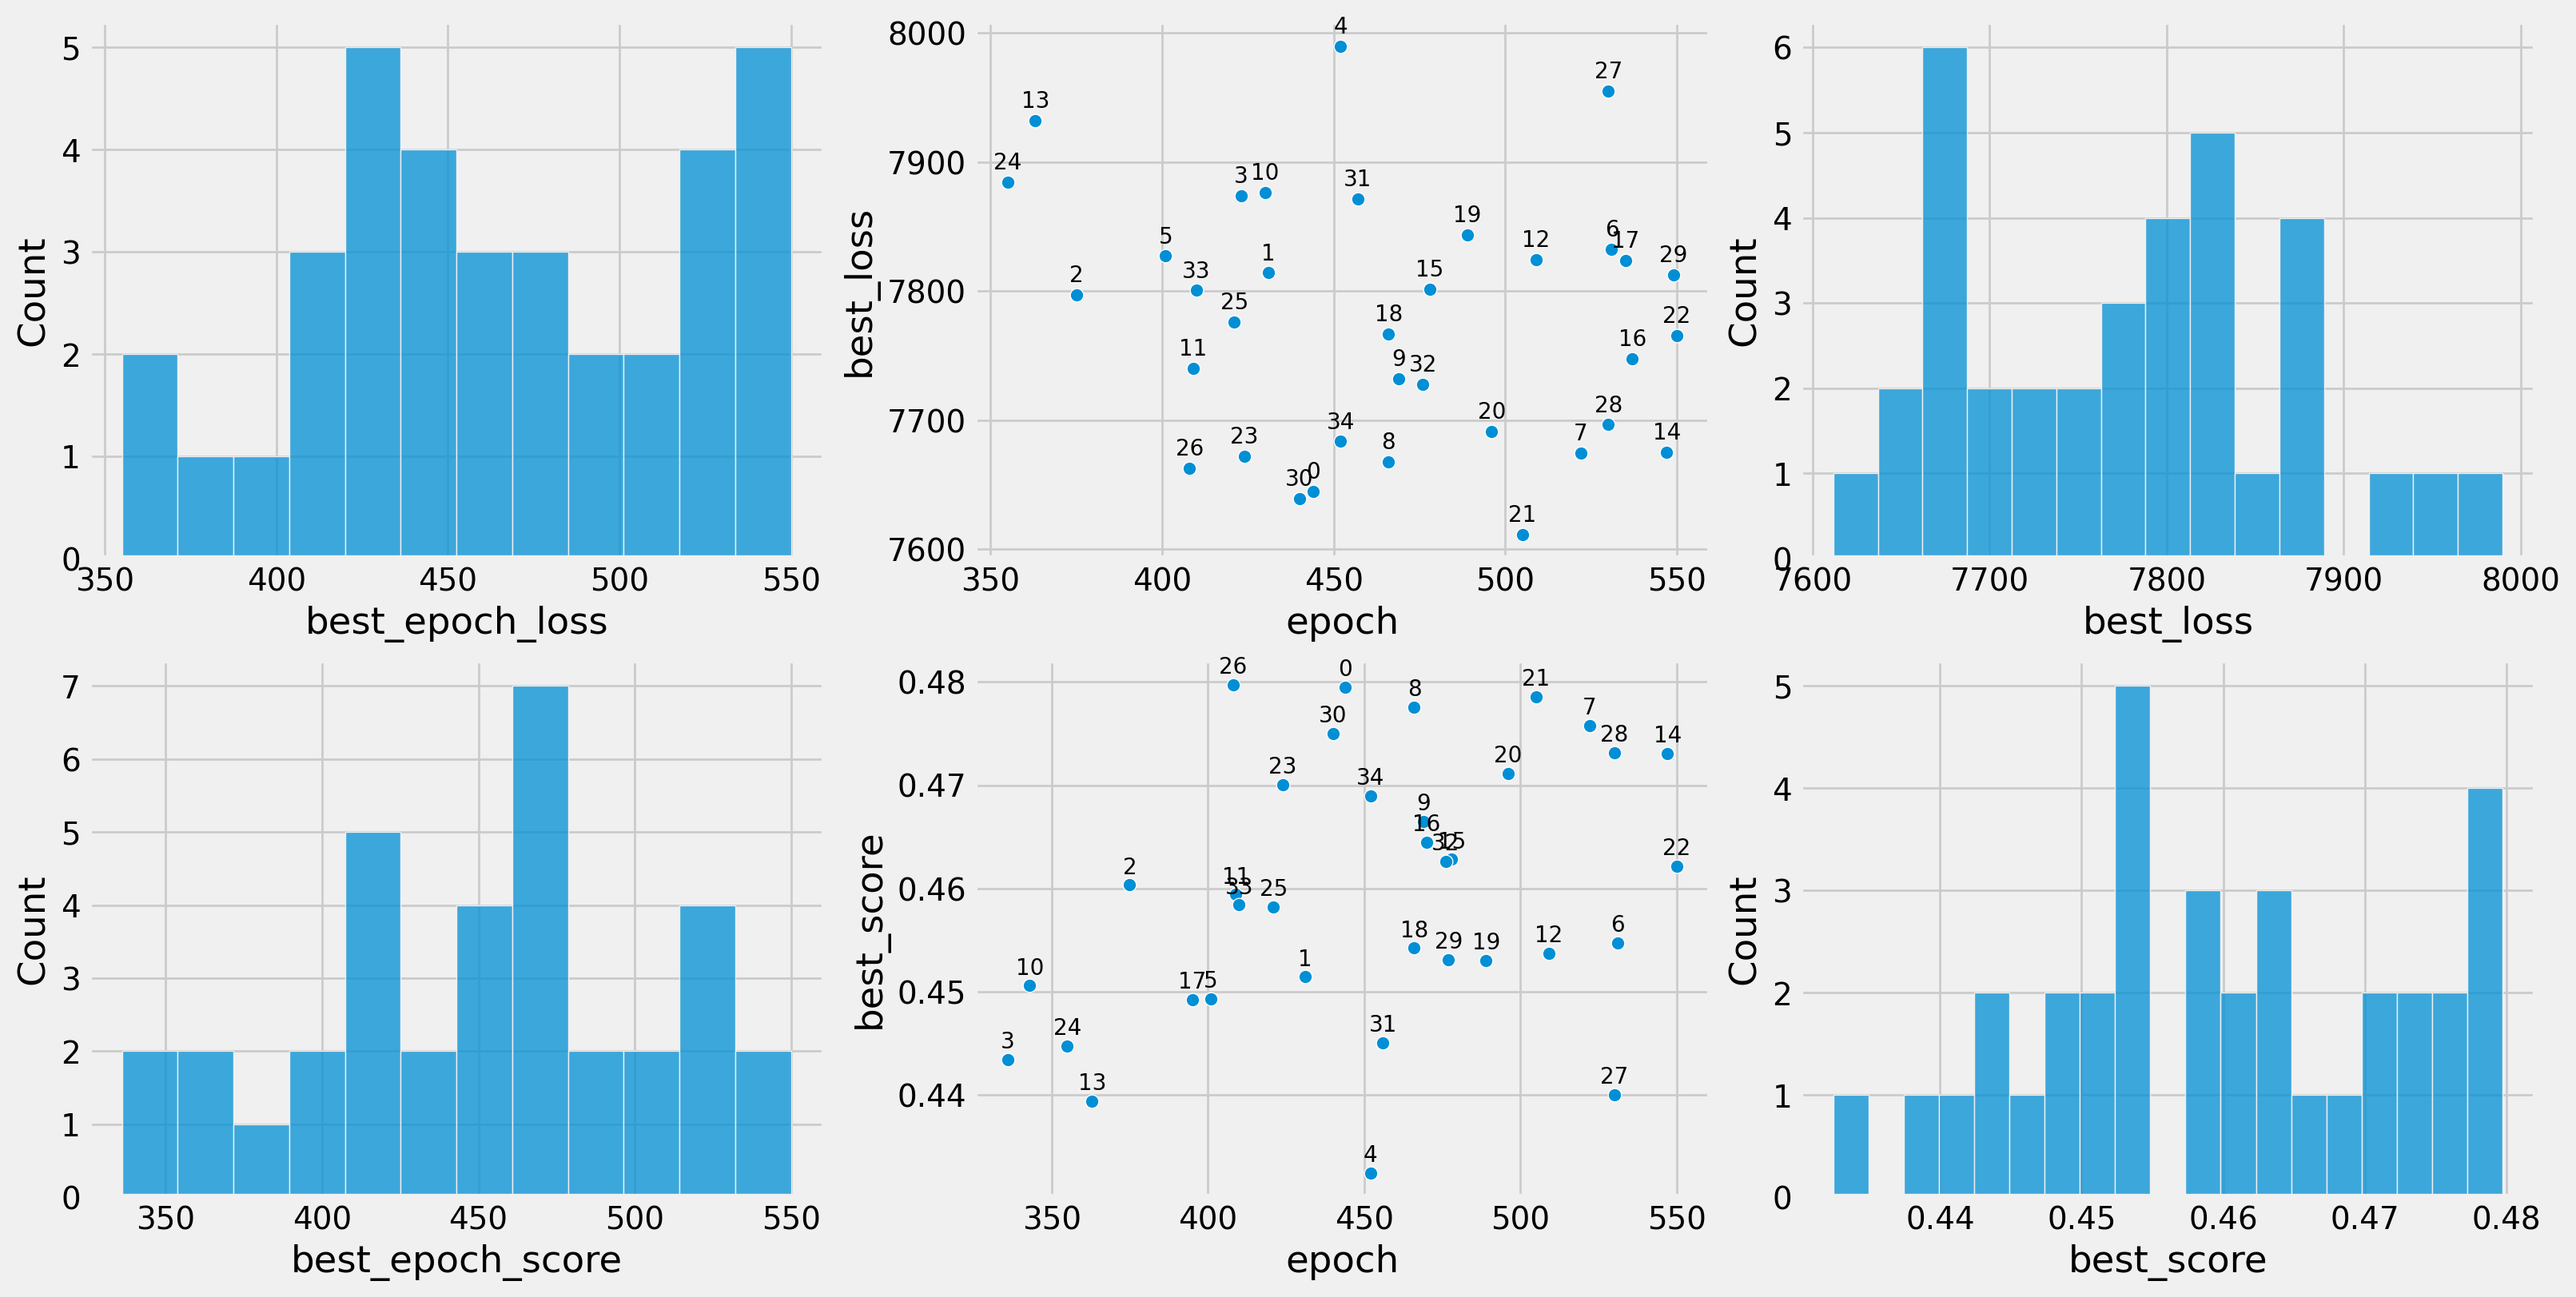

In [ ]:
plot_expt_dist_rslt(expt20_rslt)

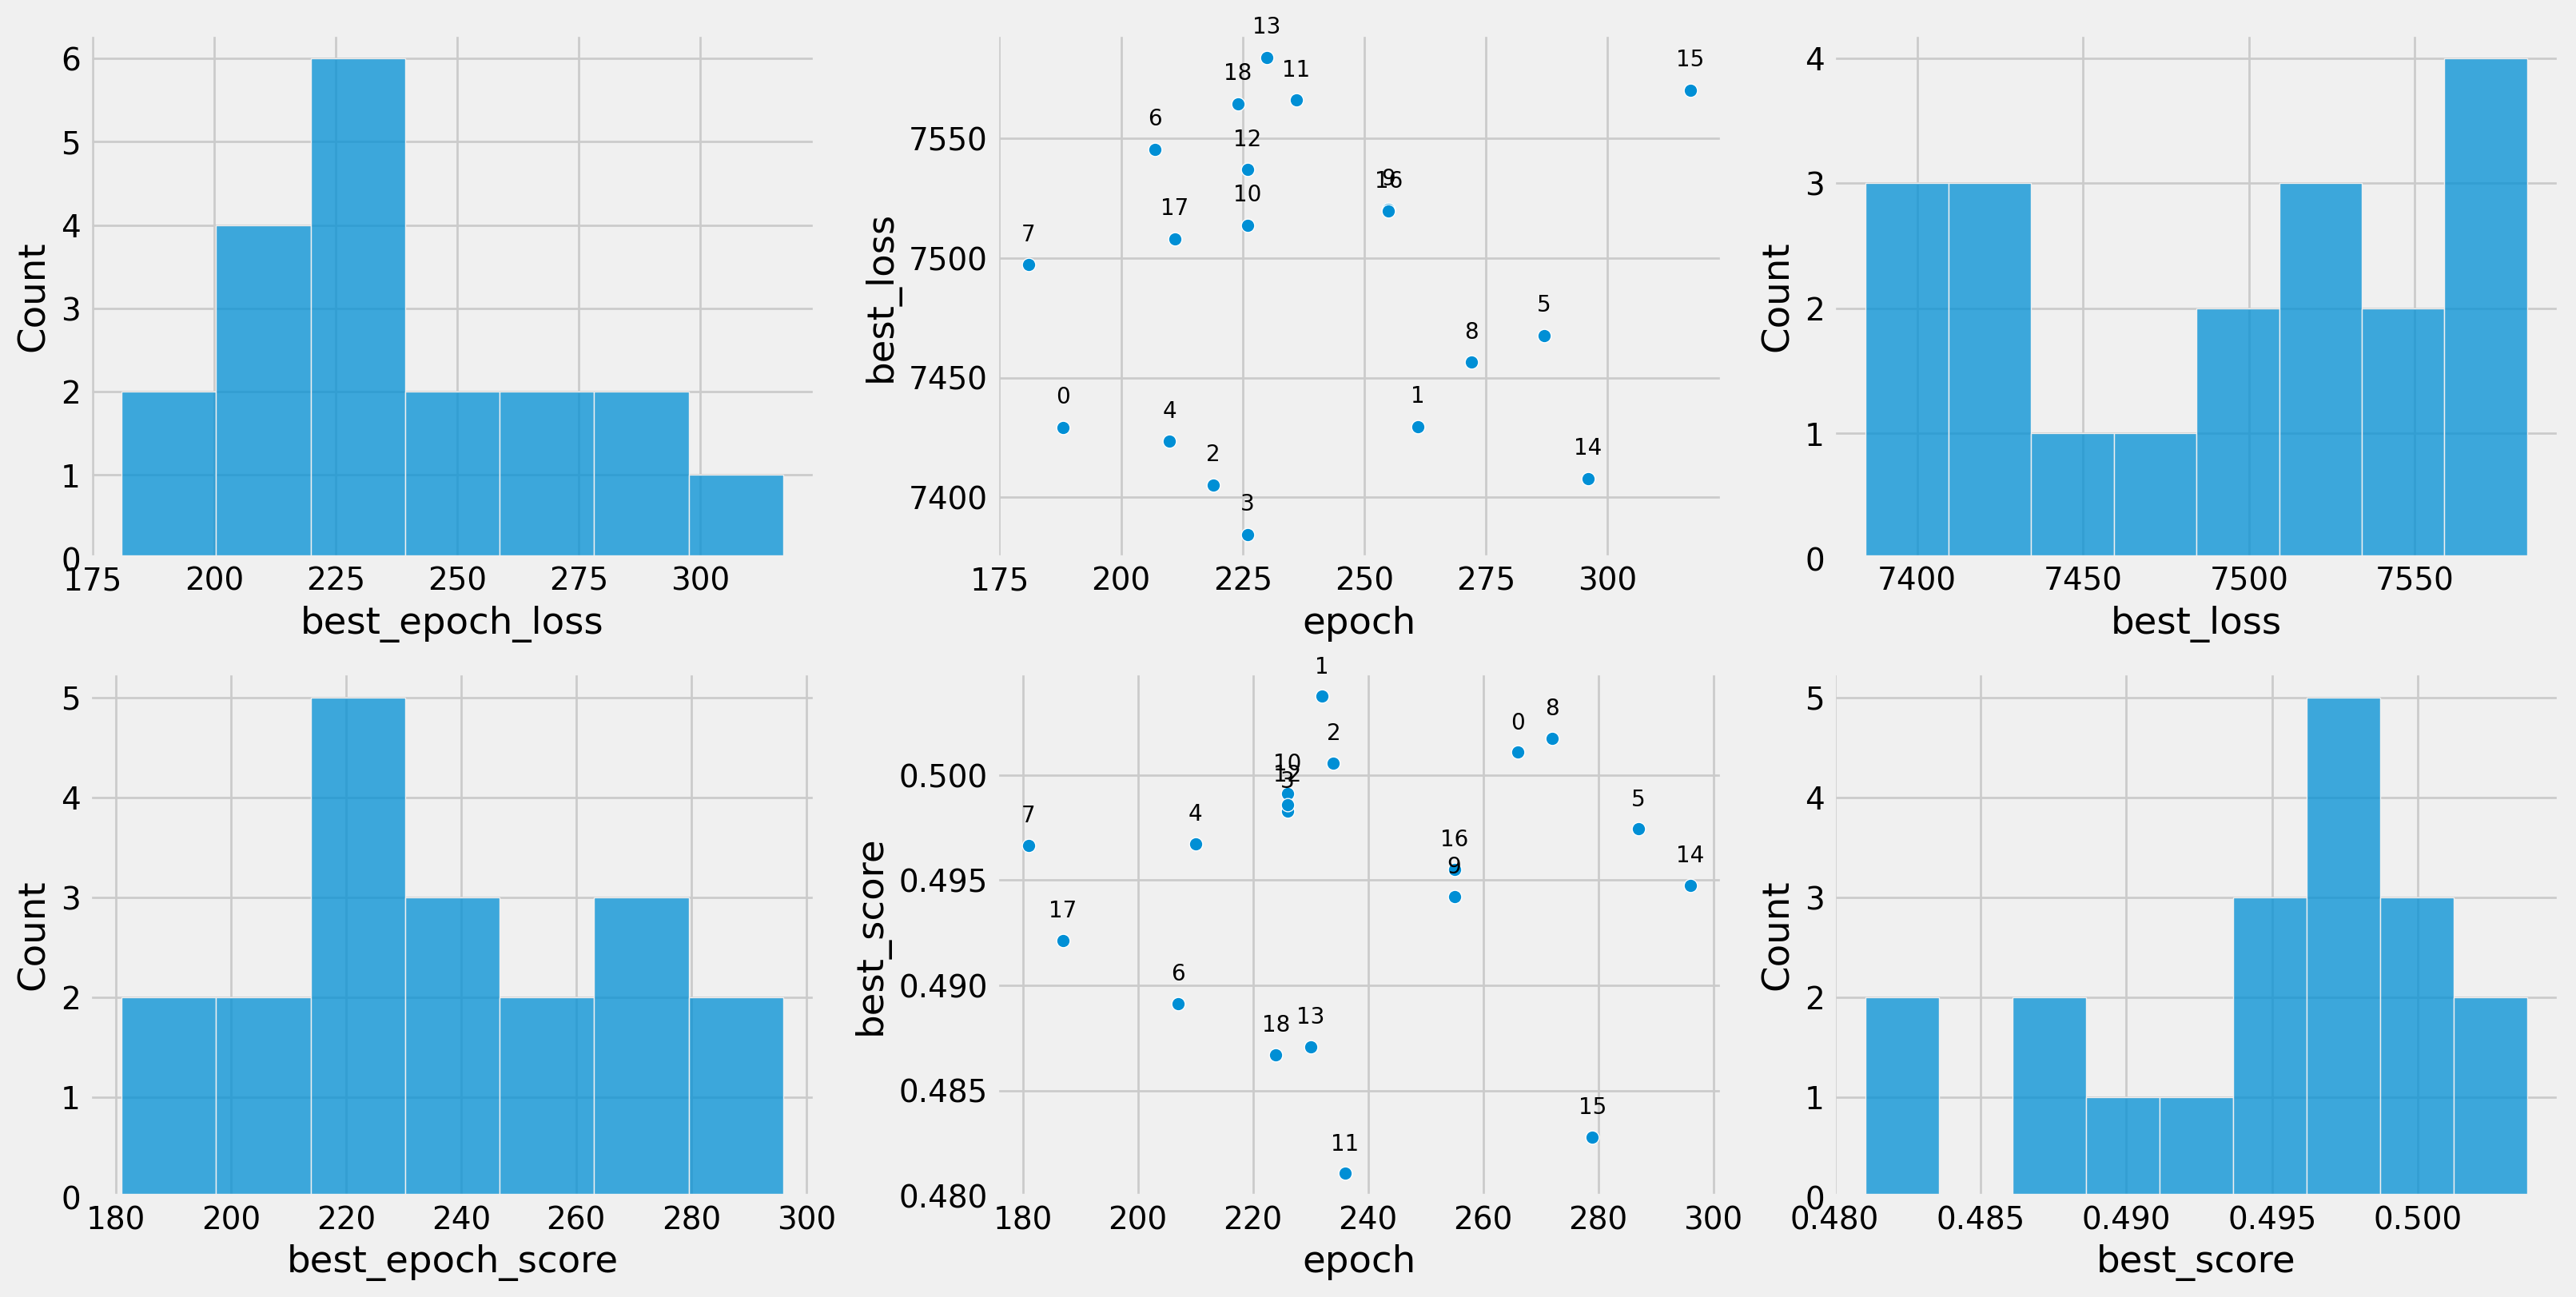

In [ ]:
plot_expt_dist_rslt(expt21_rslt)

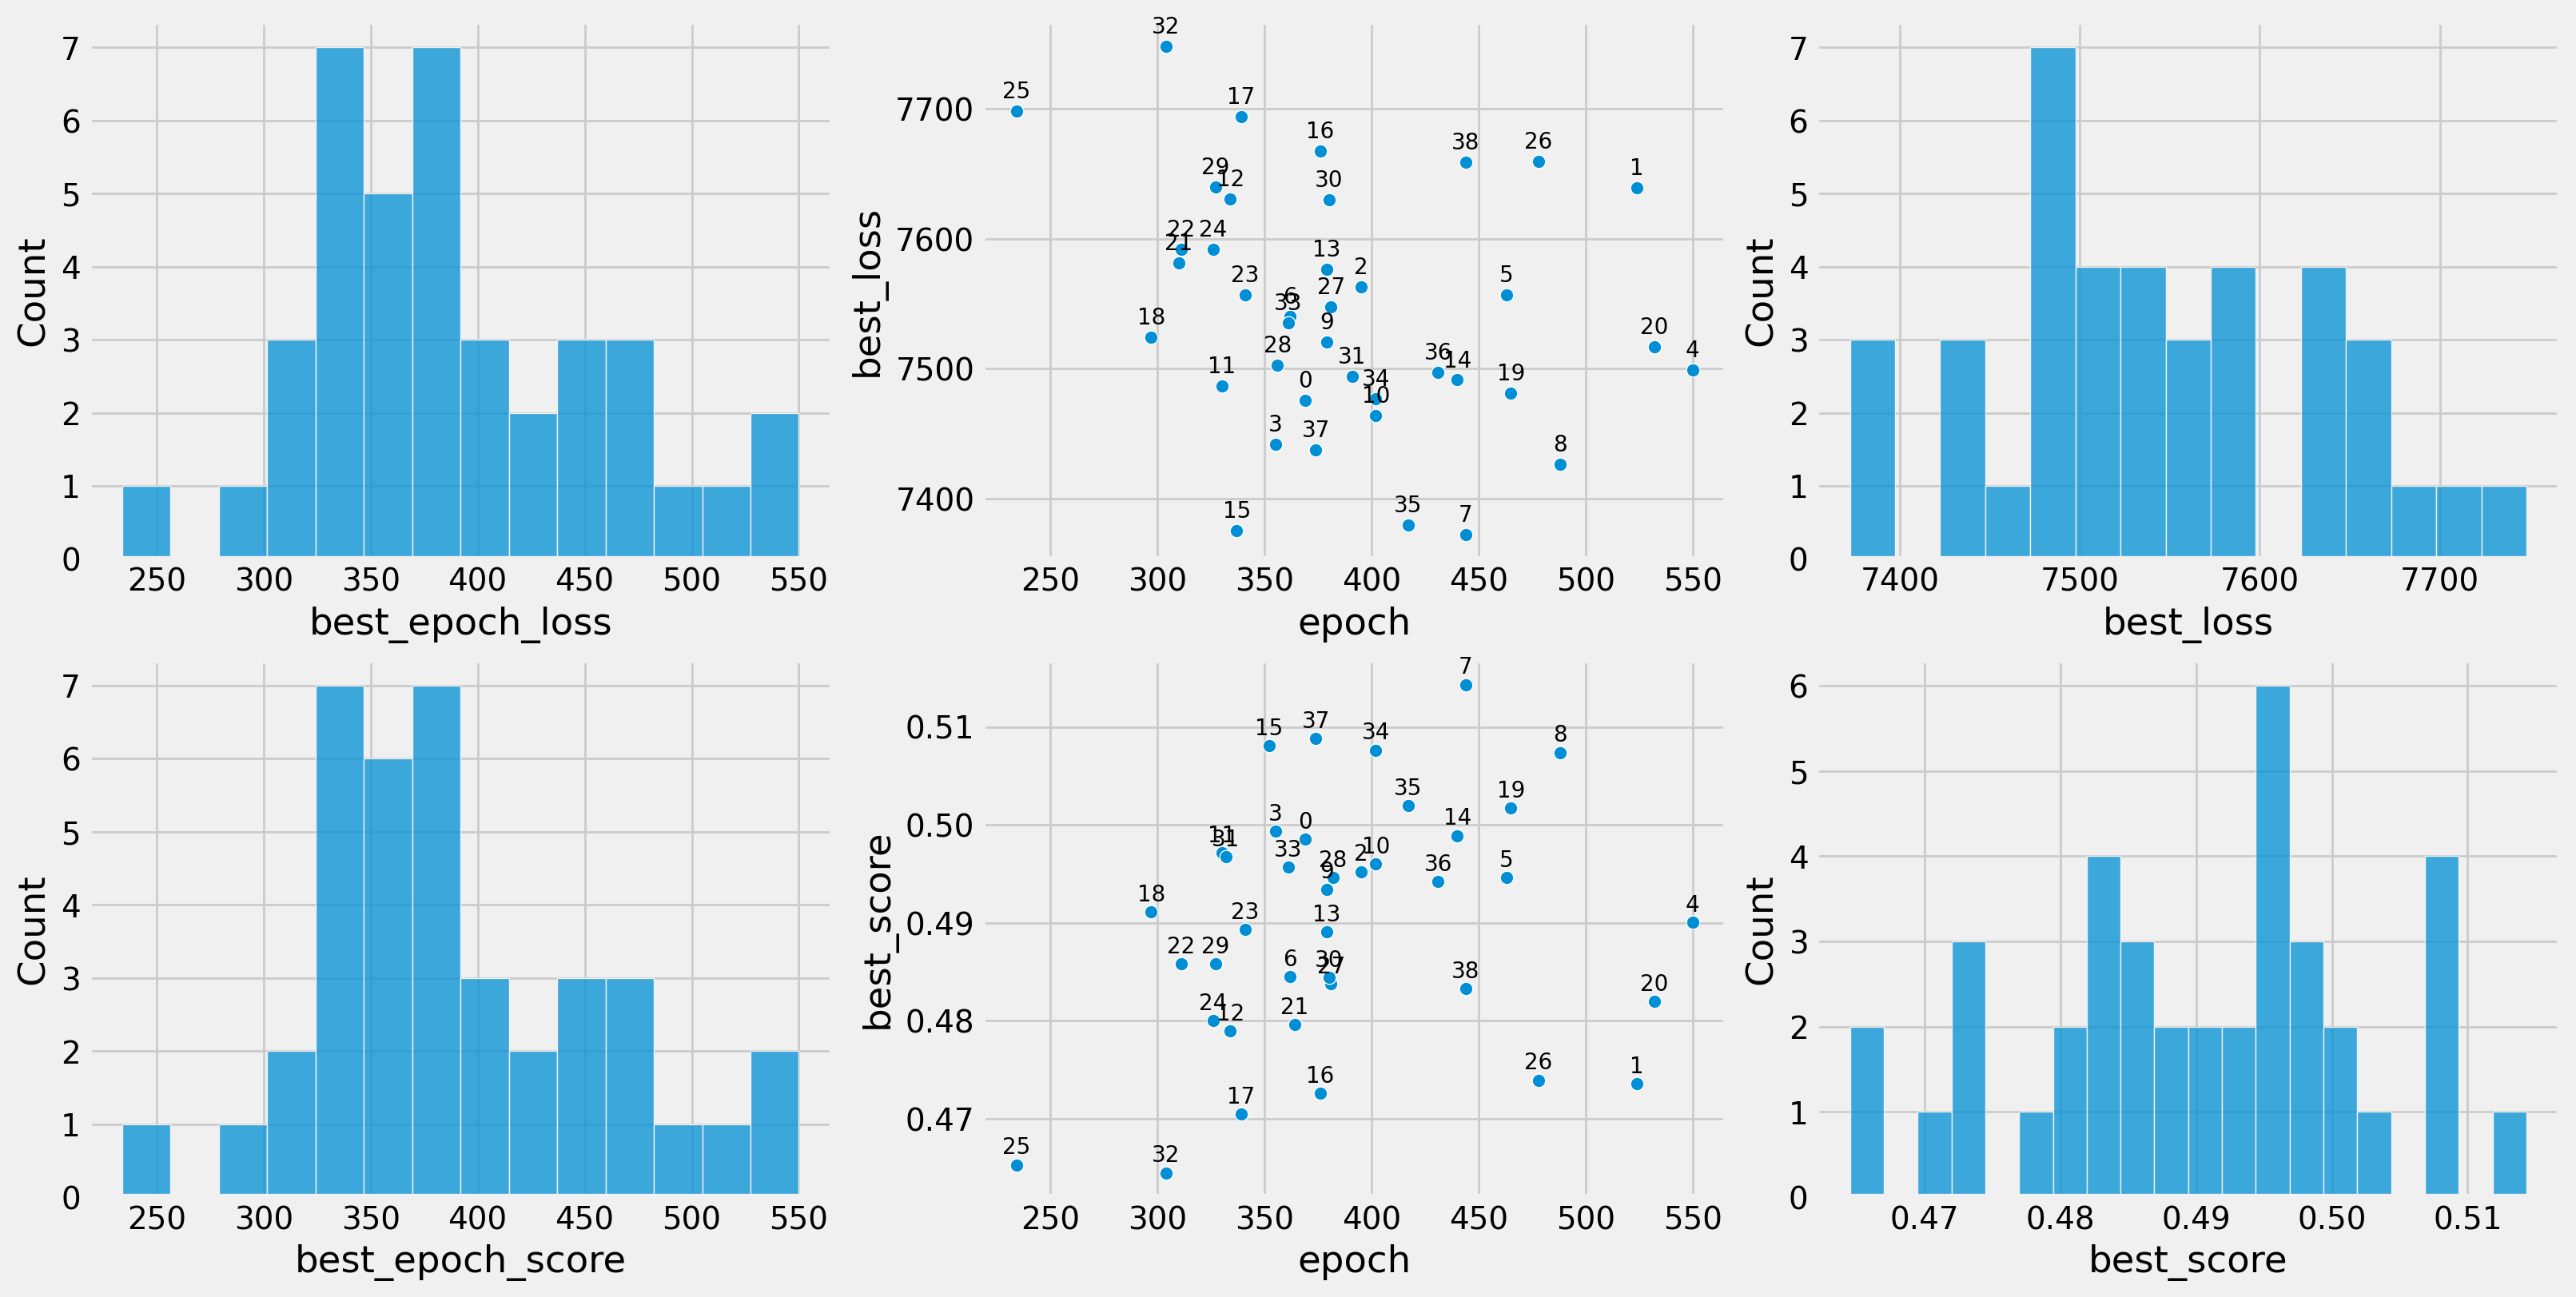

In [ ]:
plot_expt_dist_rslt(expt22_rslt)

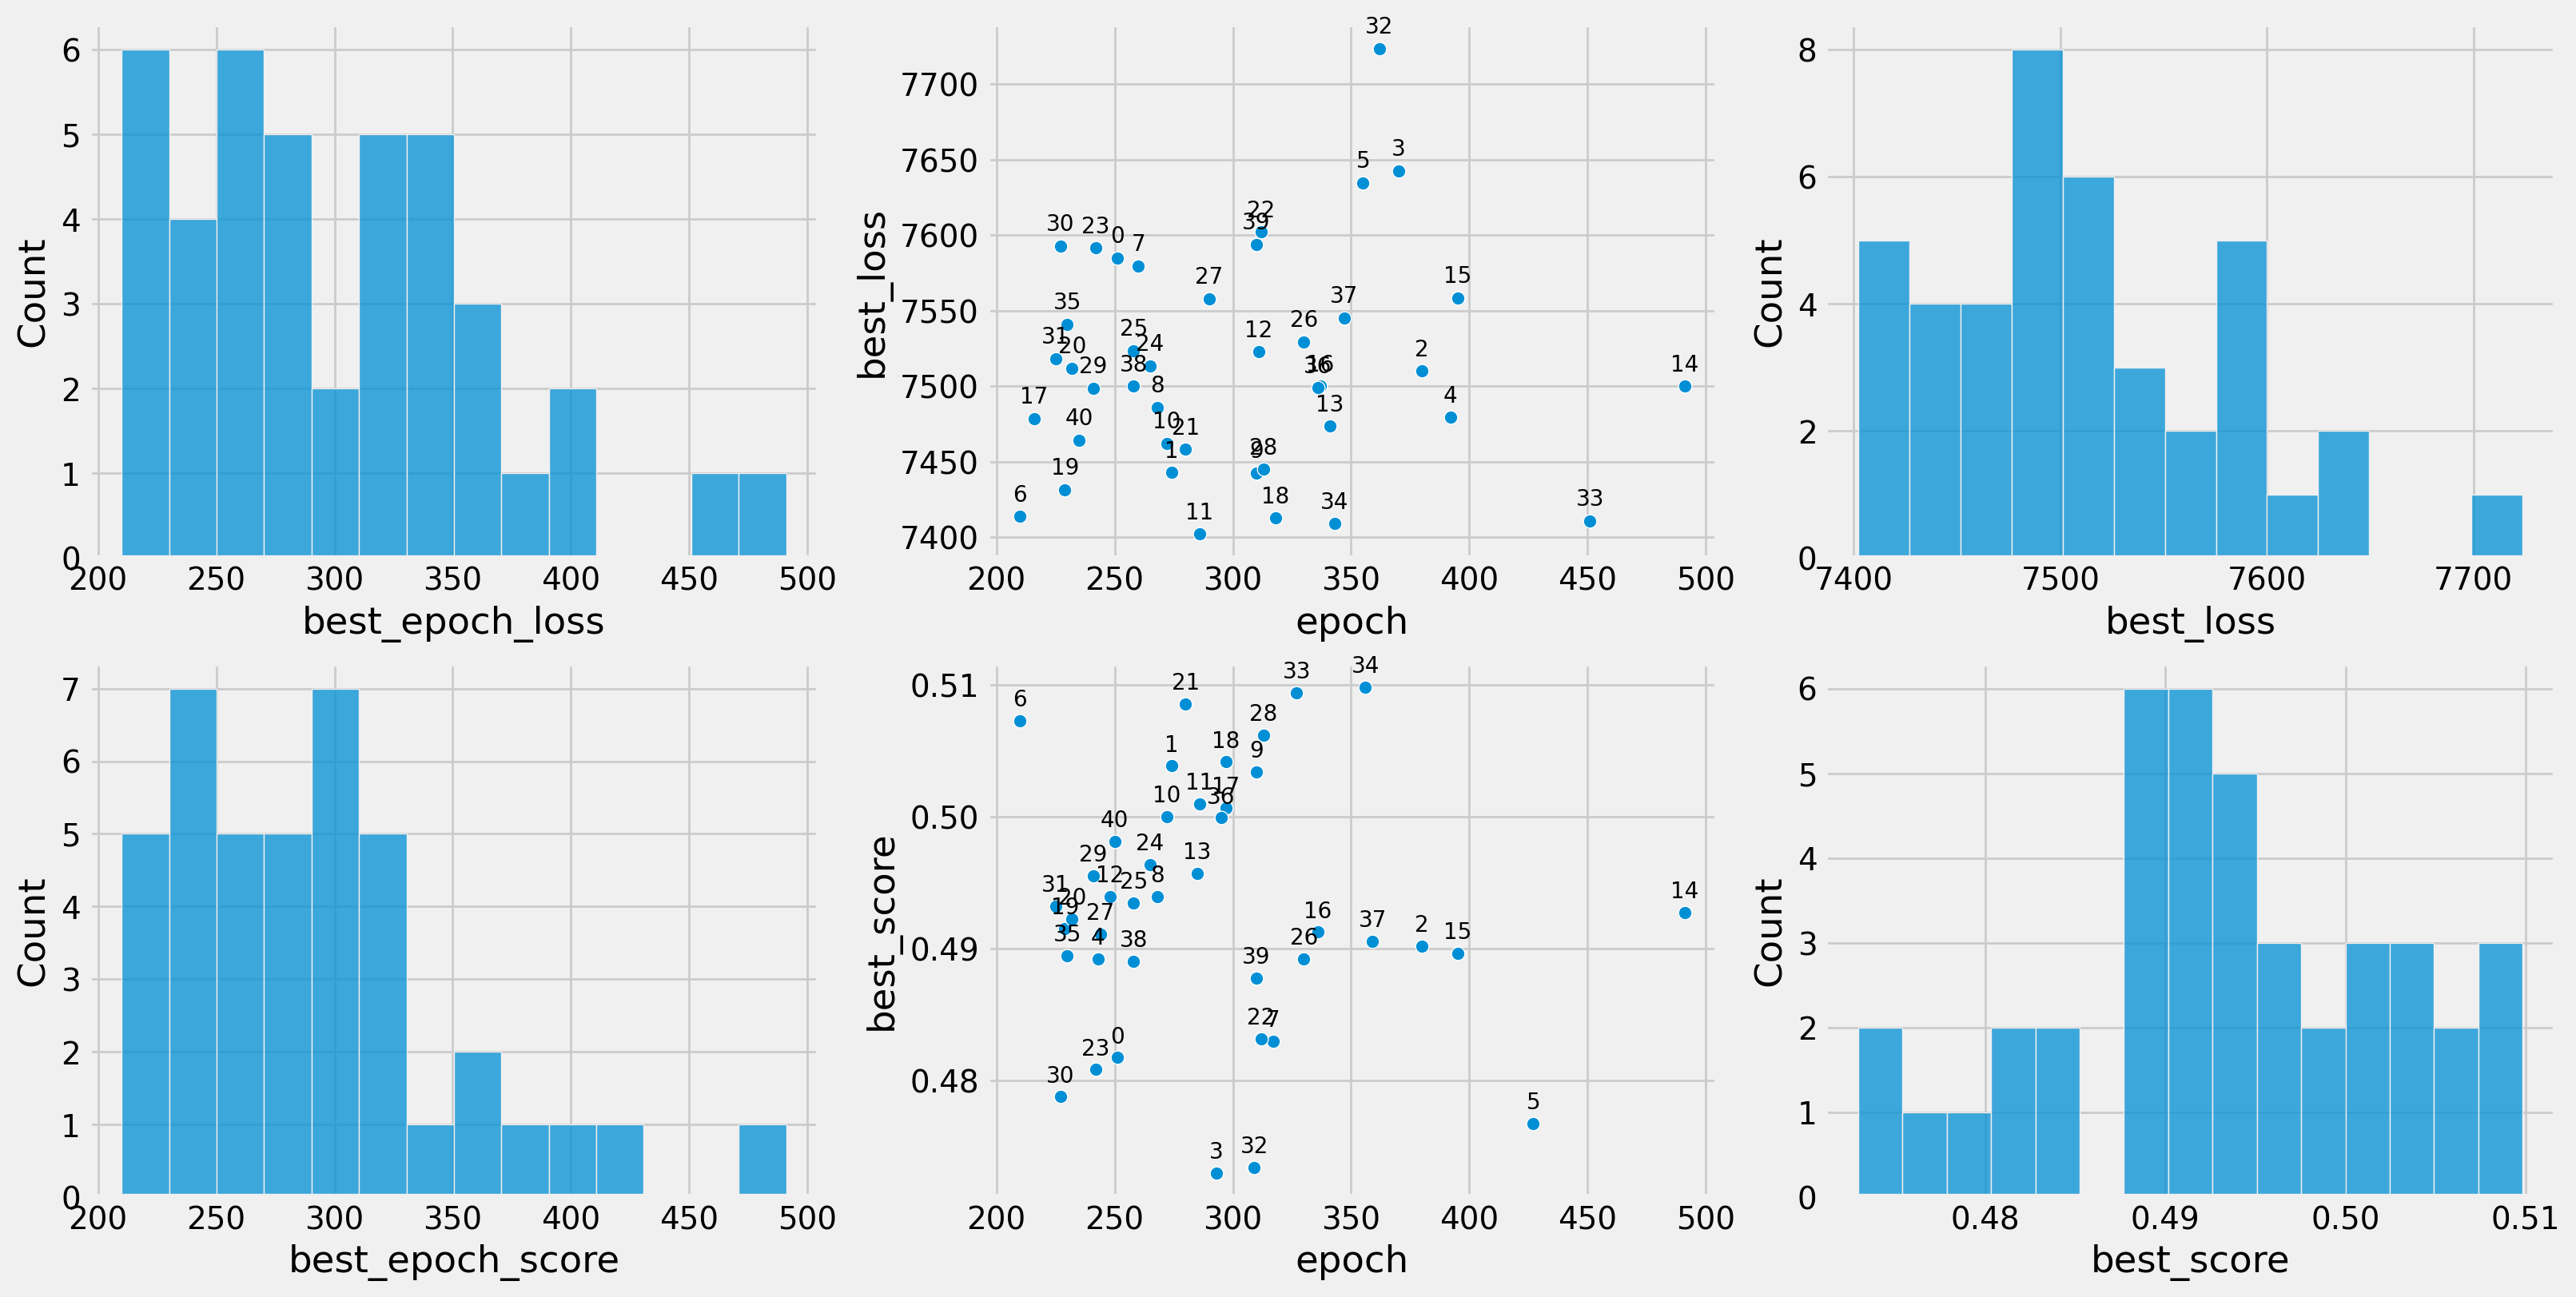

In [ ]:
plot_expt_dist_rslt(expt23_rslt)

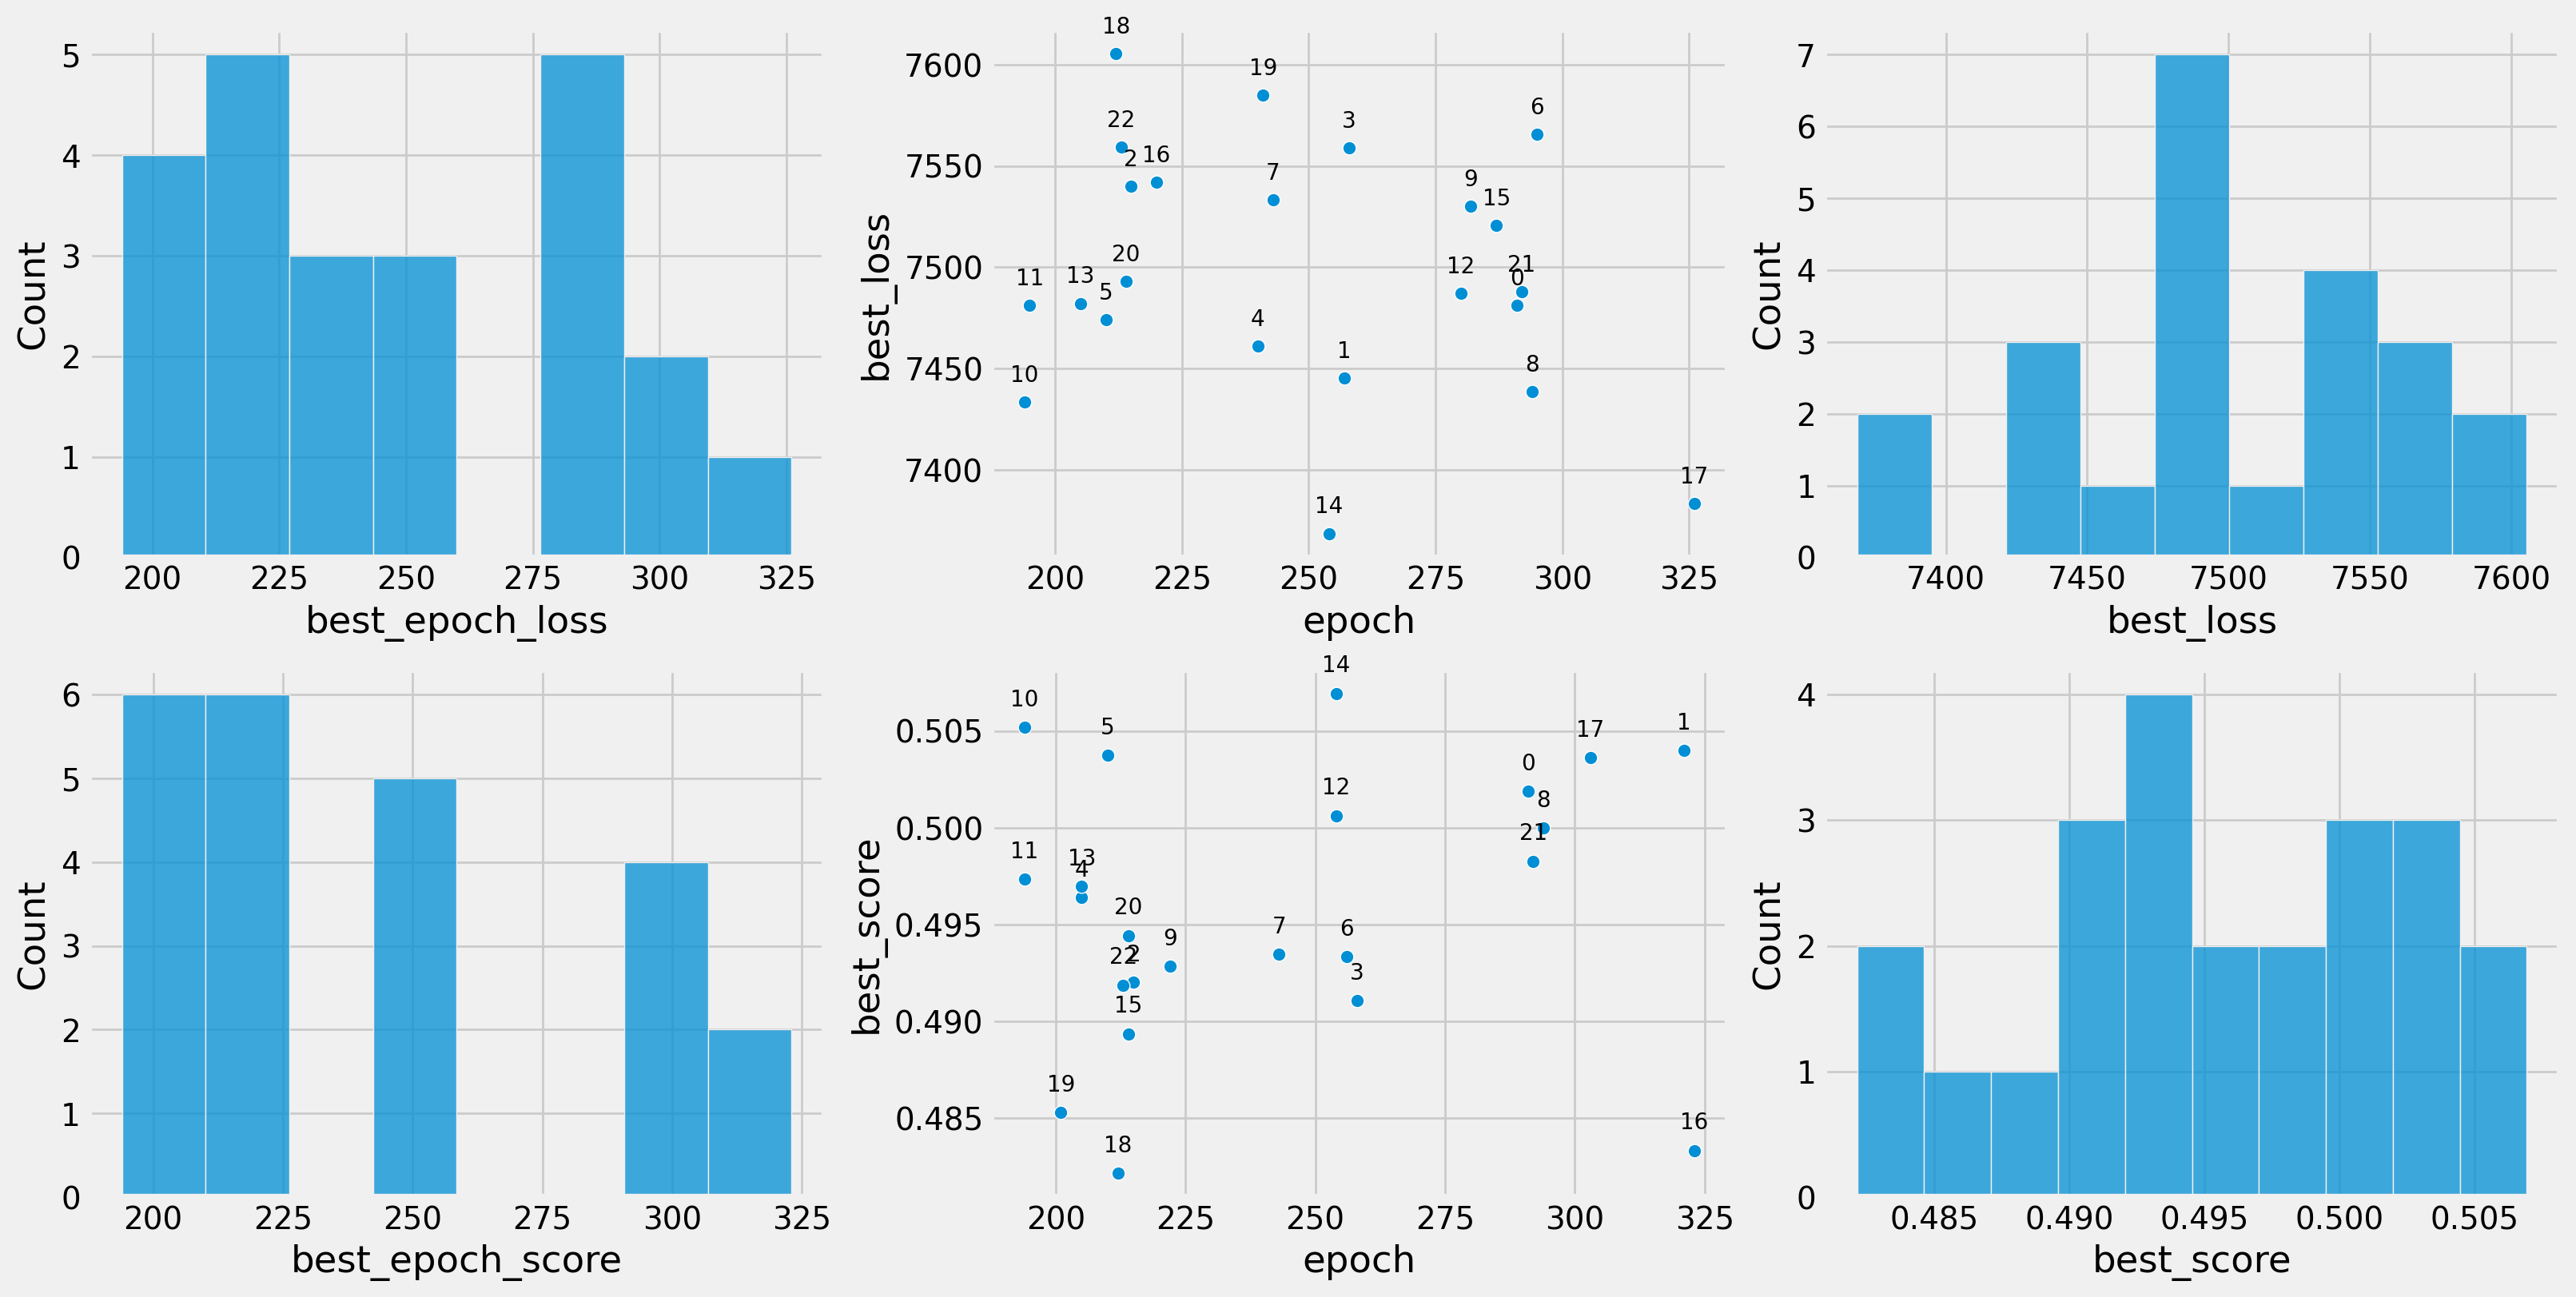

In [ ]:
plot_expt_dist_rslt(expt24_rslt)

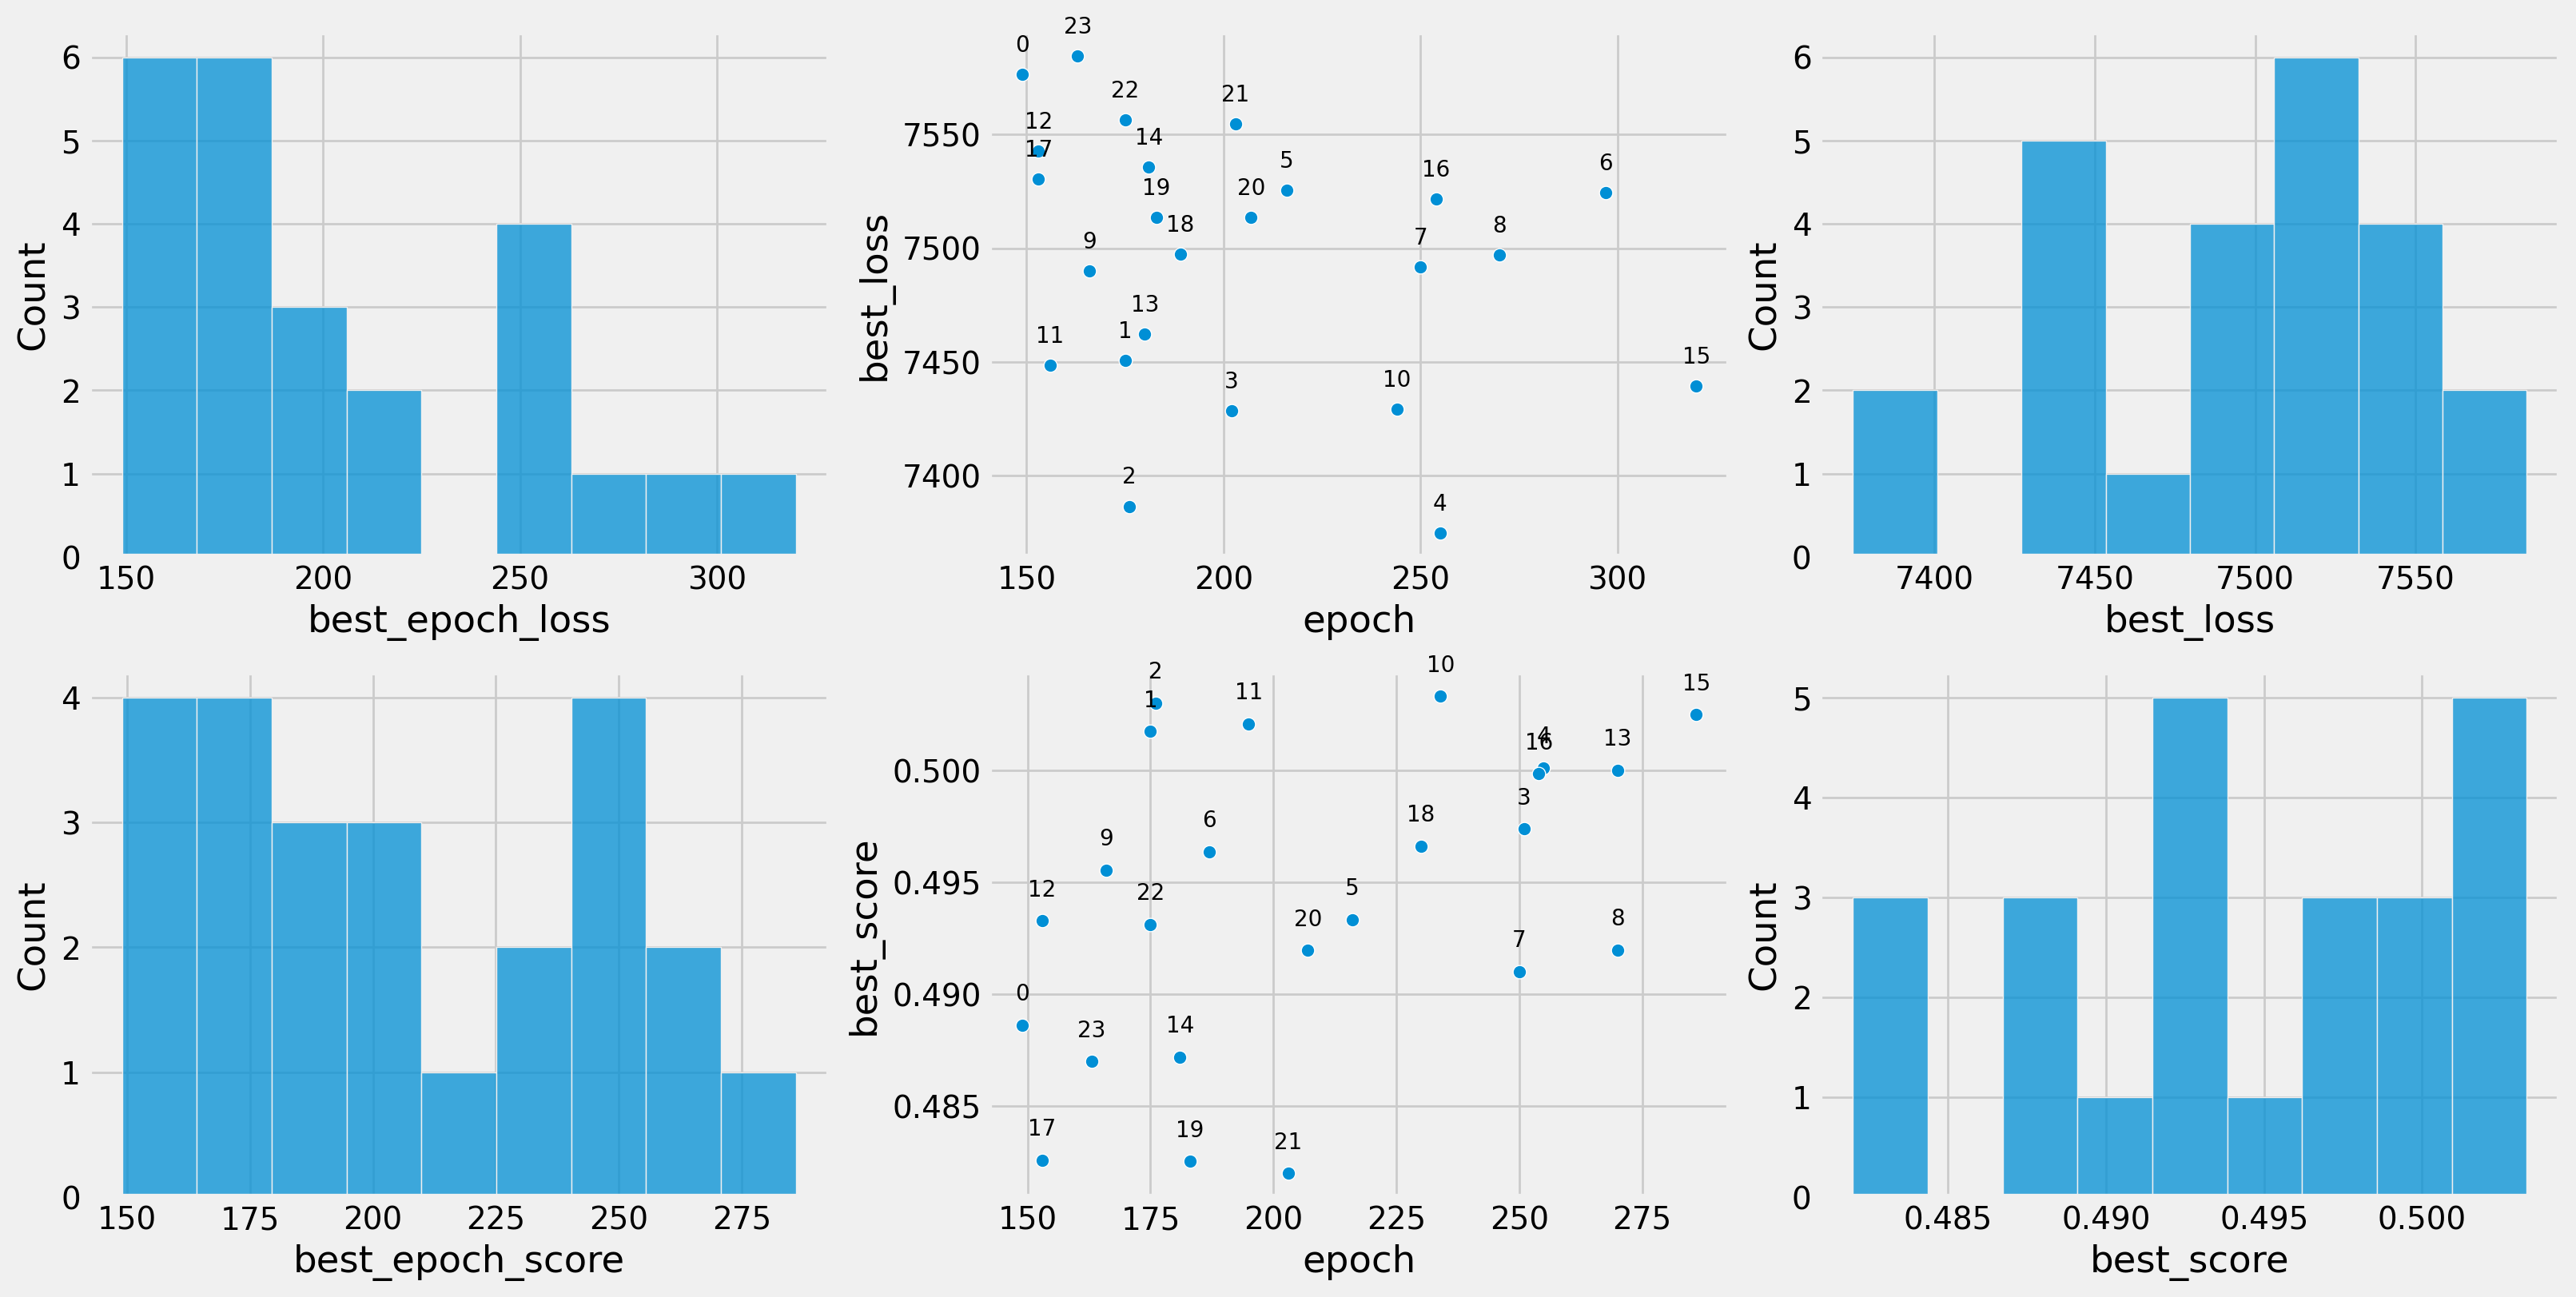

In [ ]:
plot_expt_dist_rslt(expt25_rslt)

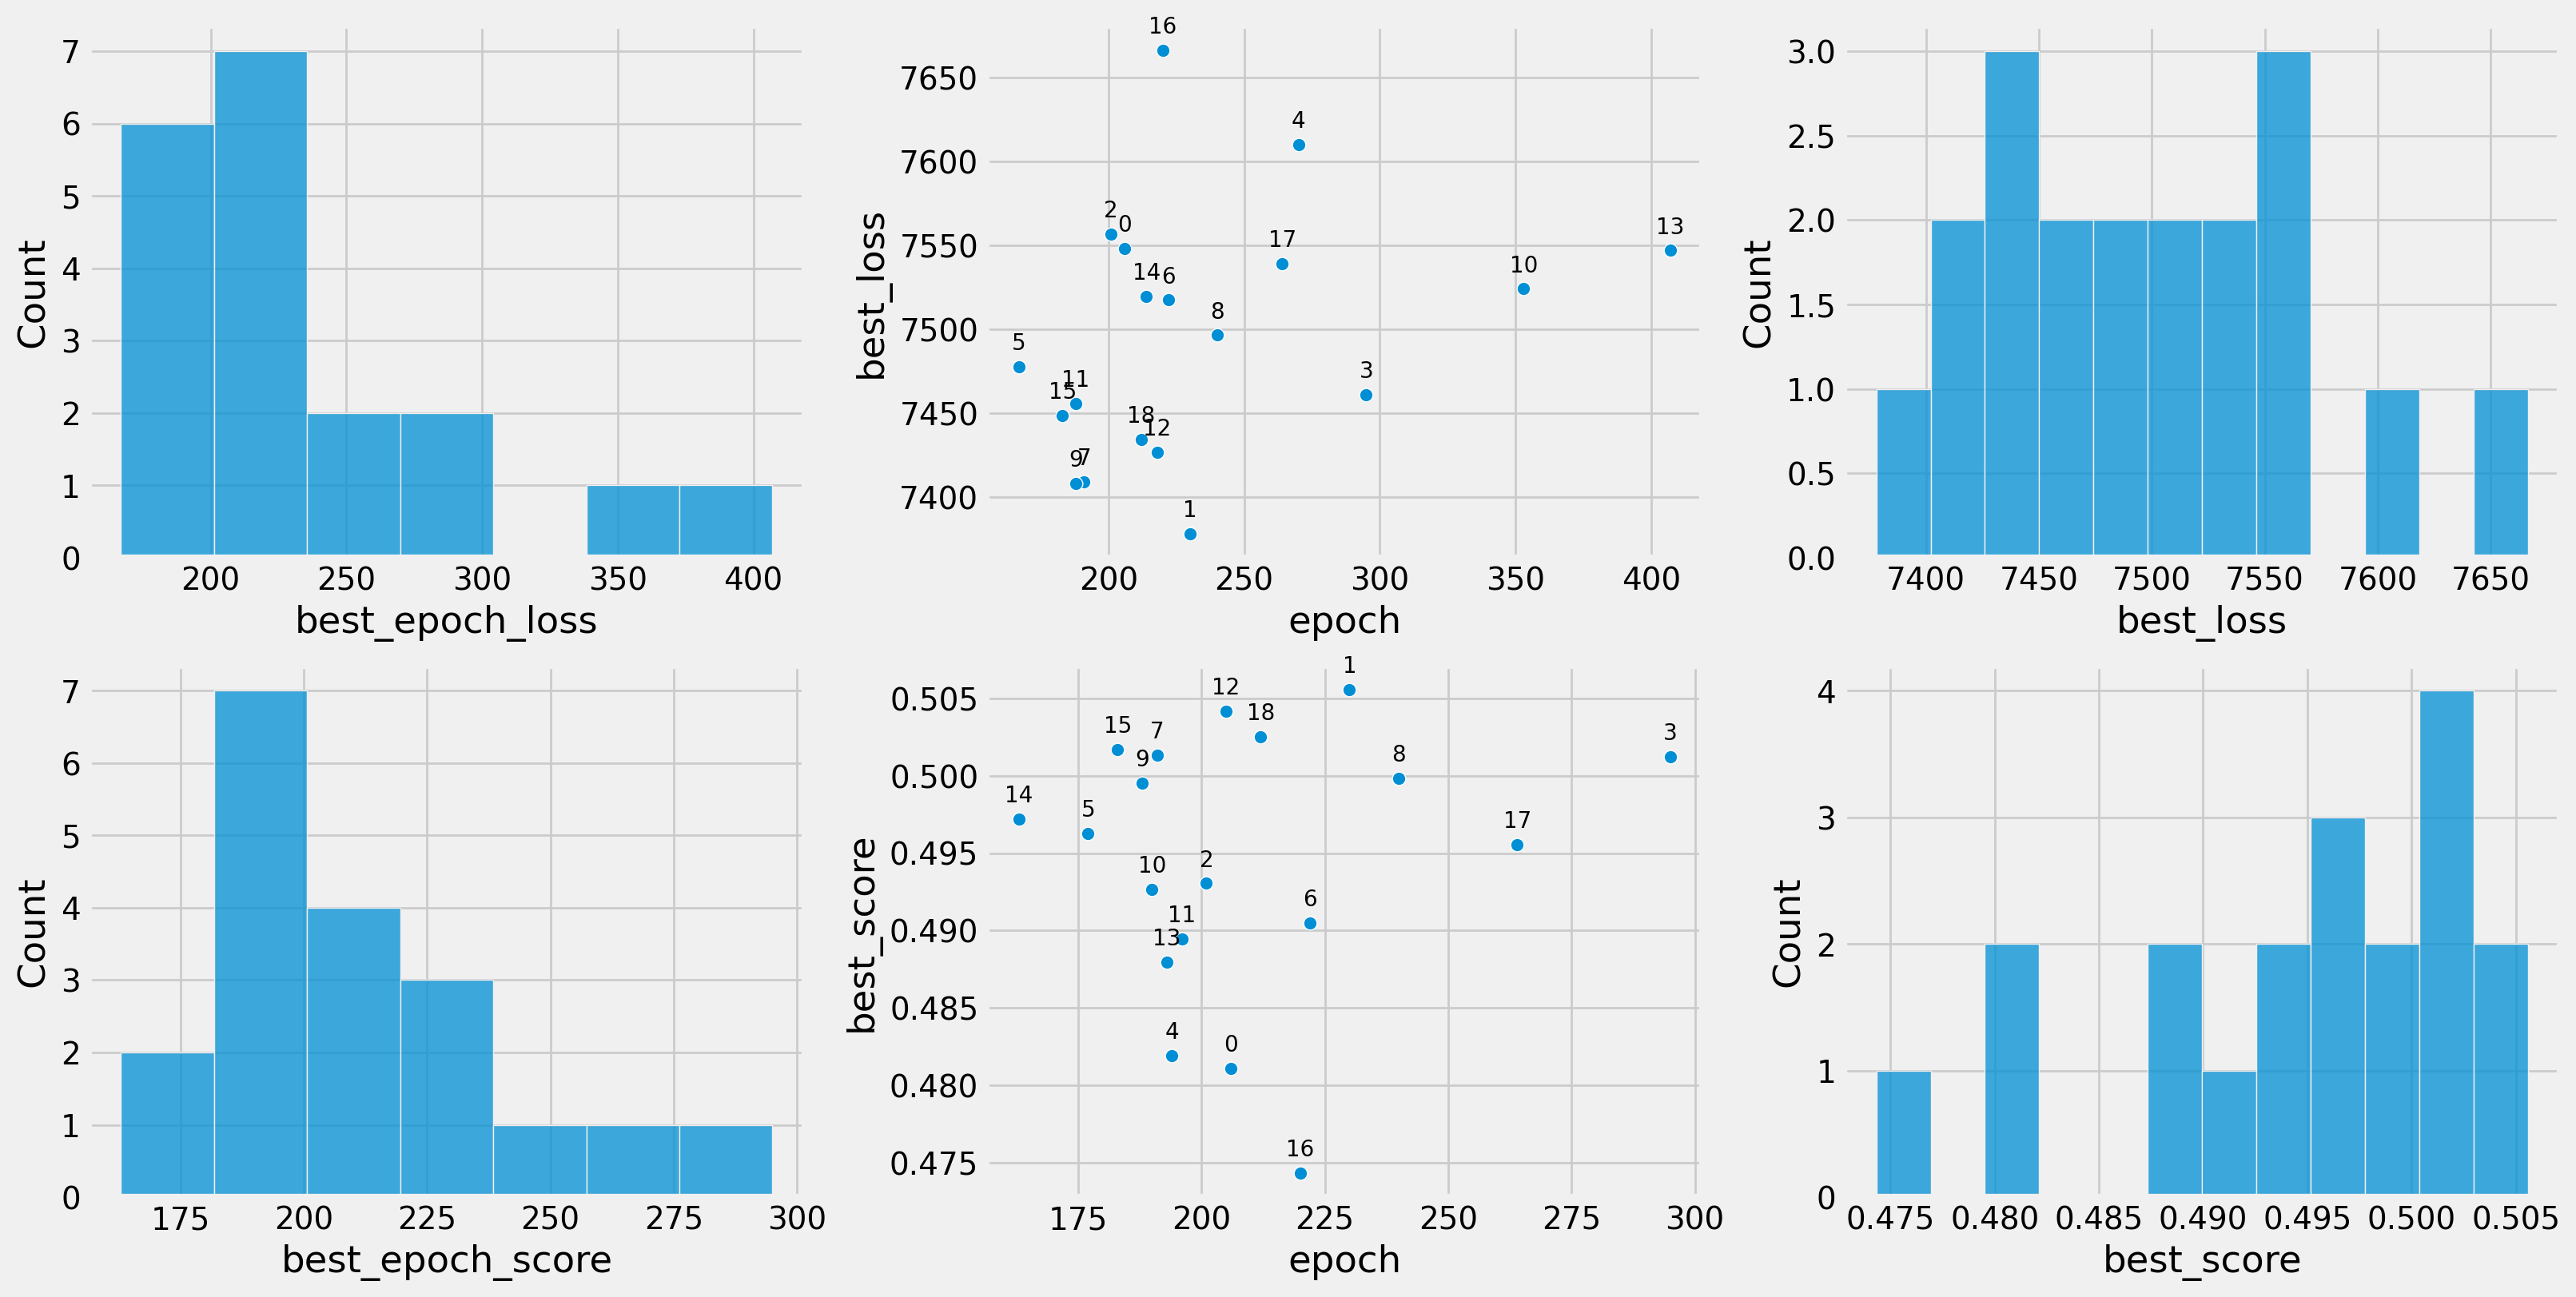

In [ ]:
plot_expt_dist_rslt(expt26_rslt)

In [ ]:
from collections import defaultdict

expt_rslt_dict = {
    '20480_2.0':expt20_rslt,
    '20480_2.1':expt21_rslt,
    '20480_2.2':expt22_rslt,
    '20480_2.3':expt23_rslt,
    '20480_2.4':expt24_rslt,
    '20480_2.5':expt25_rslt,
    '20480_2.6':expt26_rslt,
}

df_dict ={
    key : pd.DataFrame(val['valid_loss'])
    for key,val in expt_rslt_dict.items()
}

lr_dict = {
     '20480_2.0':1.76e-4,
     '20480_2.1':5e-4,
     '20480_2.2':2.84e-4,
     '20480_2.3':3.92e-4,
     '20480_2.4':4.46e-4,
     '20480_2.5':5.54e-4,
     '20480_2.6':5.27e-4,
}

def combine_val_dicts(dict1,dict2,name1='1',name2='2'):
  rslt = defaultdict(dict)
  for key,val in dict1.items():
    rslt[key][name1] = val
  for key,val in dict2.items():
    rslt[key][name2] = val
  return rslt

expt_dict = combine_val_dicts(df_dict,lr_dict,'df','lr')

for key,df in df_dict.items():
  df['epoch_approx'] = df['epoch'].apply(lambda x : round(x/10)*10)
  display(df.describe())
  print(df['epoch_approx'].mode())


epoch        score  epoch_approx
count   35.000000    35.000000     35.000000
mean   465.142857  7775.292646    465.714286
std     55.800139    95.354972     56.113630
min    355.000000  7611.662368    360.000000
25%    423.500000  7687.519691    420.000000
50%    466.000000  7775.850050    470.000000
75%    515.500000  7829.895511    515.000000
max    550.000000  7989.682347    550.000000

0    410
1    420
2    470
3    530
4    550
Name: epoch_approx, dtype: int64


epoch        score  epoch_approx
count   19.000000    19.000000     19.000000
mean   238.263158  7490.975121    240.000000
std     36.169112    63.701944     36.968455
min    181.000000  7384.473576    180.000000
25%    215.000000  7429.295120    215.000000
50%    226.000000  7507.883057    230.000000
75%    258.000000  7541.088407    260.000000
max    317.000000  7583.825684    320.000000

0    230
Name: epoch_approx, dtype: int64


epoch        score  epoch_approx
count   39.000000    39.000000     39.000000
mean   387.897436  7542.864392    387.692308
std     69.559060    92.747812     69.109430
min    234.000000  7372.300591    230.000000
25%    338.000000  7484.137482    340.000000
50%    379.000000  7535.232047    380.000000
75%    435.500000  7610.961269    435.000000
max    550.000000  7748.170365    550.000000

0    380
Name: epoch_approx, dtype: int64


epoch        score  epoch_approx
count   41.000000    41.000000     41.000000
mean   301.292683  7511.933315    301.463415
std     64.963930    71.986577     65.060010
min    210.000000  7402.174951    210.000000
25%    251.000000  7462.088180    250.000000
50%    290.000000  7500.055066    290.000000
75%    341.000000  7558.132309    340.000000
max    491.000000  7723.762943    490.000000

0    310
Name: epoch_approx, dtype: int64


epoch        score  epoch_approx
count   23.000000    23.000000     23.000000
mean   248.608696  7498.194174    248.260870
std     38.617870    60.663400     39.502839
min    194.000000  7368.654965    190.000000
25%    213.500000  7467.502346    210.000000
50%    243.000000  7487.950320    240.000000
75%    284.500000  7540.838155    285.000000
max    326.000000  7605.459355    330.000000

0    210
1    290
Name: epoch_approx, dtype: int64


epoch        score  epoch_approx
count   24.000000    24.000000     24.000000
mean   204.875000  7494.821326    205.416667
std     48.144089    56.654108     48.182548
min    149.000000  7374.599515    150.000000
25%    172.750000  7450.157160    177.500000
50%    186.000000  7505.397640    185.000000
75%    245.500000  7531.849471    242.500000
max    320.000000  7584.603615    320.000000

0    180
Name: epoch_approx, dtype: int64


epoch        score  epoch_approx
count   19.000000    19.000000     19.000000
mean   235.210526  7496.006506    235.263158
std     60.807144    73.804815     61.043556
min    167.000000  7378.078476    170.000000
25%    196.000000  7441.448873    195.000000
50%    218.000000  7496.445424    220.000000
75%    252.000000  7543.031390    250.000000
max    407.000000  7666.399546    410.000000

0    190
1    210
2    220
Name: epoch_approx, dtype: int64


<Axes: xlabel='epoch_approx', ylabel='count'>

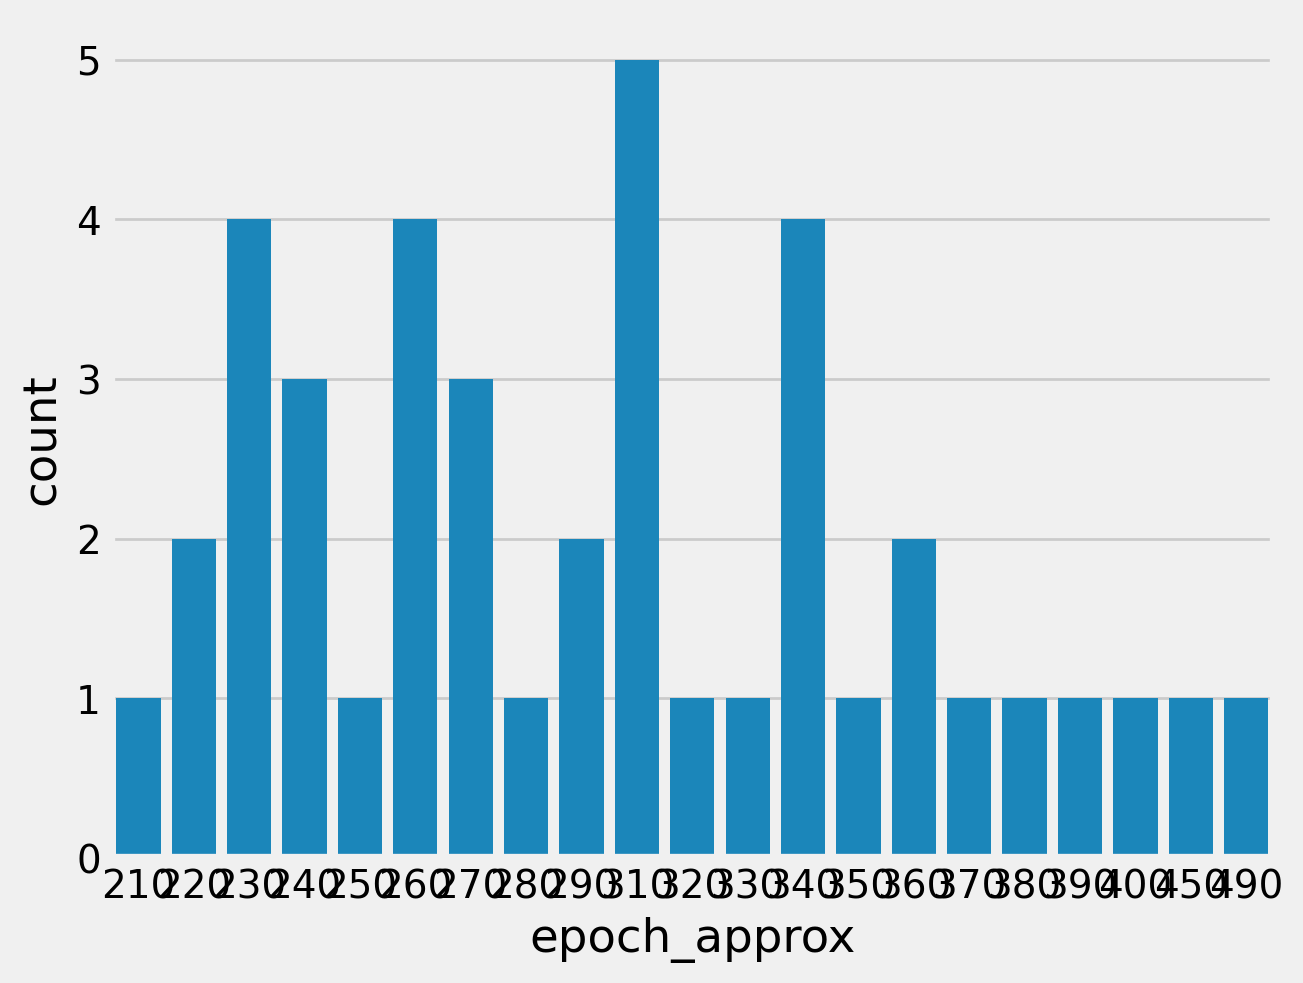

In [ ]:
sns.countplot(df_dict['20480_2.3'],x='epoch_approx')

In [ ]:
temp = df_dict['20480_2.3'].epoch.values
np.sort(temp)

array([210, 216, 225, 227, 229, 230, 232, 235, 241, 242, 251, 258, 258,
       260, 265, 268, 272, 274, 280, 286, 290, 310, 310, 311, 312, 313,
       318, 330, 336, 337, 341, 343, 347, 355, 362, 370, 380, 392, 395,
       451, 491])

In [ ]:
expt2_mode ={
    1.76e-4:410,
    2.84e-4:330,
    3.92e-4:275,
    5e-4:225,
}

df_mode = pd.DataFrame([expt2_mode]).T
df_mode = df_mode.reset_index(names='lr')
df_mode

lr    0
0  0.000176  410
1  0.000284  330
2  0.000392  275
3  0.000500  225

In [ ]:
expt2_mode = {
    val['lr'] : val['df']['epoch'].median()
    for val in expt_dict.values()
}

df_mode = pd.DataFrame([expt2_mode]).T
df_mode = df_mode.reset_index(names='lr')
df_mode = df_mode.sort_values('lr')
display(df_mode)

expt2_mean = {
    val['lr'] : val['df']['epoch'].mean()
    for val in expt_dict.values()
}

df_mean = pd.DataFrame([expt2_mean]).T
df_mean = df_mean.reset_index(names='lr')
df_mean = df_mean.sort_values('lr')
display(df_mean)

lr      0
0  0.000176  466.0
2  0.000284  379.0
3  0.000392  290.0
4  0.000446  243.0
1  0.000500  226.0
6  0.000527  218.0
5  0.000554  186.0

lr           0
0  0.000176  465.142857
2  0.000284  387.897436
3  0.000392  301.292683
4  0.000446  248.608696
1  0.000500  238.263158
6  0.000527  235.210526
5  0.000554  204.875000

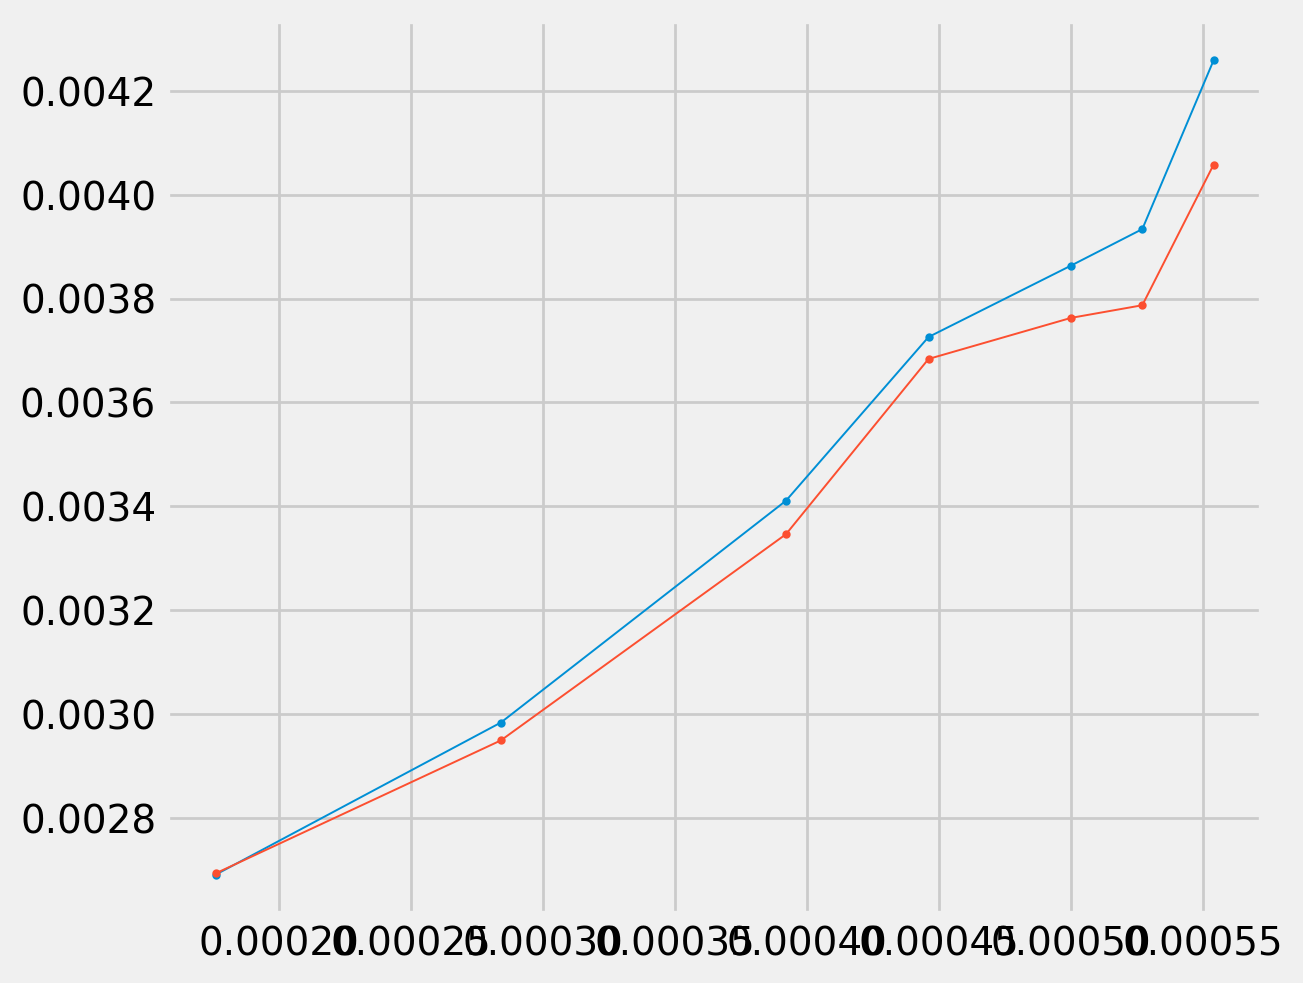

In [ ]:
fig,ax=plt.subplots()
y = (len(data_dict['trn']['X'])/20480)*60
plt.plot(df_mode.lr.to_numpy(),np.power(df_mode[0].to_numpy()*y,-0.5),lw=0.7,marker='o',markersize=2)
plt.plot(df_mode.lr.to_numpy(),np.power(df_mean[0].to_numpy()*y,-0.5),lw=0.7,marker='o',markersize=2)
#plt.plot(df_mode.lr.to_numpy(),np.power(df_mode.lr.to_numpy()*10,1),lw=0.7,marker='o',markersize=2)
#plt.plot(np.power(df_mode.lr.to_numpy(),1),(df_mode[0].to_numpy()),lw=0.7,marker='o',markersize=2)

In [ ]:
def get_lr_dict(expt_score_dict):
  temp = expt_score_dict
  temp['init_lr'] ={
    key : read_lr_from_name(key)
    for key in expt_score_dict['score'].keys()
  }
  return temp

def read_lr_from_name(dir_name) :
  temp = dir_name.split('_')
  return float(temp[-1])*float(temp[-2][2:])

def read_epoch_info(base_dir,expt_epoch,info):
  temp = dict()
  for key,val in expt_epoch.items():
    dat = load_pkl(os.path.join(base_dir,key,f'{info}.pkl'))
    temp[key] = float(dat[val-1])
  return temp

def add_epoch_info(base_dir,expt_epoch_dict,info):
  temp = expt_epoch_dict
  temp[info] = read_epoch_info(base_dir,expt_epoch_dict['epoch'],info)
  return temp



In [ ]:
def get_expt_whole_rslt_df(base_dir,expt_name):
  temp= check_best_epoch(base_dir,expt_name,'valid_loss',False)
  epoch, score = dict(), dict()
  for dir in temp.keys():
    epoch[dir] = temp[dir][0]
    score[dir] = temp[dir][1]

  rslt = {
     'epoch' : epoch,
     'score' : score
  }
  rslt = get_lr_dict(rslt)
  rslt = add_epoch_info(base_dir,rslt,'valid_score')
  return pd.DataFrame(rslt)

In [ ]:
idx_list = range(7)
df_expt_list = [get_expt_whole_rslt_df(os.path.join(RSLT_DIR,'model_test'),f'20480_2.{i}') for i in idx_list]

In [ ]:
temp = get_expt_whole_rslt_df(os.path.join(RSLT_DIR,'model_test'),'20480_2.1')

a = temp['valid_score']['model4.5_20480_2.1_0_lr0.0005_1']
a

0.5010712742805481

<Axes: xlabel='init_lr', ylabel='valid_score'>

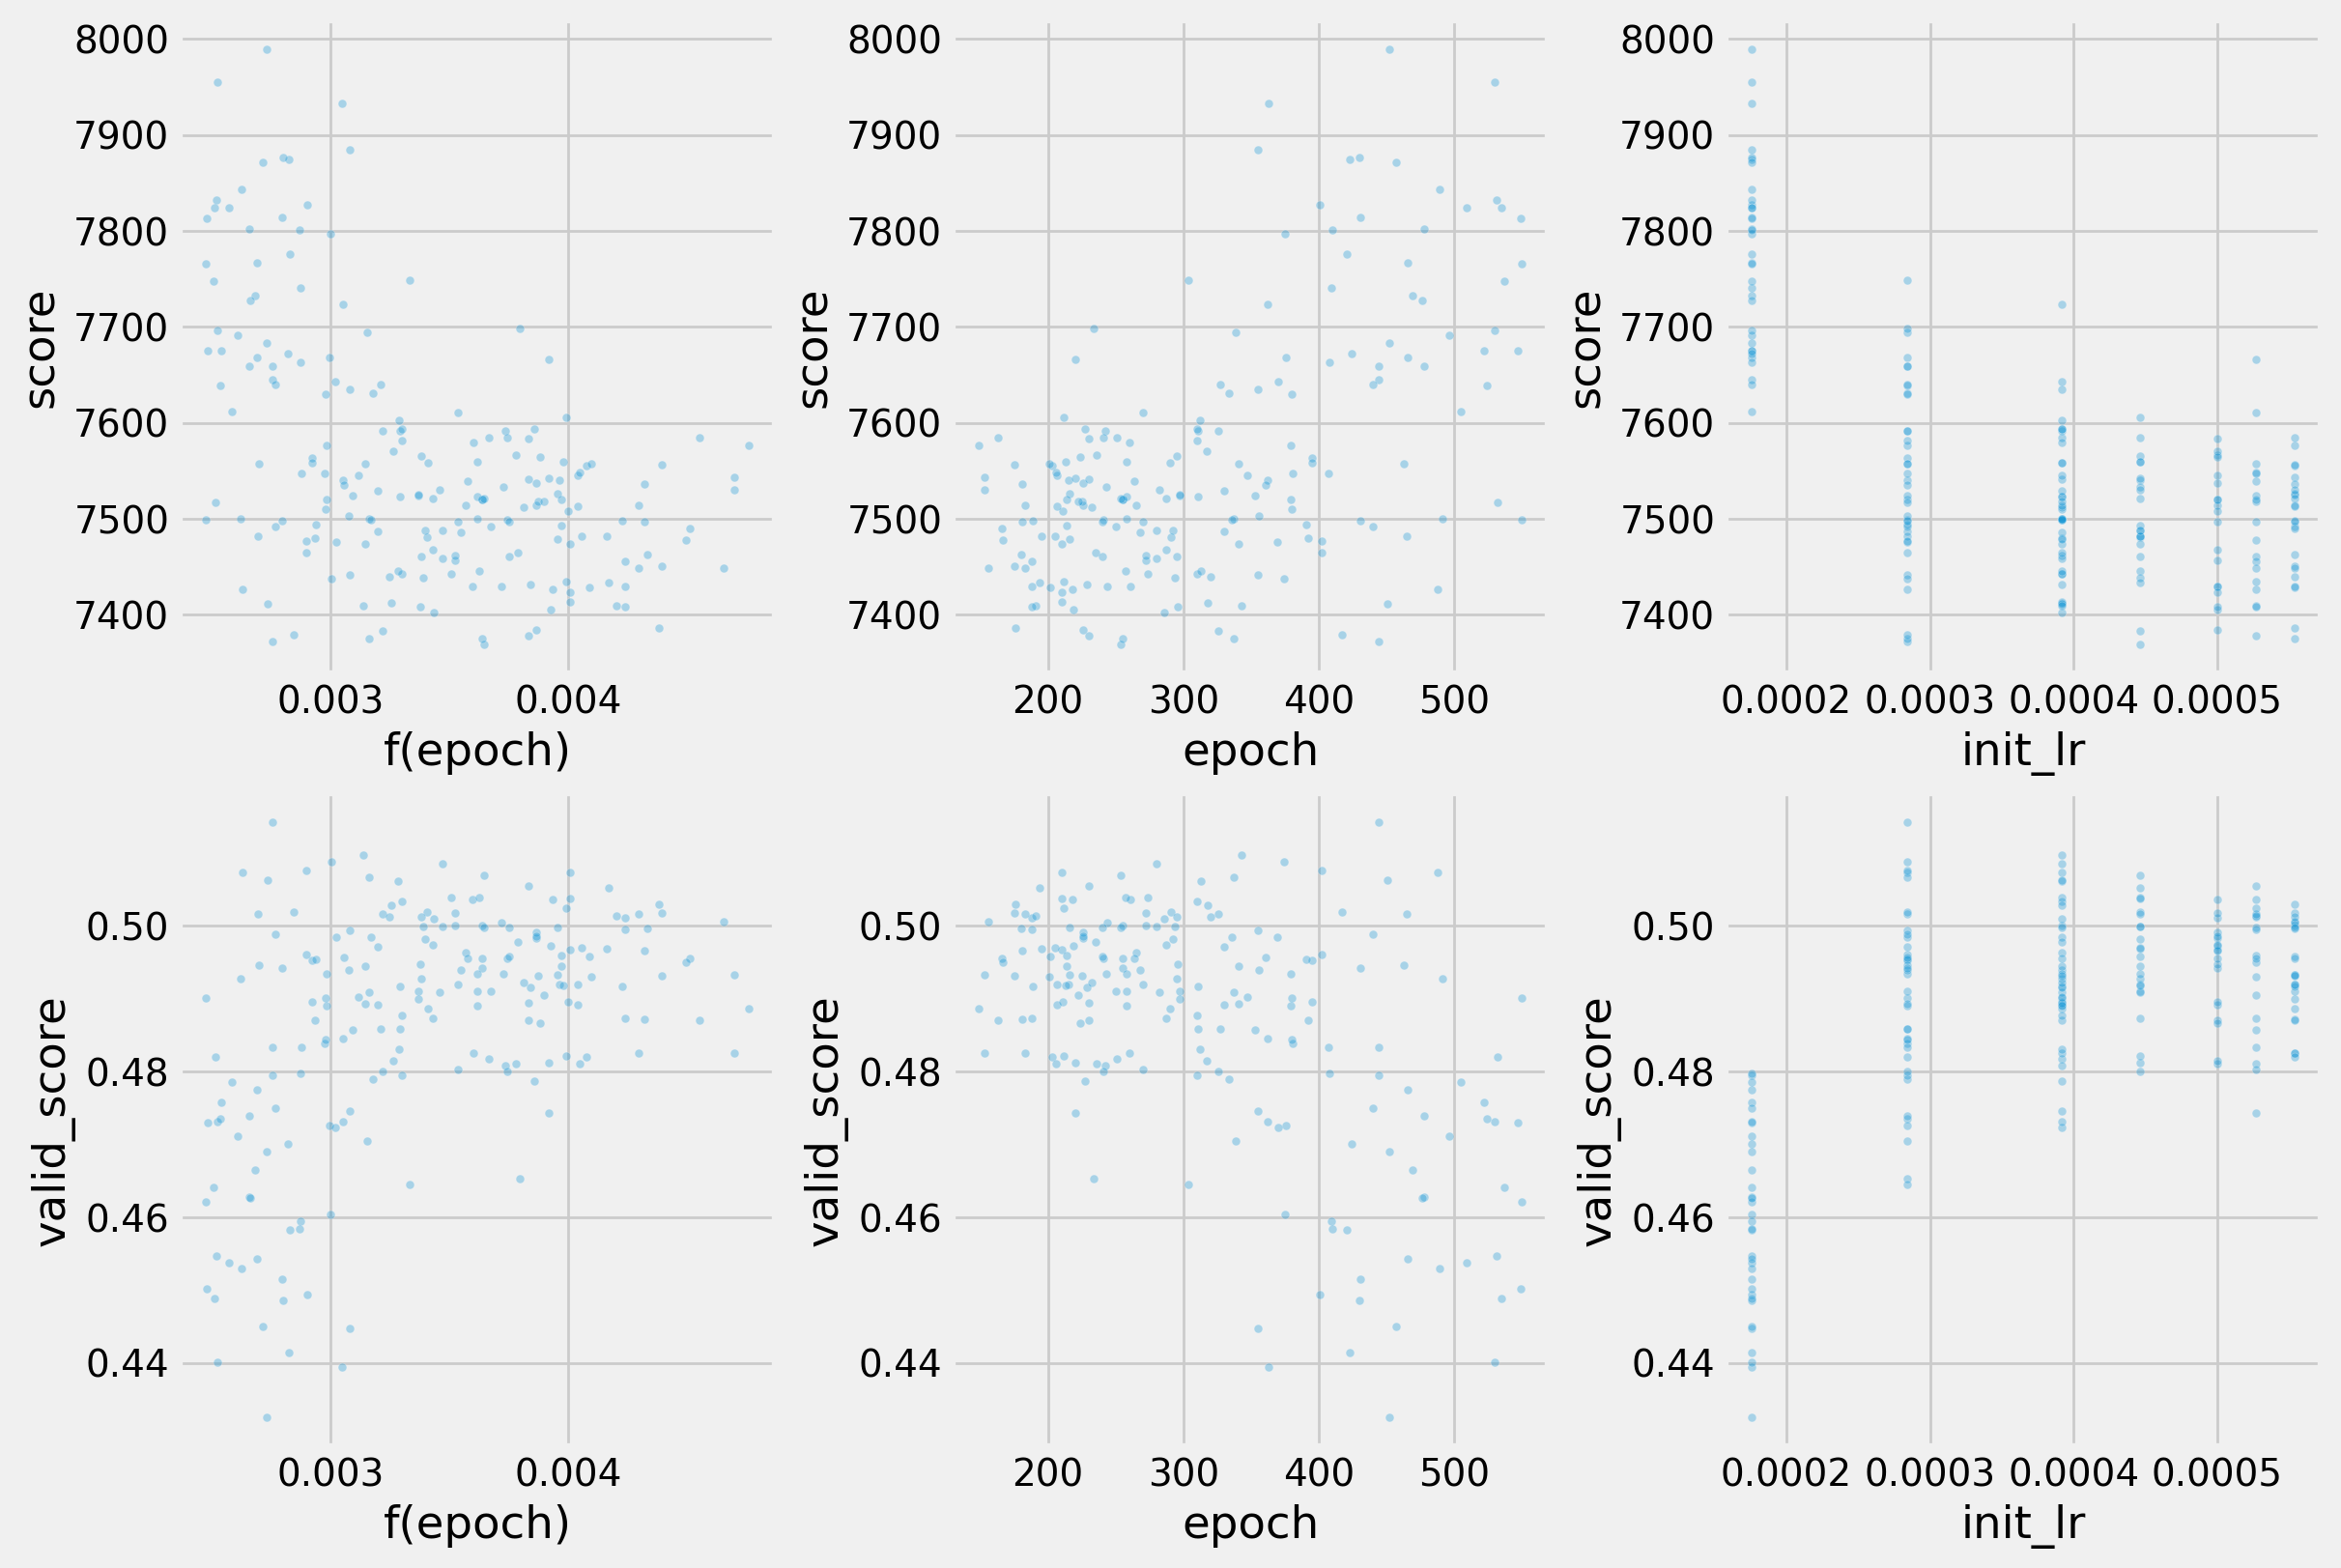

In [ ]:
df_whole = pd.concat(df_expt_list)
coeff = (len(data_dict['trn']['X'])/20480)*60
df_whole['f(epoch)'] = np.power(coeff * df_whole['epoch'],-0.5)

fig,axes = plt.subplots(2,3,figsize=(12,8))
sns.scatterplot(data=df_whole,x='f(epoch)',y='score',alpha=0.3,s=10,ax=axes[0][0])
sns.scatterplot(data=df_whole,x='epoch',y='score',alpha=0.3,s=10,ax=axes[0][1])
sns.scatterplot(data=df_whole,x='init_lr',y='score',alpha=0.3,s=10,ax=axes[0][2])
sns.scatterplot(data=df_whole,x='f(epoch)',y='valid_score',alpha=0.3,s=10,ax=axes[1][0])
sns.scatterplot(data=df_whole,x='epoch',y='valid_score',alpha=0.3,s=10,ax=axes[1][1])
sns.scatterplot(data=df_whole,x='init_lr',y='valid_score',alpha=0.3,s=10,ax=axes[1][2])

#ax.scatter(df_mode.lr.to_numpy(),np.power(df_mode[0].to_numpy()*coeff,-0.5),lw=0.7,marker='x',s=45,color='#34d3af')

In [ ]:
df_expt_list[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, model4.5_20480_2.0_0_lr0.000176_1 to model4.5_20480_2.0_34_lr0.000176_1
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   epoch        35 non-null     int64  
 1   score        35 non-null     float64
 2   init_lr      35 non-null     float64
 3   valid_score  35 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 1.4+ KB


In [ ]:
df_expt_list[0].head()

epoch        score   init_lr  valid_score
model4.5_20480_2.0_0_lr0.000176_1    444  7644.933747  0.000176     0.479500
model4.5_20480_2.0_1_lr0.000176_1    431  7814.182747  0.000176     0.451432
model4.5_20480_2.0_2_lr0.000176_1    375  7796.965564  0.000176     0.460336
model4.5_20480_2.0_3_lr0.000176_1    423  7873.925069  0.000176     0.441390
model4.5_20480_2.0_4_lr0.000176_1    452  7989.682347  0.000176     0.432457

In [ ]:
from decimal import Decimal

def plot_expt_data_rslt(data,y_down=[]):
  fig,axes = plt.subplots(2,2,figsize=(10,8))
  axes_flat = axes.flatten()
  sns.histplot(data=data,x='epoch',ax=axes_flat[0],bins=(len(data)//3)+1)
  axes_flat[0].set_xlabel('best_epoch_loss')

  sns.scatterplot(data = data,x='epoch',y='score',ax=axes_flat[1])
  for i,dir in enumerate(data.index):
    x,y = data.loc[dir,'epoch'],data.loc[dir,'score']
    axes_flat[1].annotate(f'{i}',xy = (x,y),xytext = (x,y+10), fontsize = 10, ha='center')
  axes_flat[1].set_ylabel('best_loss')

  sns.histplot(data=data,x='score',ax=axes_flat[2],binwidth=25)
  axes_flat[2].set_xlabel('best_loss')

  sns.scatterplot(data = data,x='epoch',y='valid_score',ax=axes_flat[3])
  for i,dir in enumerate(data.index):
    x,y = data.loc[dir,'epoch'],data.loc[dir,'valid_score']
    axes_flat[3].annotate(f'{i}',xy = (x,y),xytext = (x,y+0.0011), fontsize = 10, ha='center')
  axes_flat[3].set_ylabel('best_score')



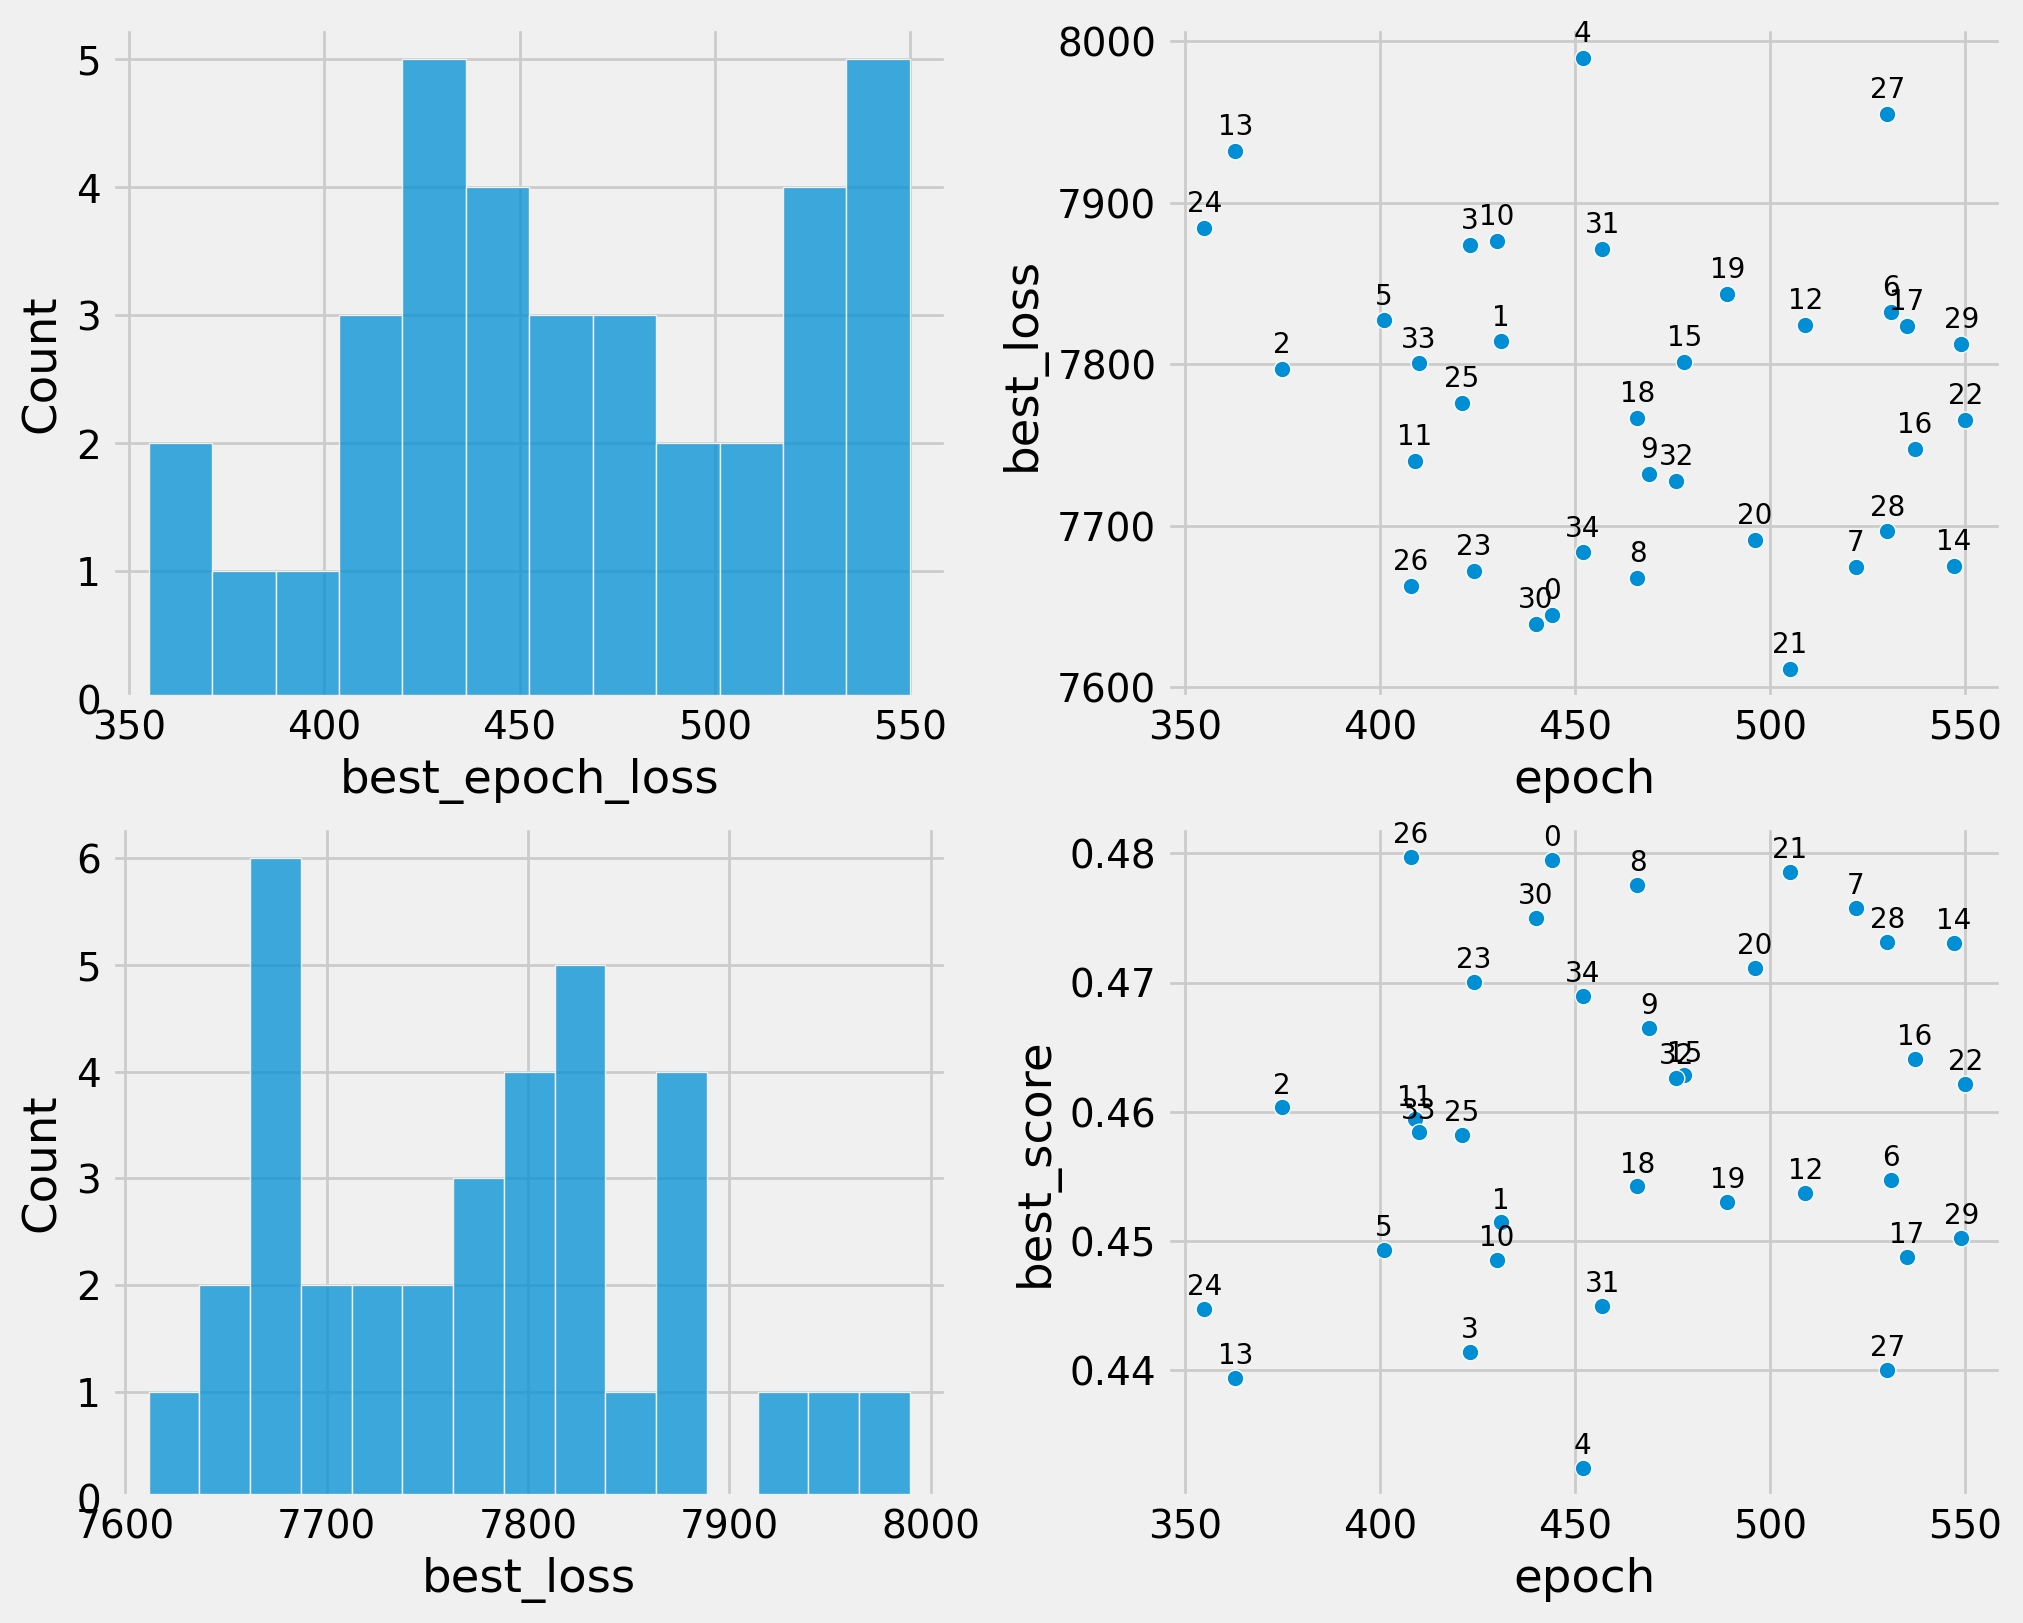

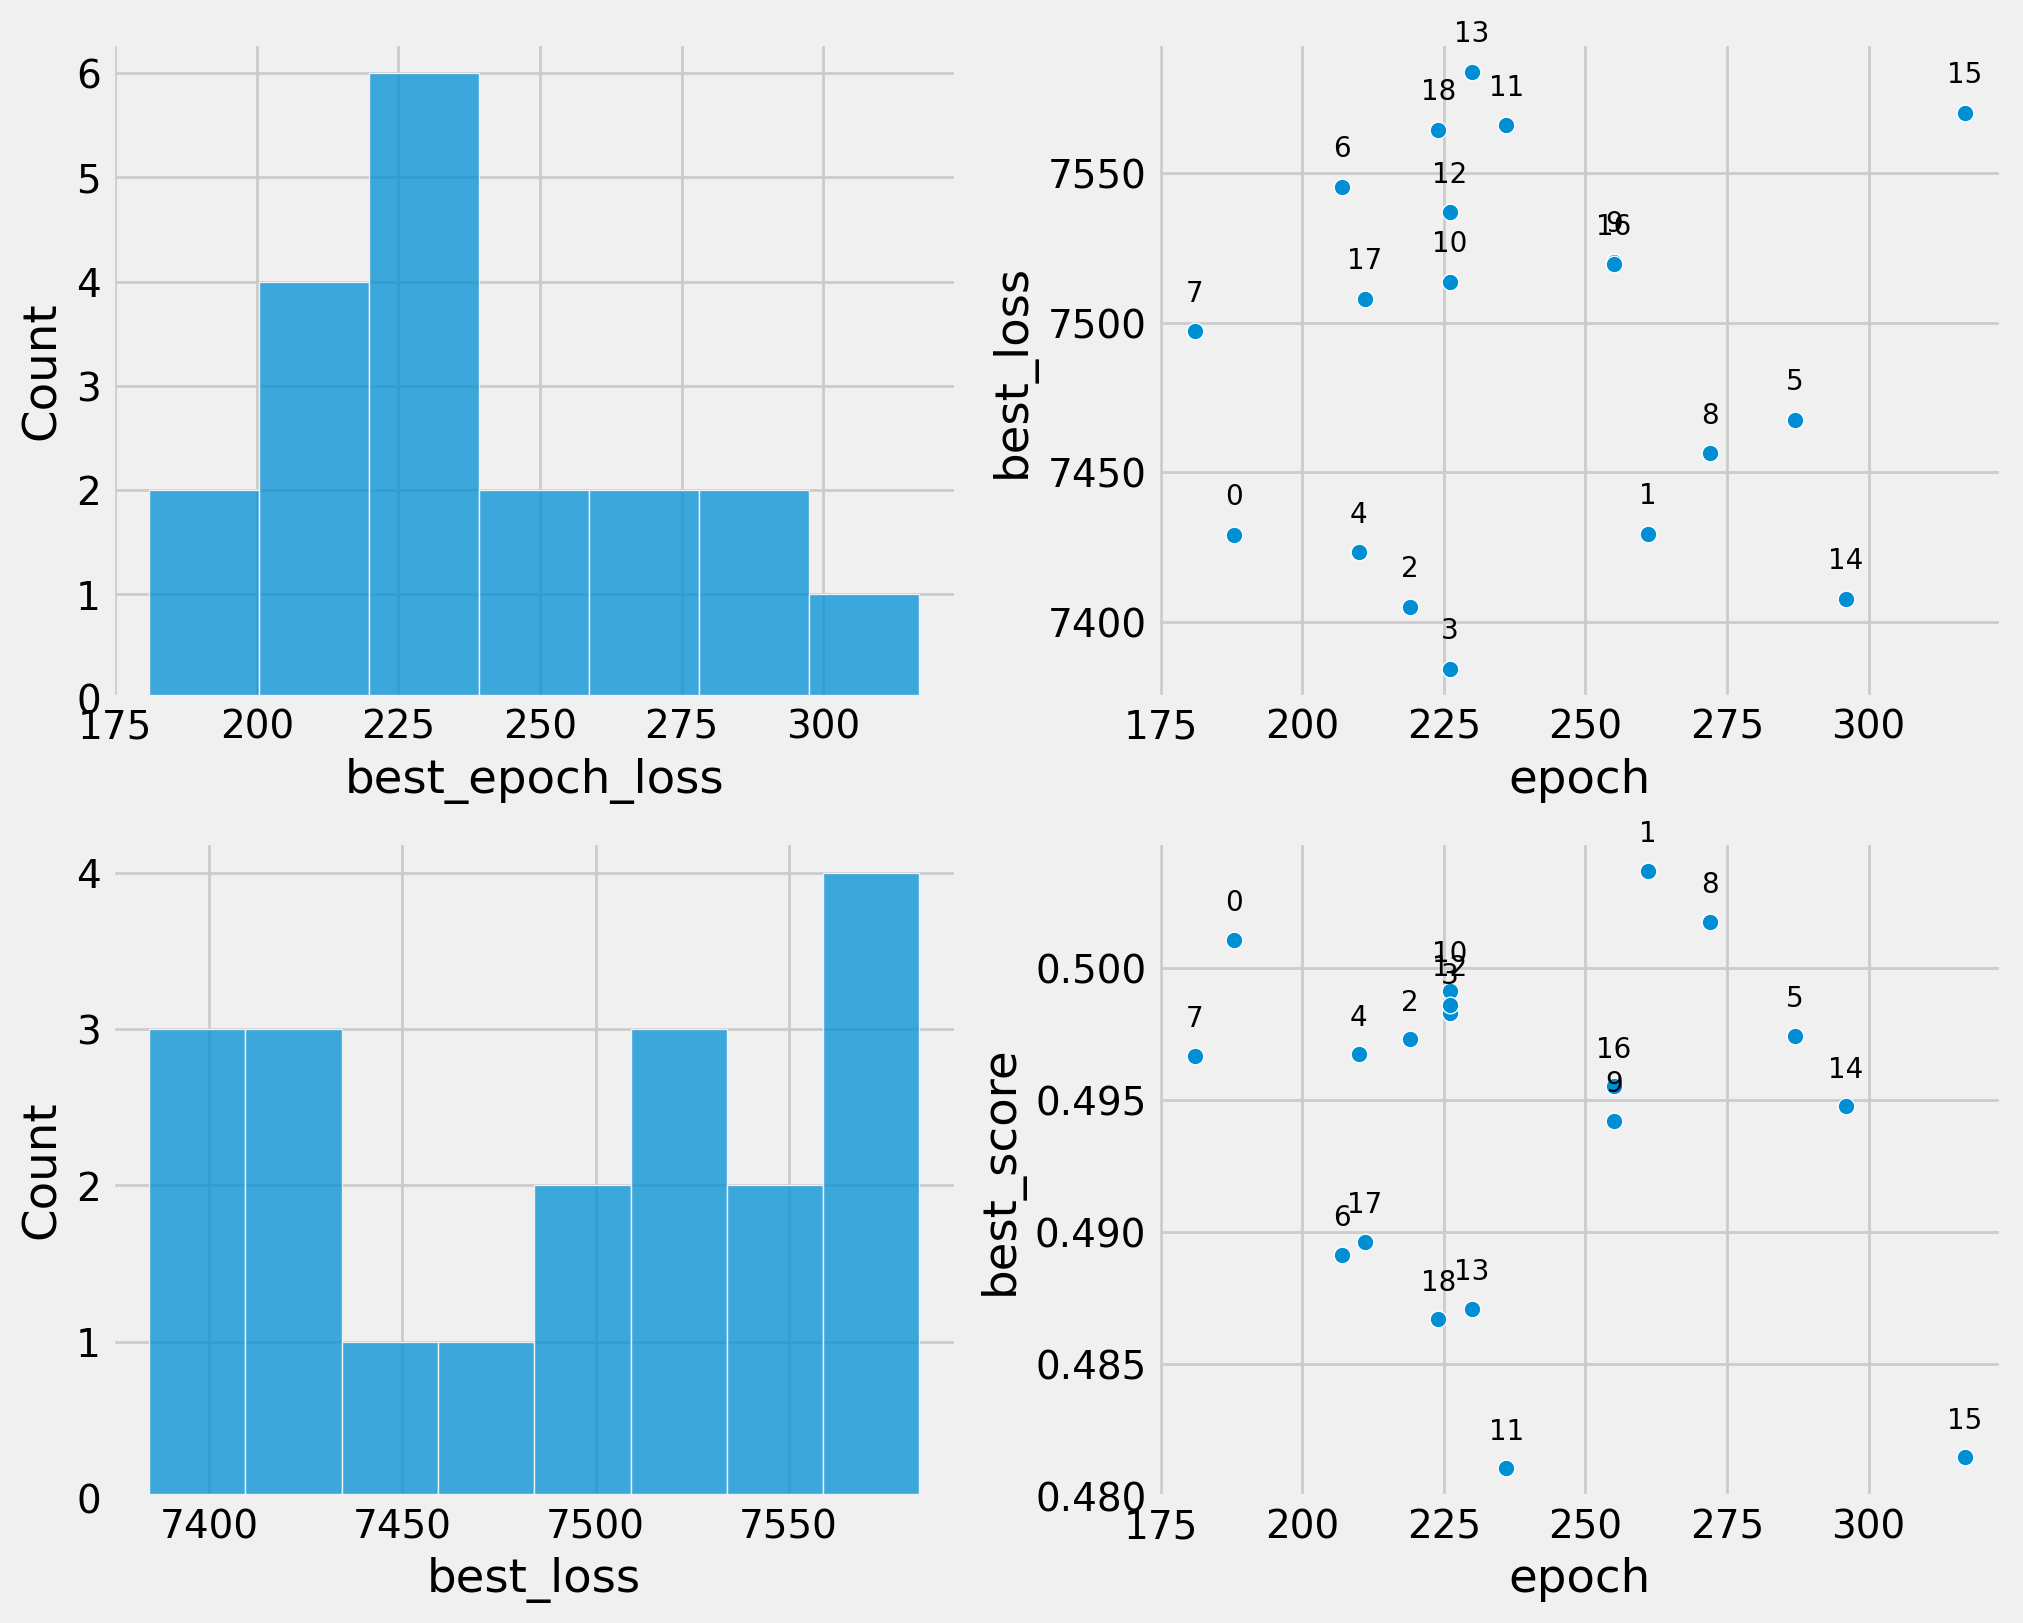

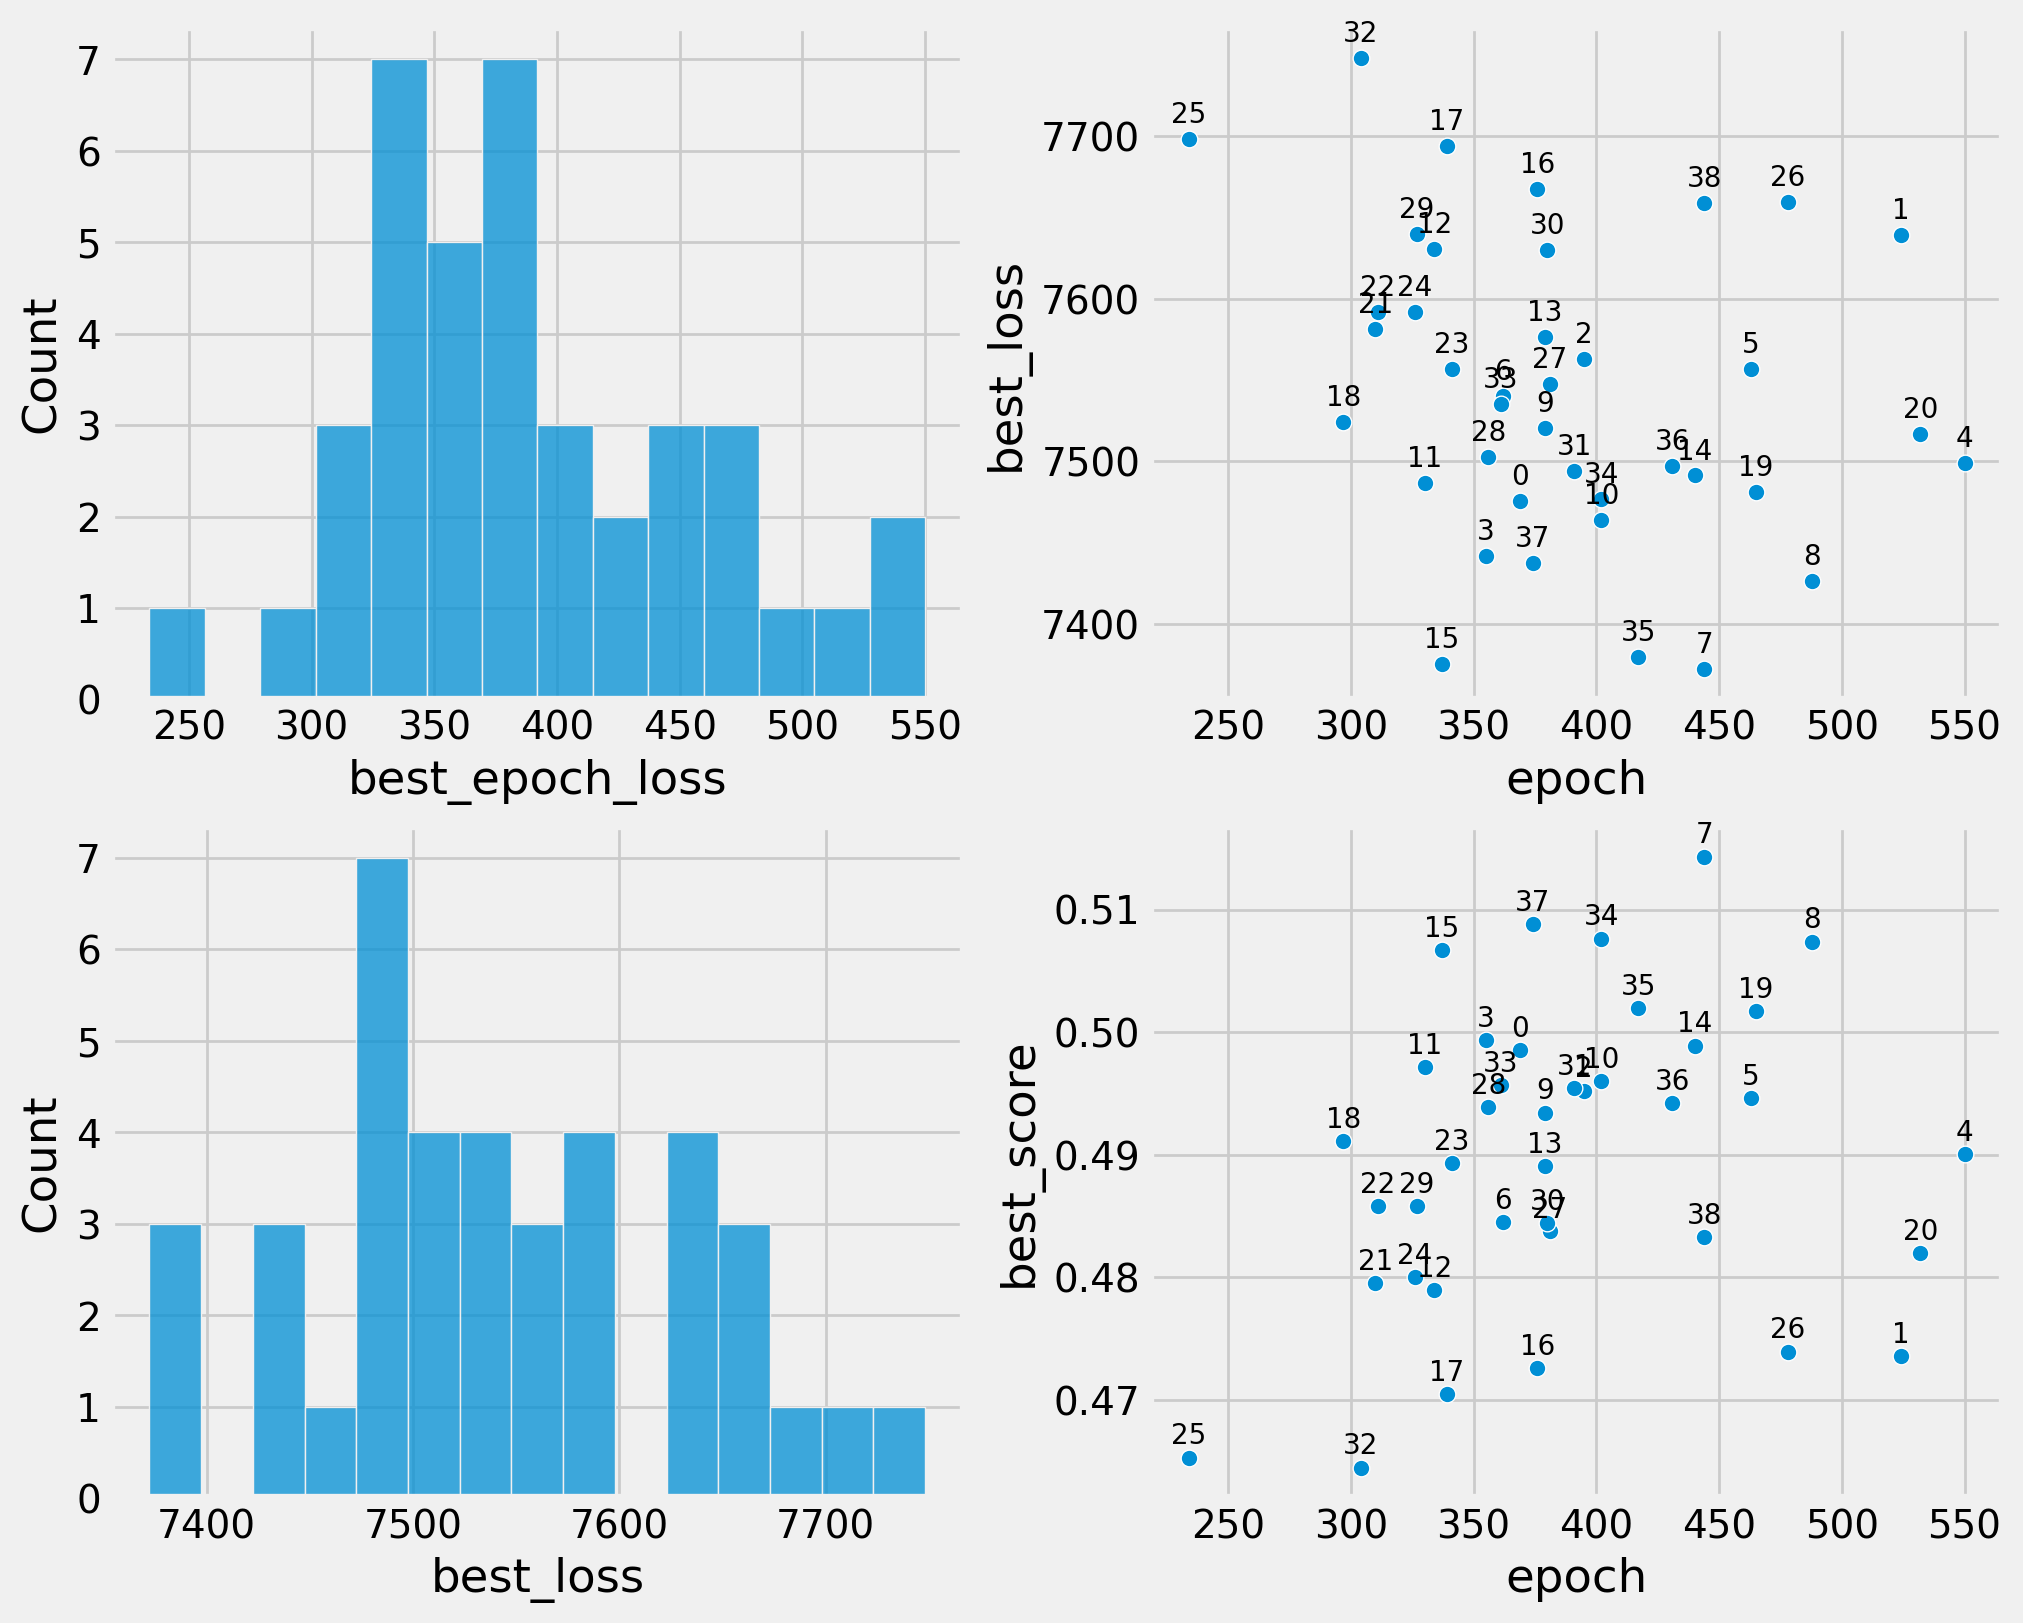

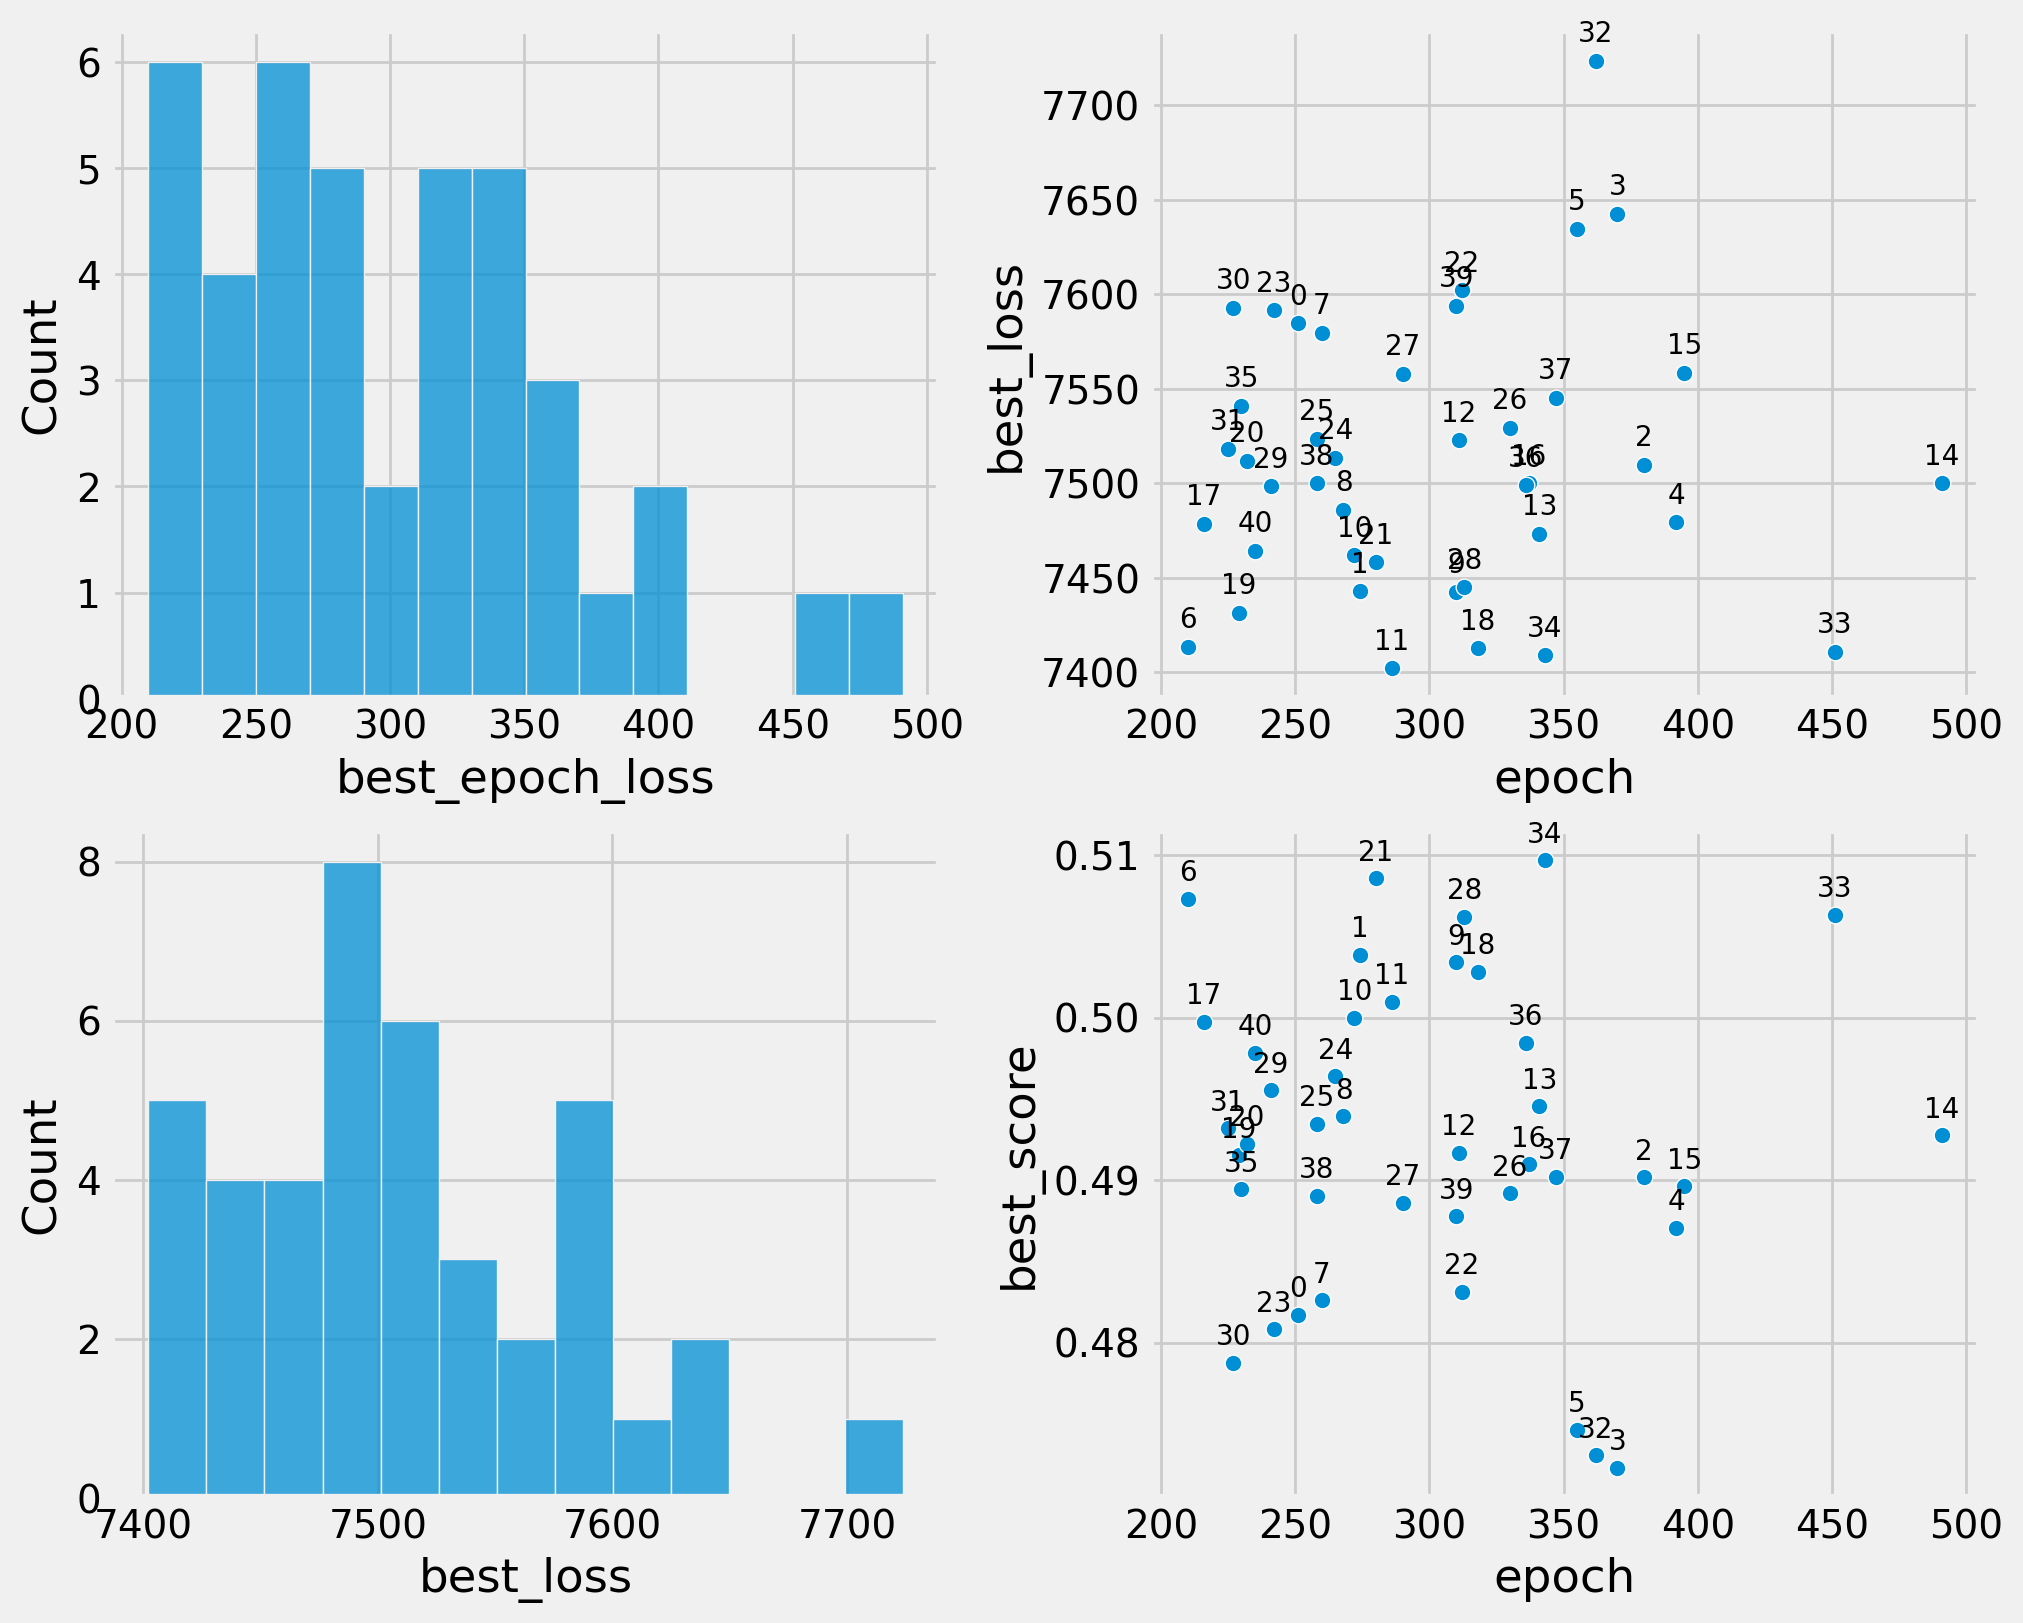

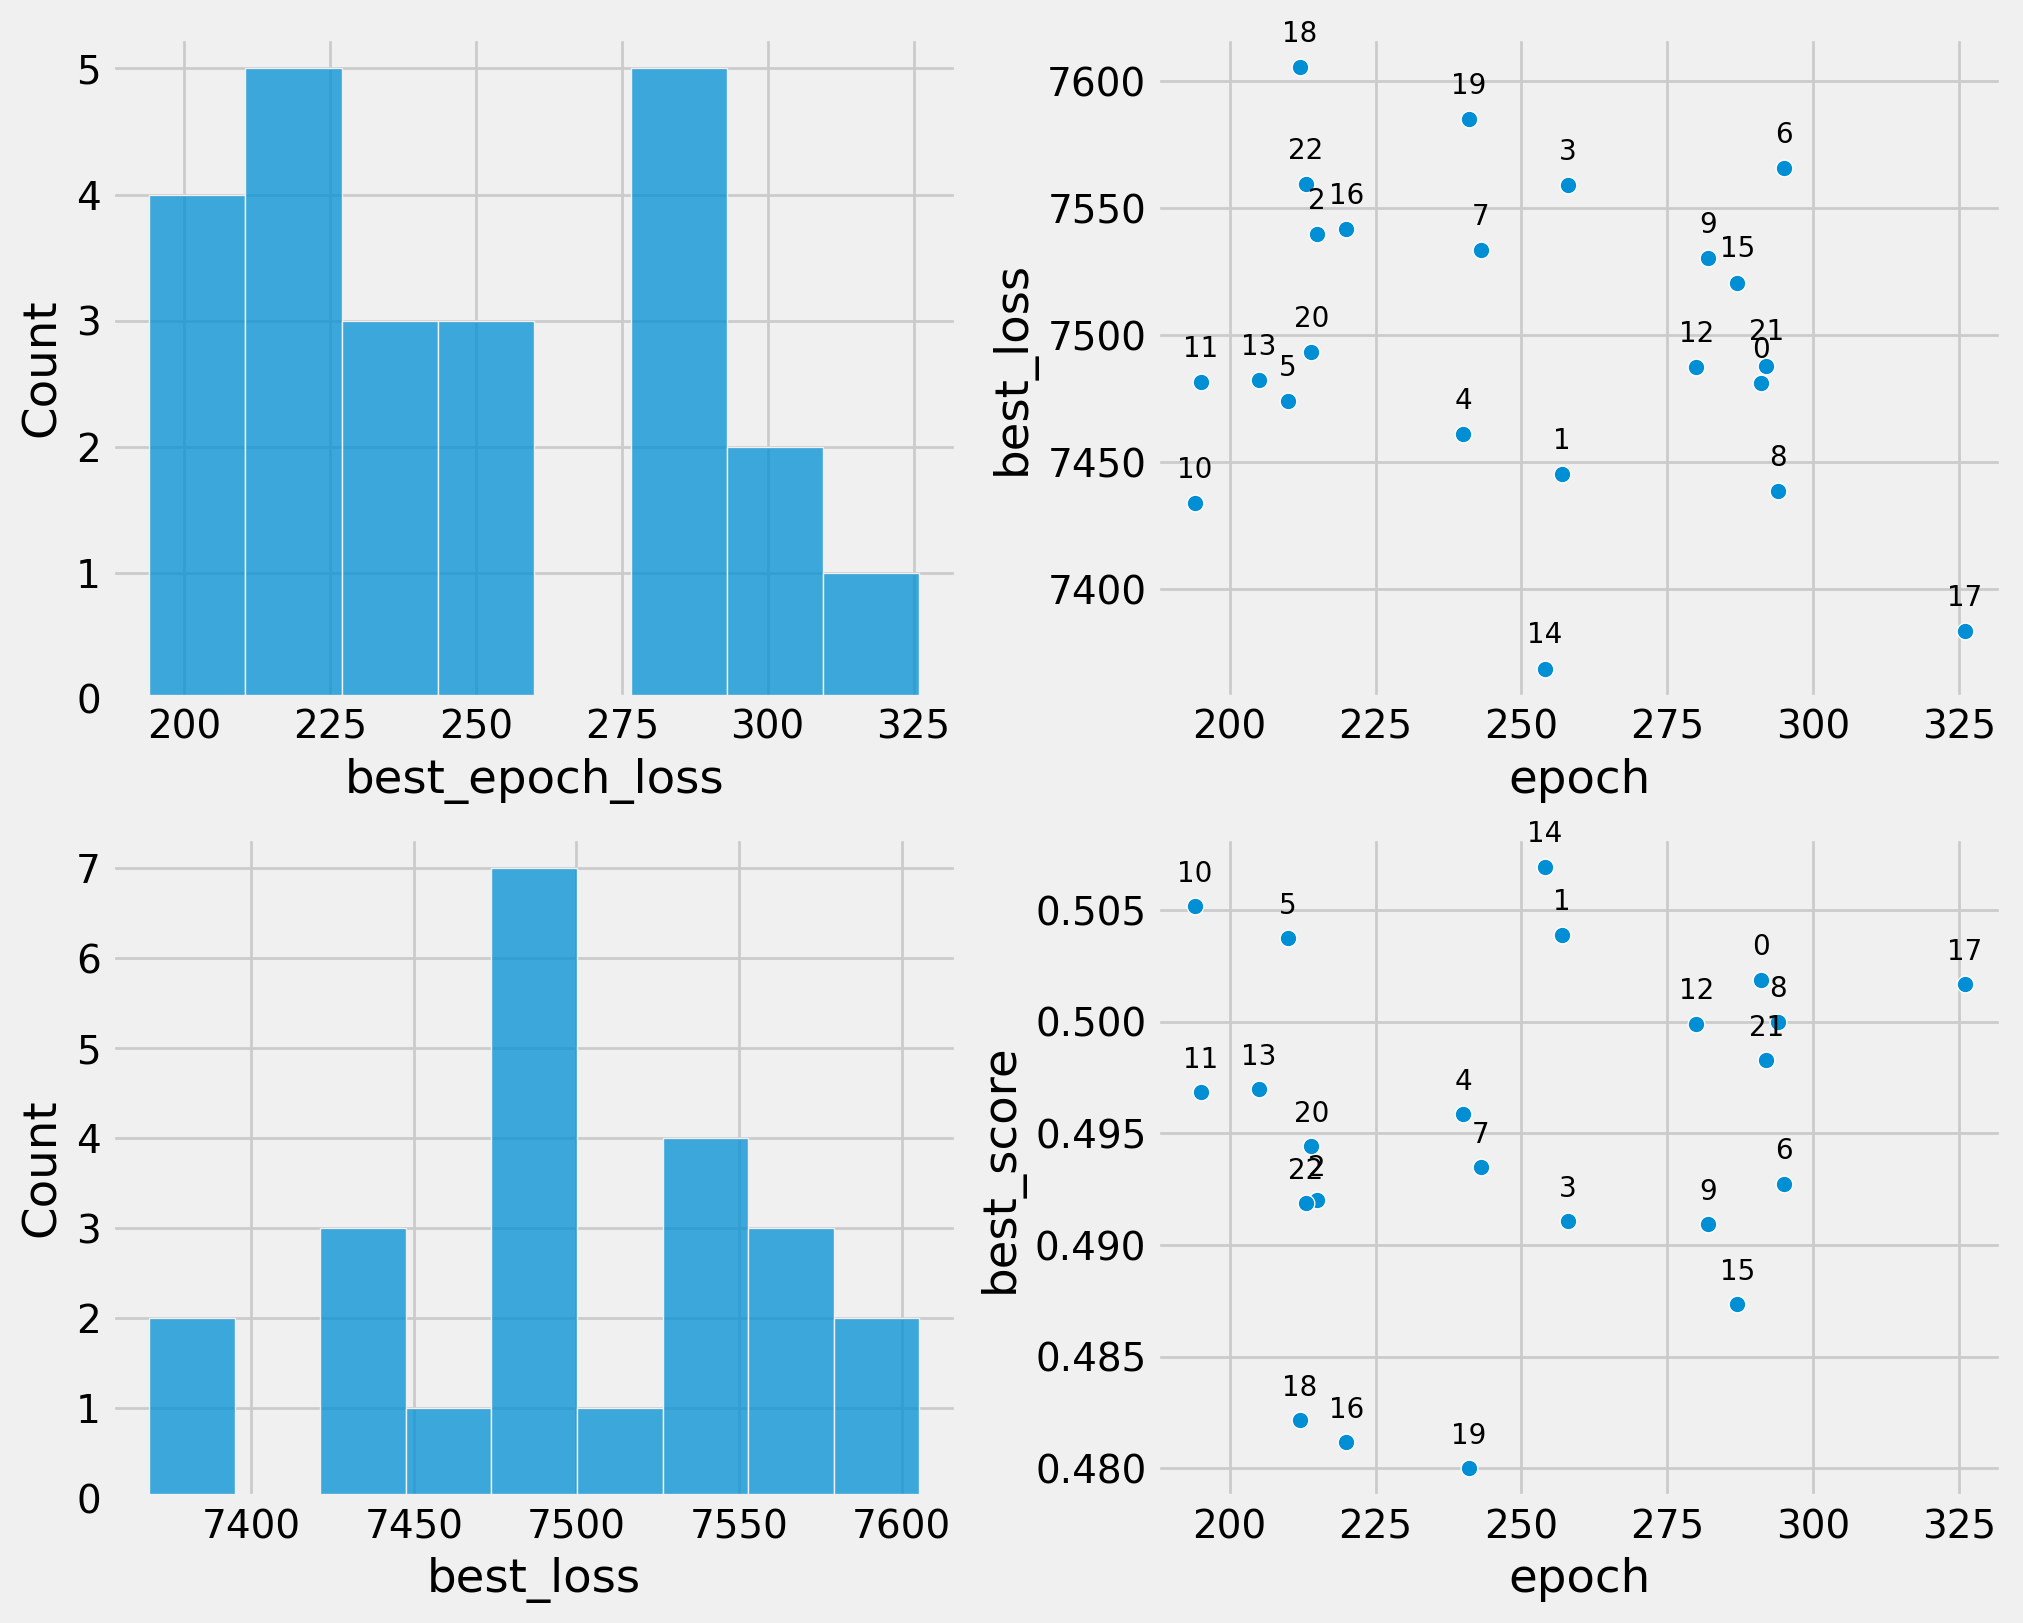

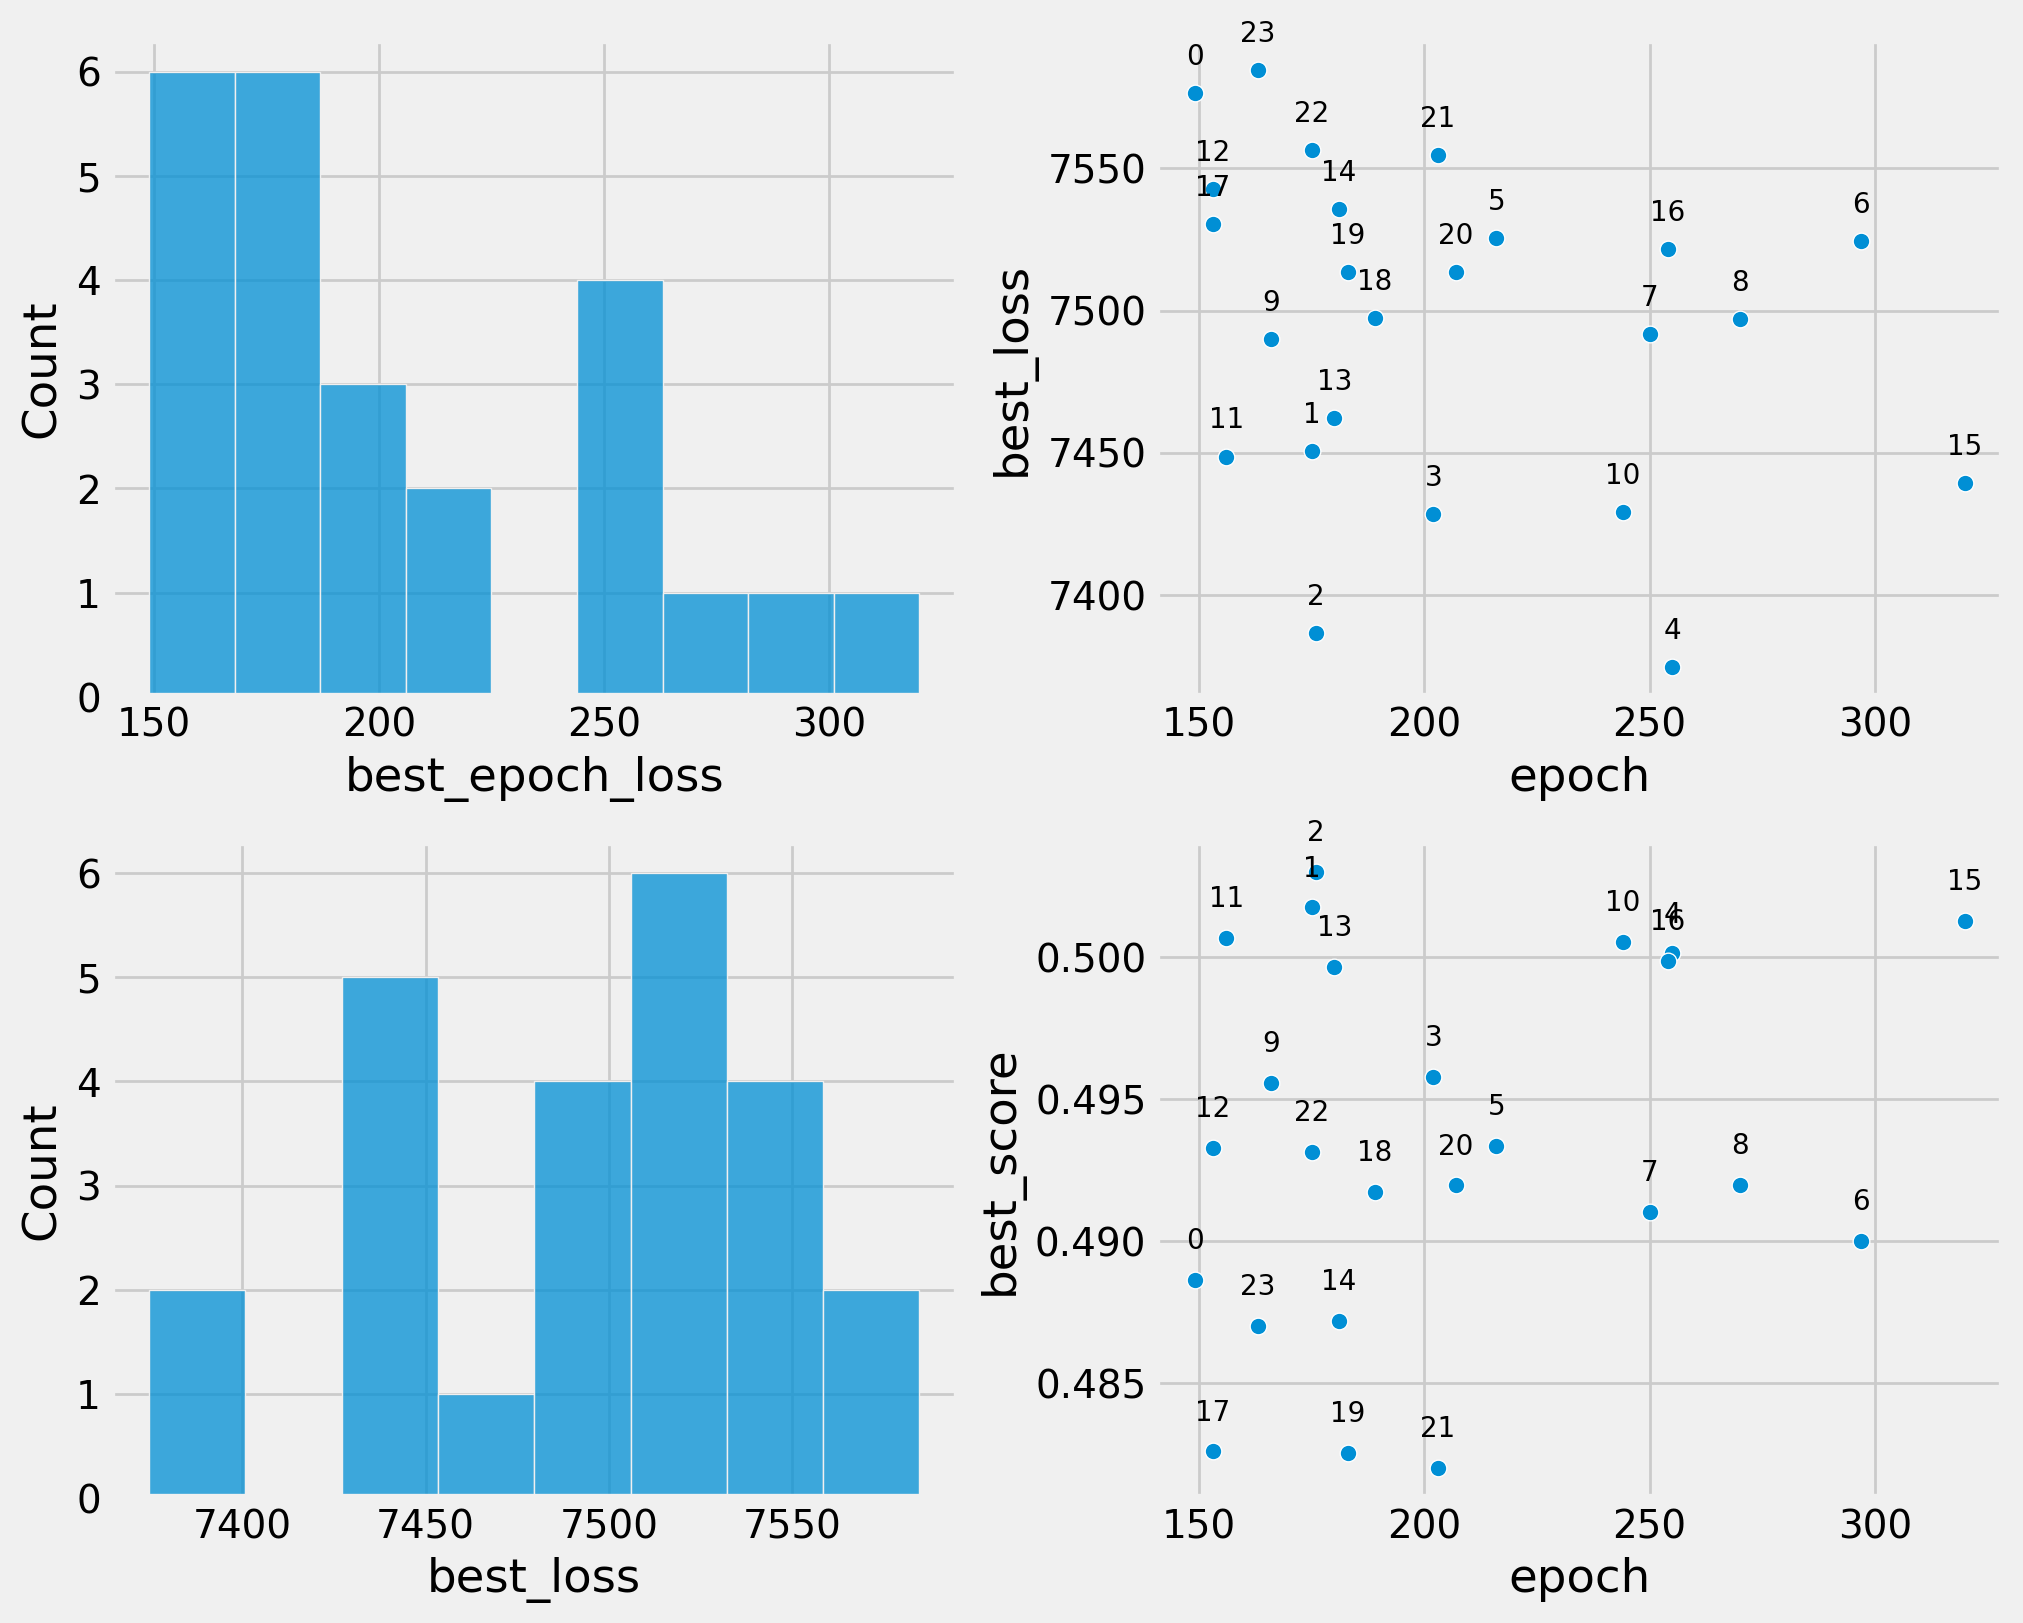

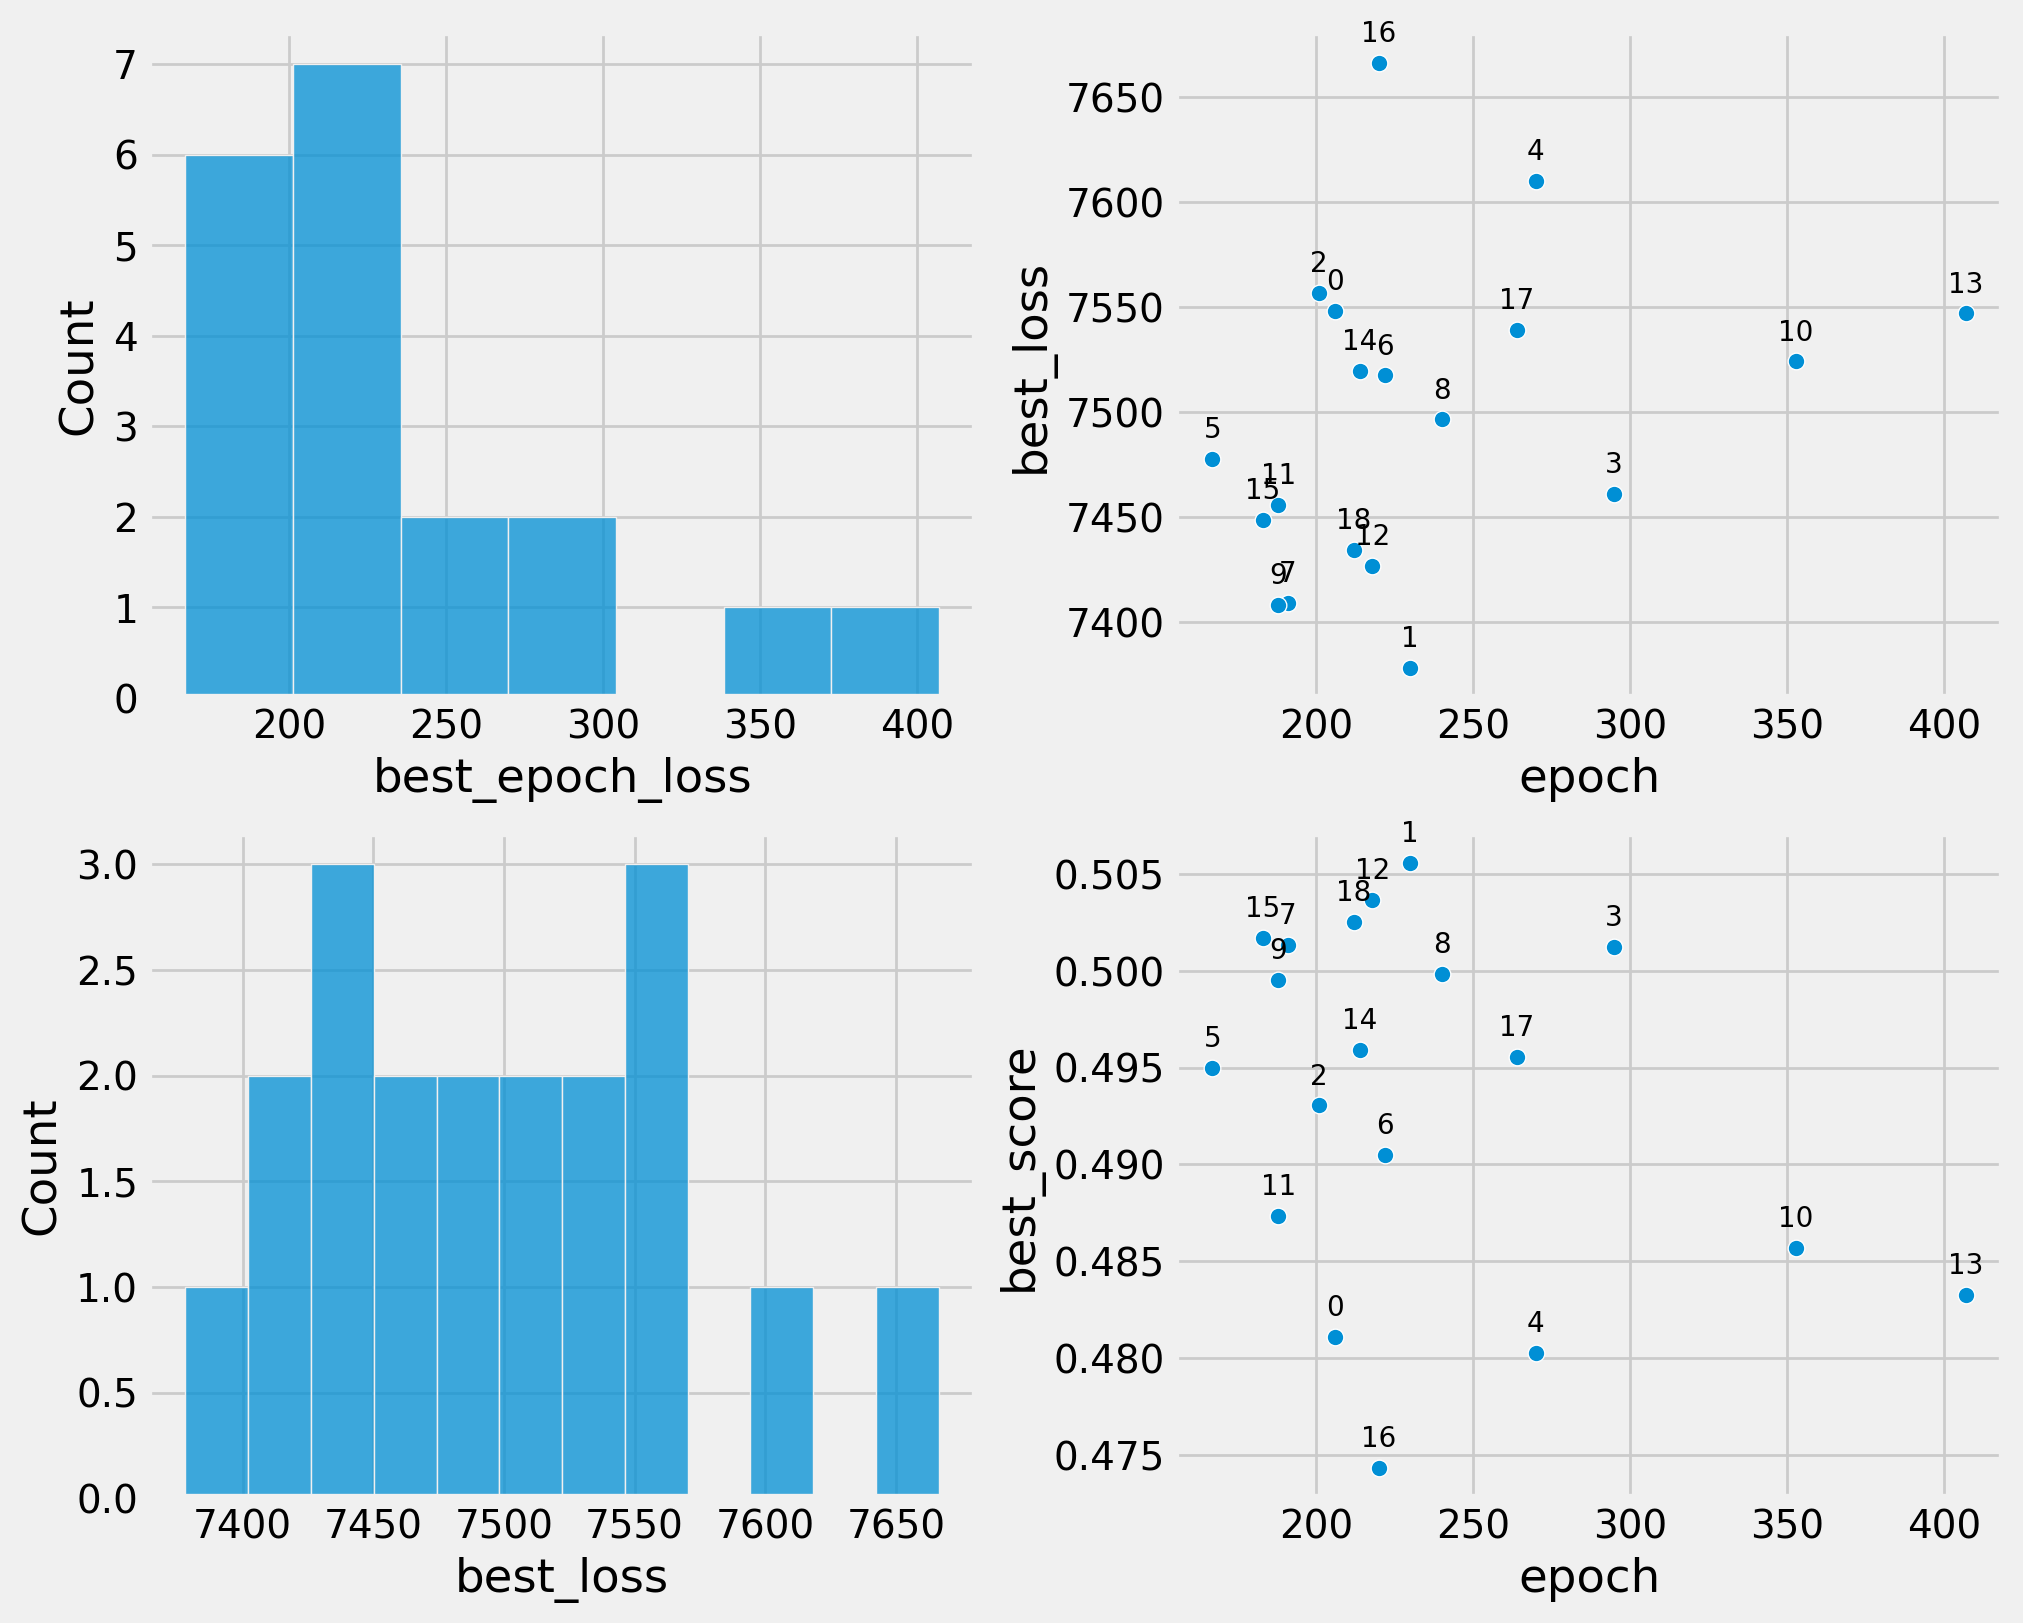

In [ ]:
for df_data in df_expt_list:
  plot_expt_data_rslt(df_data)

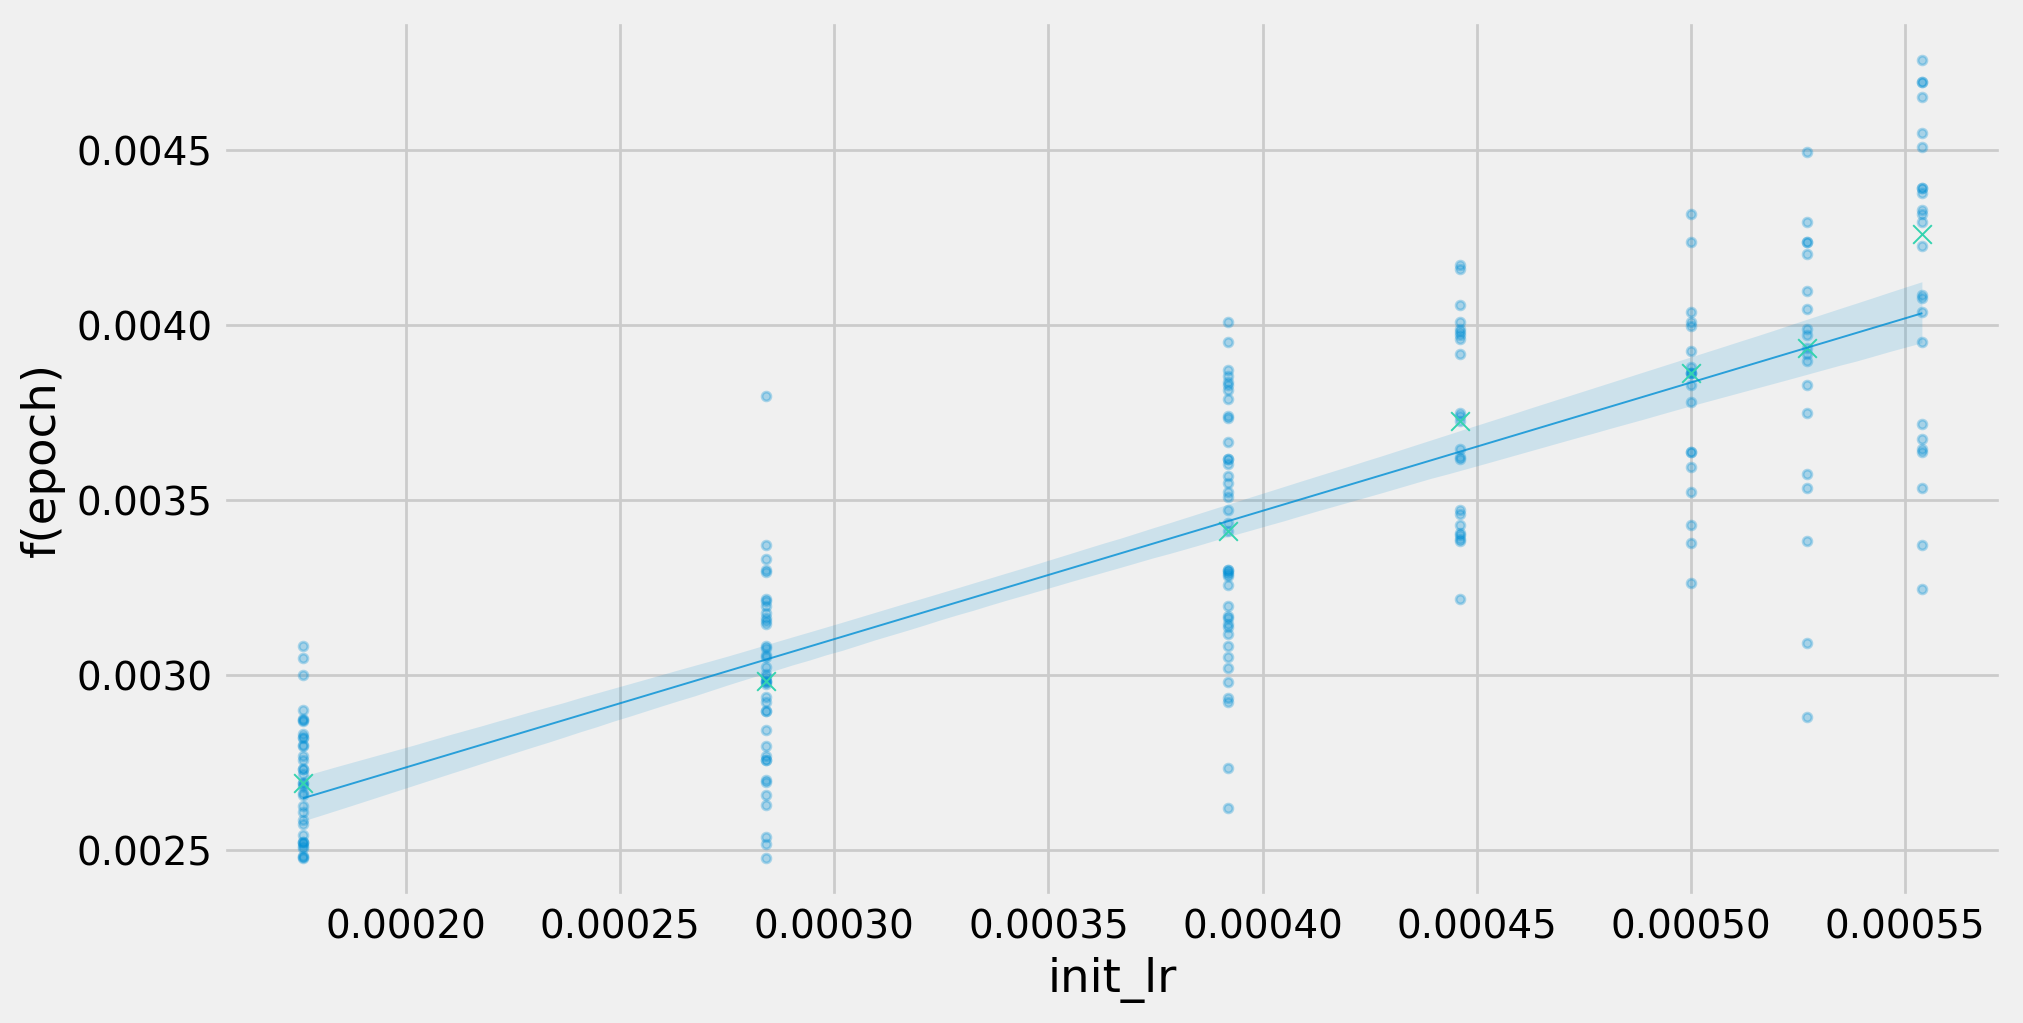

In [ ]:
df_whole = pd.concat(df_expt_list)
len(df_whole)
coeff = (len(data_dict['trn']['X'])/20480)*60
df_whole['f(epoch)'] = np.power(coeff * df_whole['epoch'],-0.5)

fig,ax = plt.subplots(figsize=(10,5))
#sns.scatterplot(data=df_whole,x='init_lr',y='f(epoch)',alpha=0.3,s=10,ax=ax)
sns.regplot(data=df_whole,x='init_lr',y='f(epoch)',scatter_kws={'alpha':0.3,'s':10},line_kws={'alpha':0.8,'lw':0.7},ax=ax);

ax.scatter(df_mode.lr.to_numpy(),np.power(df_mode[0].to_numpy()*coeff,-0.5),lw=0.7,marker='x',s=45,color='#34d3af')

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

X = df_whole['init_lr'].values.reshape(-1,1)
y = df_whole['f(epoch)'].values

reg = LinearRegression(fit_intercept=True)

reg.fit(X,y)

print(reg.score(X,y))

a,b = reg.coef_,reg.intercept_
r2_score(y,a*X+b), root_mean_squared_error(y,a*X+b)

0.6893303761863768


(0.6893303761863768, 0.00031773014088467514)

0.697397172871604 58.51748005524677


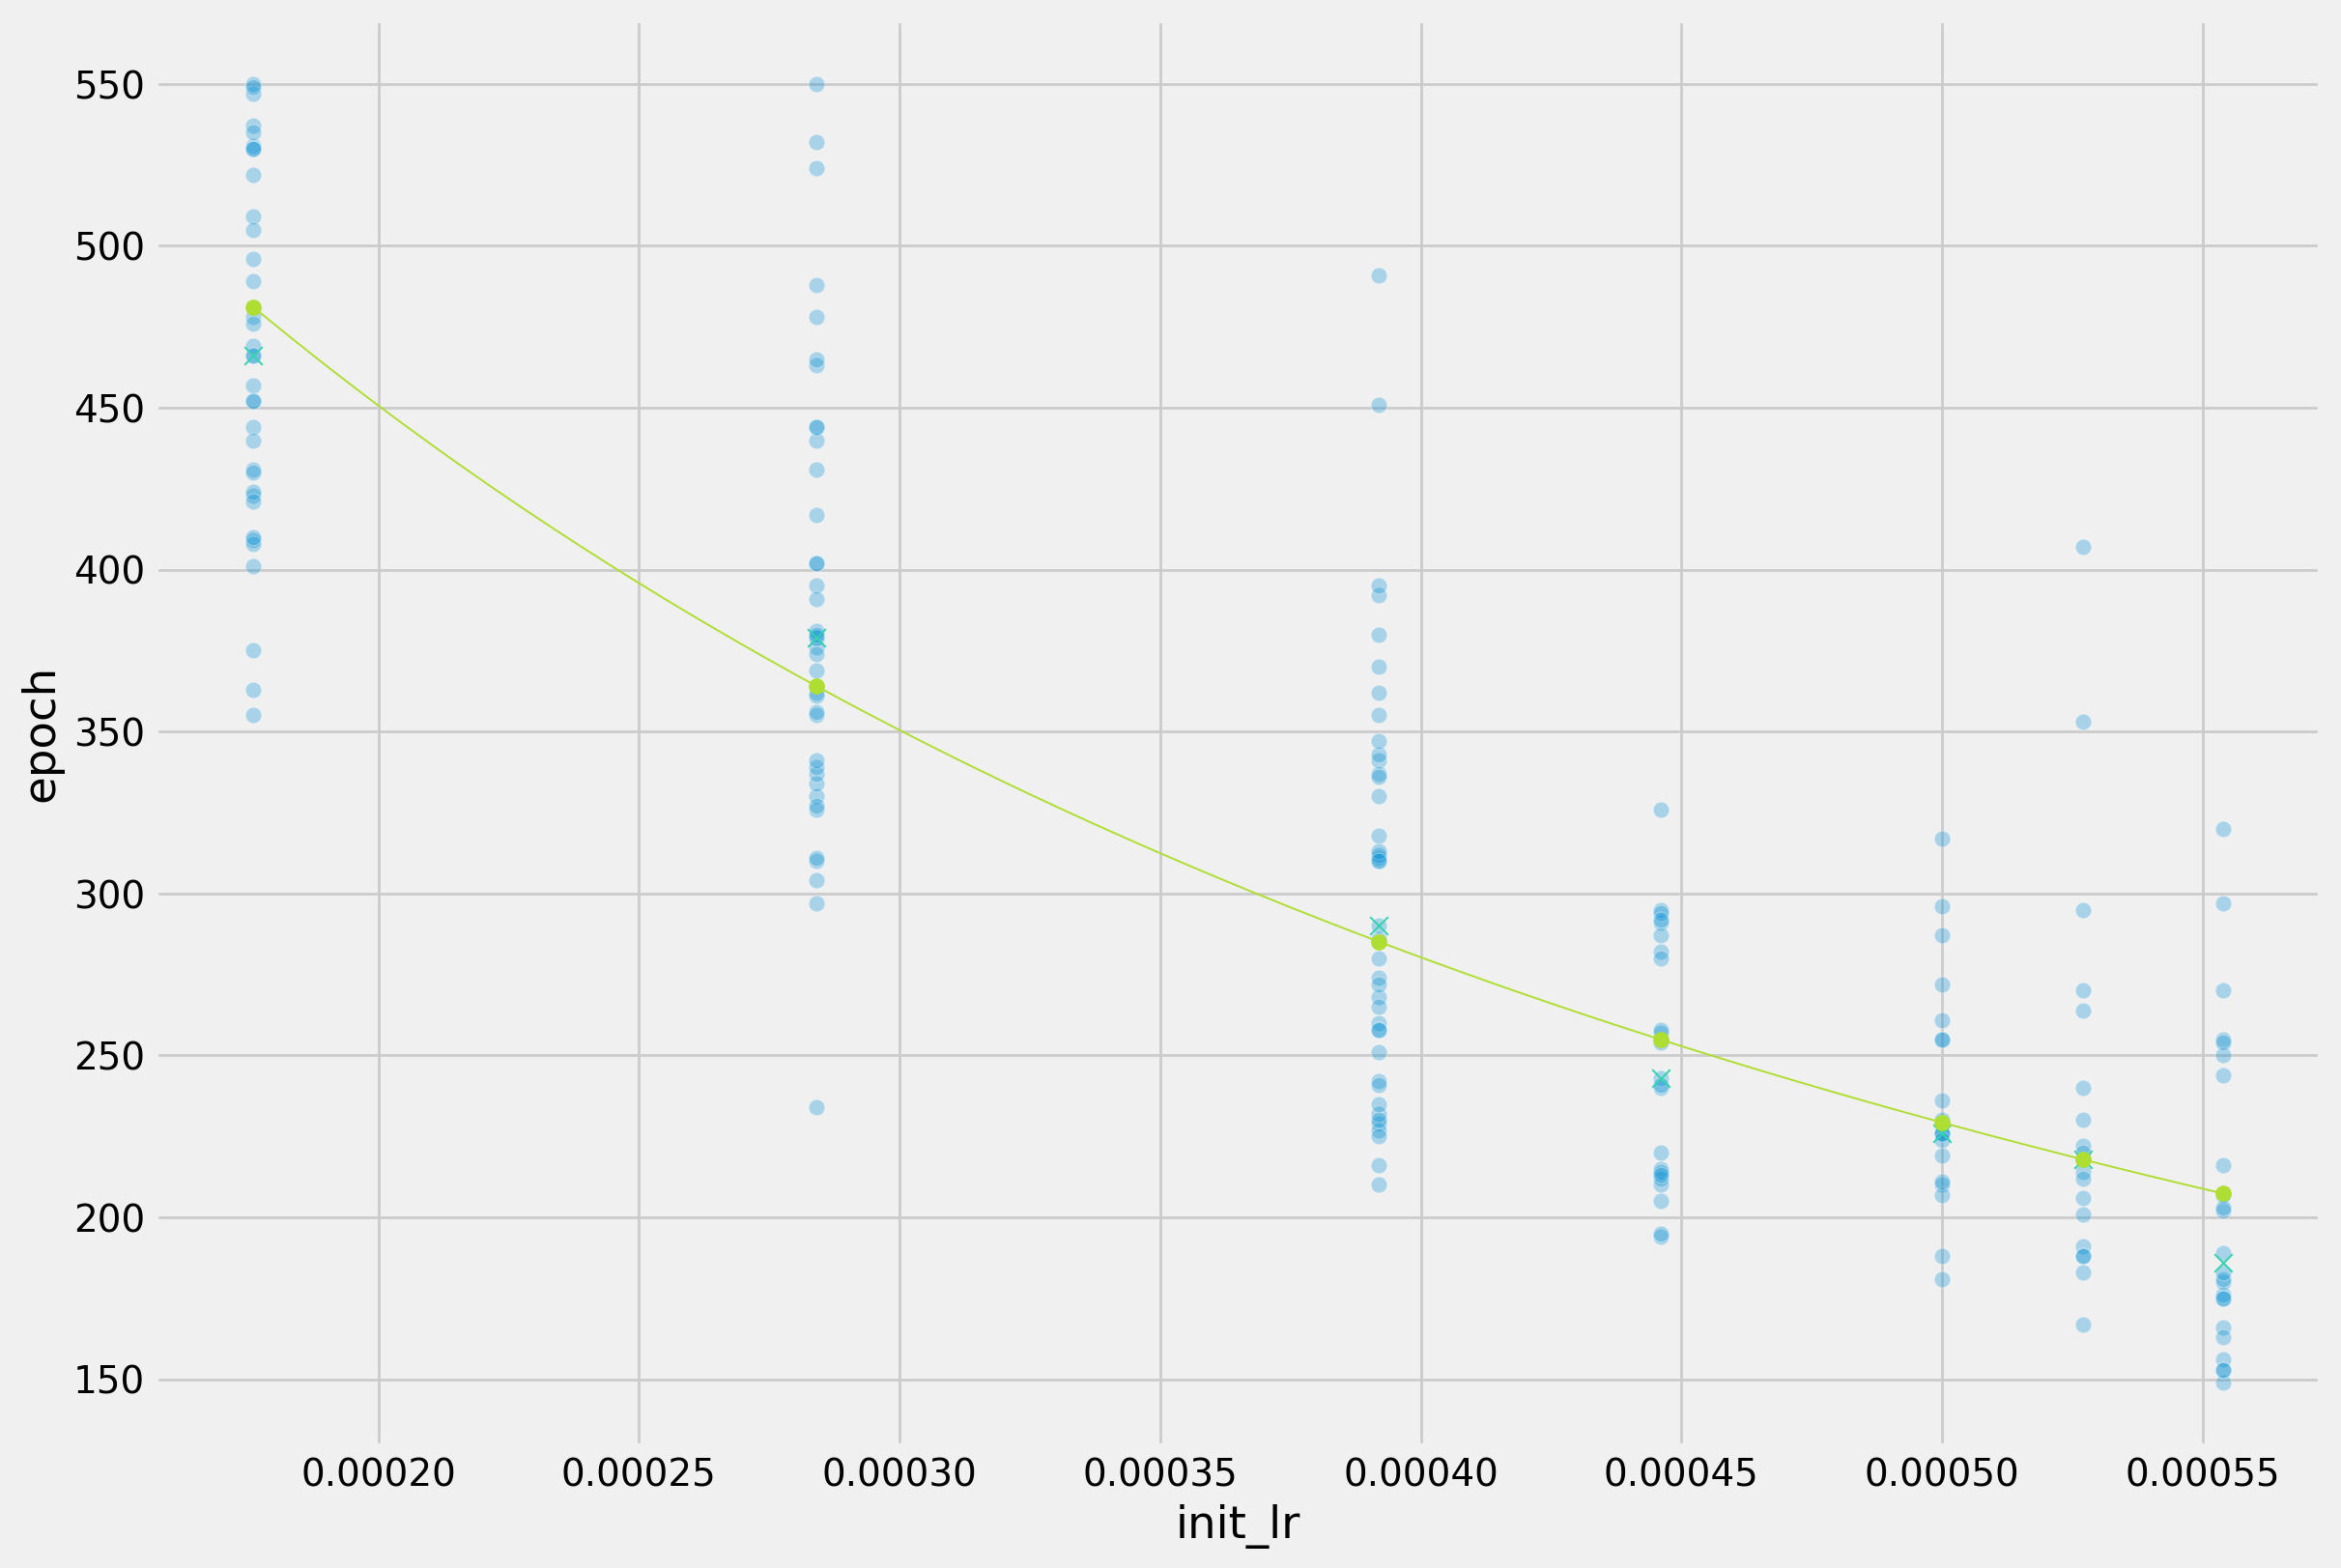

In [ ]:

epoch_r = lambda x : np.power(x*a+b,-2)/coeff
df_whole['epoch_r'] = epoch_r(df_whole['init_lr'].values)
print(r2_score(df_whole['epoch'],df_whole['epoch_r']), root_mean_squared_error(df_whole['epoch'],df_whole['epoch_r']))

fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot(data=df_whole,x='init_lr',y='epoch',alpha=0.3)

ind = df_whole['init_lr'].drop_duplicates(keep='first').sort_values().index
x_epochr = np.linspace(df_whole['init_lr'].min(),df_whole['init_lr'].max(),300)
ax.plot(x_epochr,epoch_r(x_epochr),color='#afde32',lw=0.7)
ax.plot(df_whole.loc[ind,'init_lr'],df_whole.loc[ind,'epoch_r'],color='#afde32',lw=0,marker='o',markersize=5)

ax.scatter(df_mode.lr.to_numpy(),df_mode[0].to_numpy(),lw=0.7,marker='x',s=45,color='#34d3af')

In [ ]:
lens = np.round(df_whole['init_lr'].value_counts()/10,0)*10
lens = lens.astype(int)

display(df_whole['init_lr'].value_counts())
display(lens)
lcm_len = np.lcm.reduce(lens)
print(lcm_len)
weights =lcm_len//lens
display(weights)

init_lr
0.000392    41
0.000284    39
0.000176    35
0.000554    24
0.000446    23
0.000500    19
0.000527    19
Name: count, dtype: int64

init_lr
0.000392    40
0.000284    40
0.000176    40
0.000554    20
0.000446    20
0.000500    20
0.000527    20
Name: count, dtype: int64

40


init_lr
0.000392    1
0.000284    1
0.000176    1
0.000554    2
0.000446    2
0.000500    2
0.000527    2
Name: count, dtype: int64

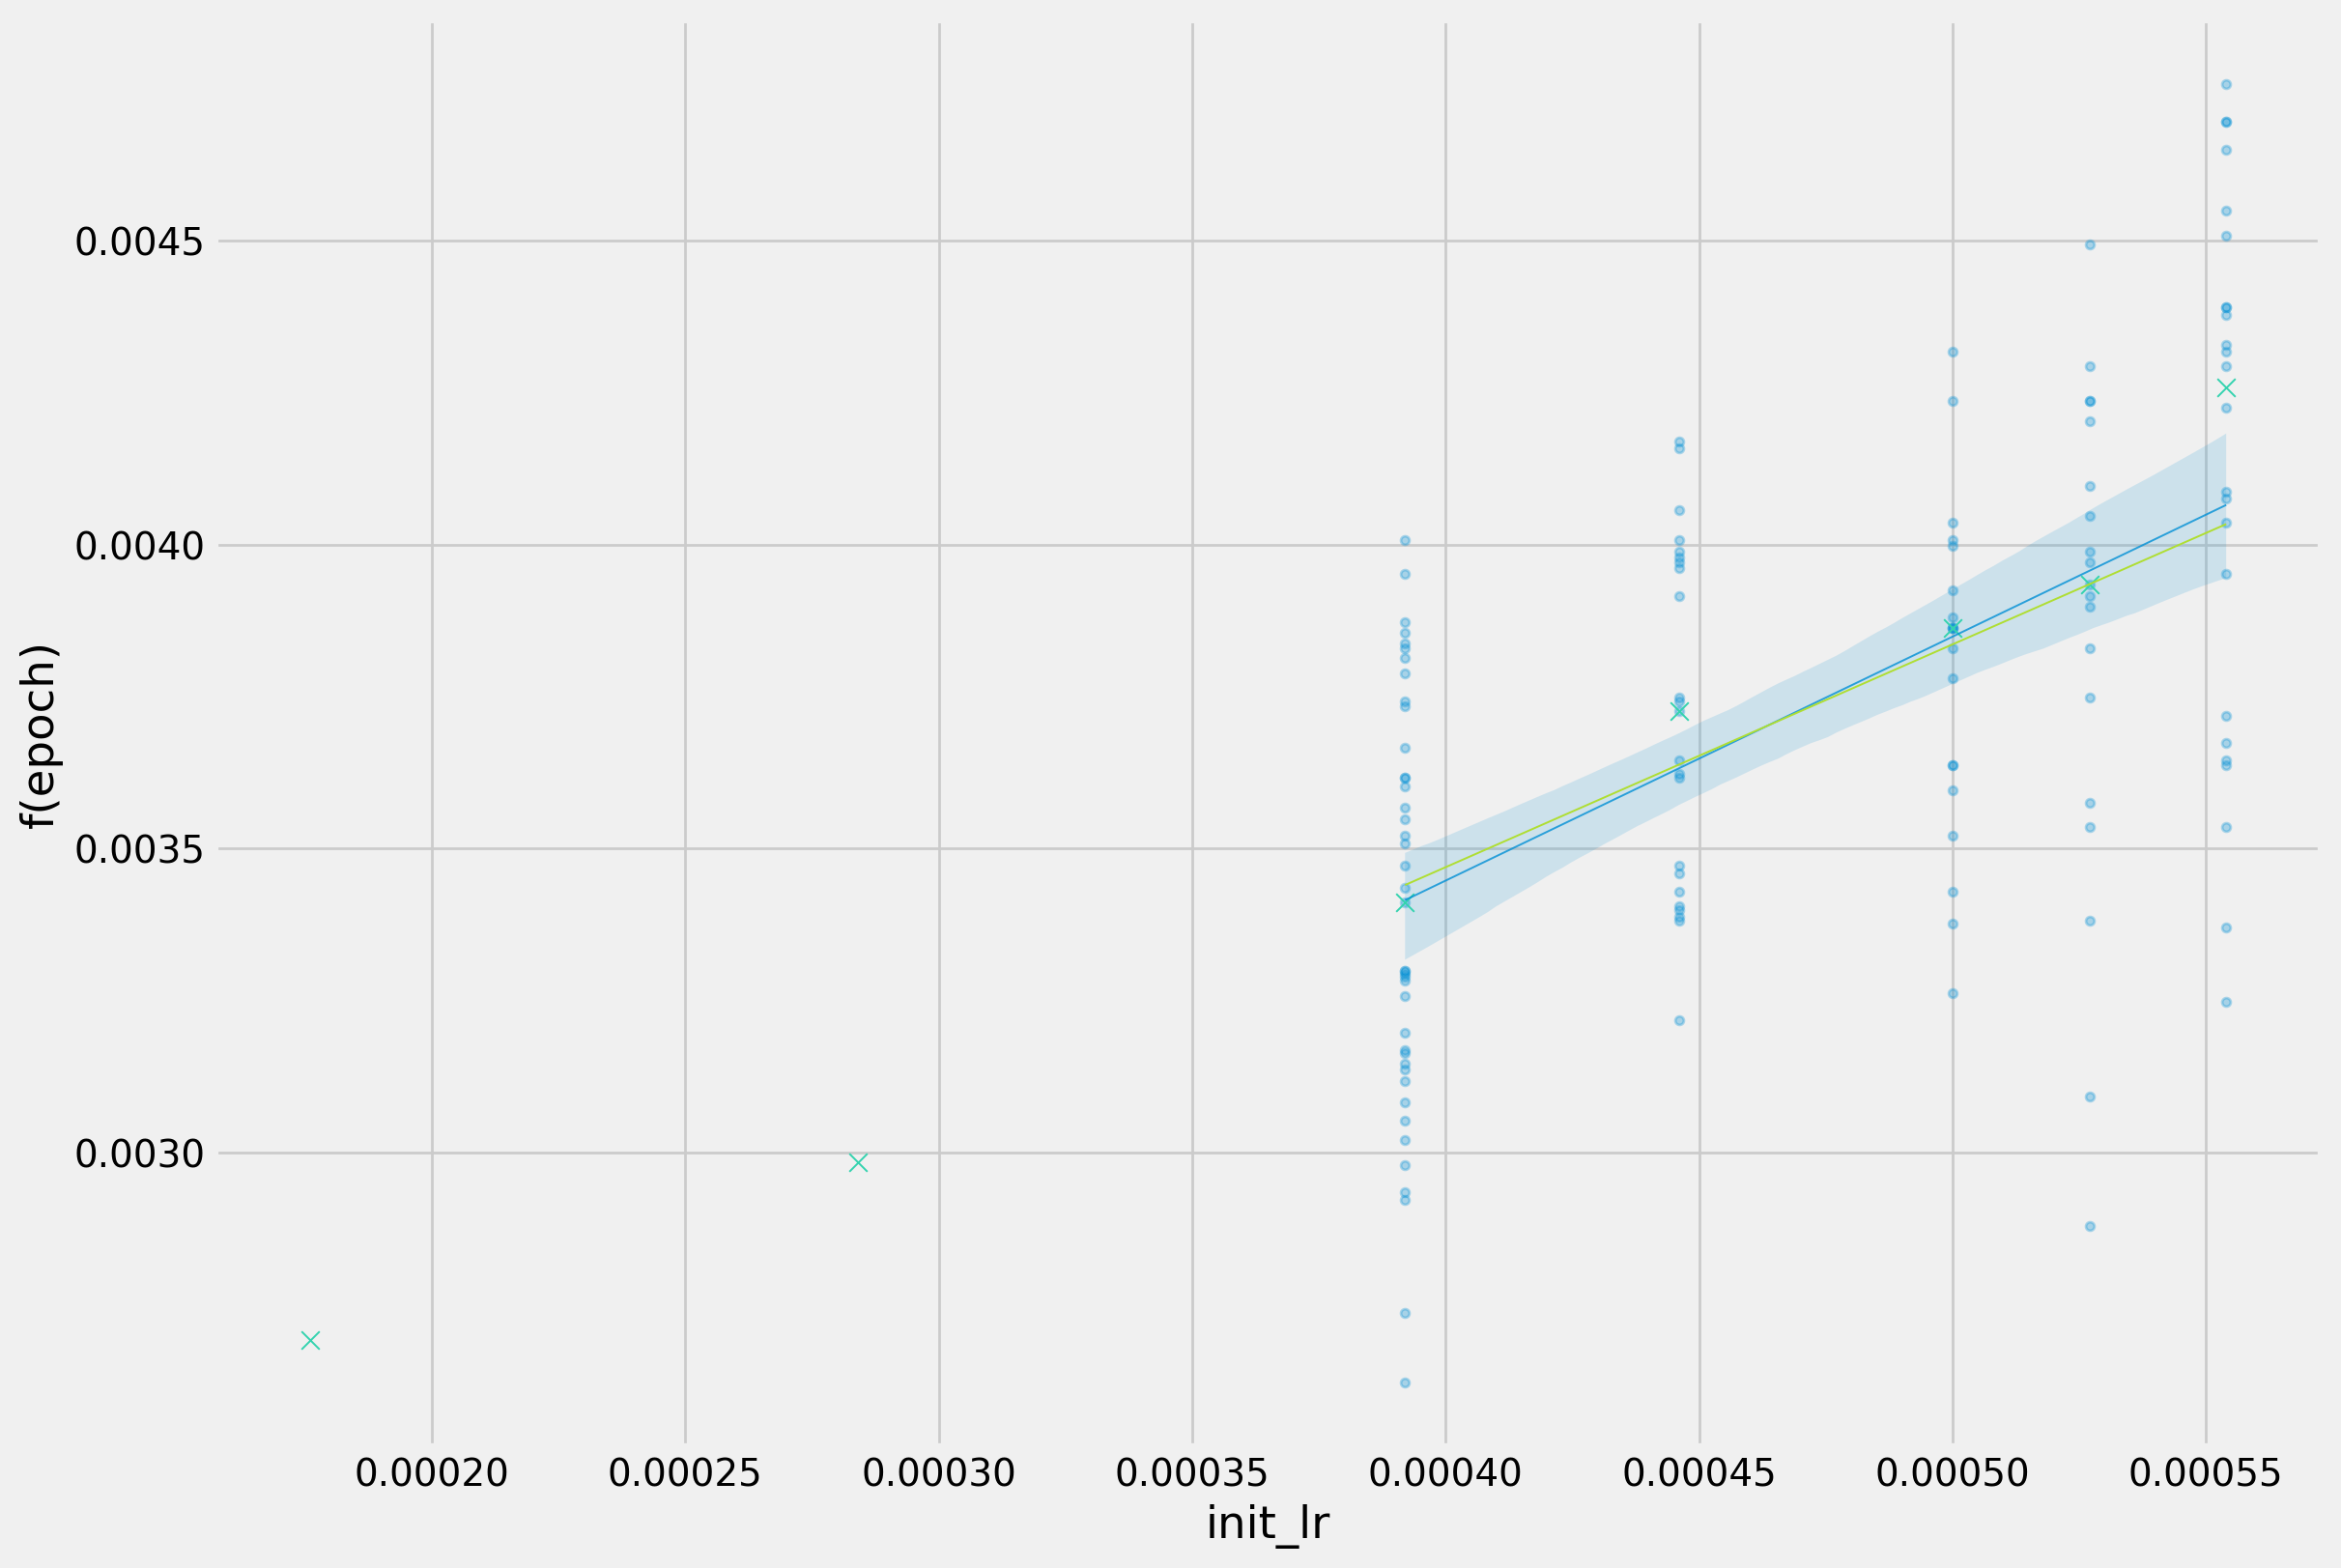

In [ ]:
df_part = pd.concat(df_expt_list[3:]+df_expt_list[1:2])
len(df_part)
coeff = (len(data_dict['trn']['X'])/20480)*60
df_part['f(epoch)'] = np.power(coeff * df_part['epoch'],-0.5)

fig,ax = plt.subplots(figsize=(12,8))
#sns.scatterplot(data=df_whole,x='init_lr',y='f(epoch)',alpha=0.3,s=10,ax=ax)
sns.regplot(data=df_part,x='init_lr',y='f(epoch)',scatter_kws={'alpha':0.3,'s':10},line_kws={'alpha':0.8,'lw':0.7},ax=ax);

x_epochr = np.linspace(df_part['init_lr'].min(),df_part['init_lr'].max(),300)
ax.plot(x_epochr,(x_epochr*a+b),color='#afde32',lw=0.7)

ax.scatter(df_mode.lr.to_numpy(),np.power(df_mode[0].to_numpy()*coeff,-0.5),lw=0.7,marker='x',s=45,color='#34d3af')

In [ ]:
weight_ind = lambda x : weights[lr_dict[f'20480_2.{x}']]
temp = list()
for  i in range(len(df_expt_list)):
  temp.extend([df_expt_list[i] for _ in range(weight_ind(i))])
df_mod = pd.concat(temp)
len(df_mod)

285

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

coeff = (len(data_dict['trn']['X'])/20480)*60
df_mod['f(epoch)'] = np.power(coeff * df_mod['epoch'],-0.5)
X = df_mod['init_lr'].values.reshape(-1,1)
y = df_mod['f(epoch)'].values

reg = LinearRegression(fit_intercept=True)

reg.fit(X,y)

print(reg.score(X,y))

a_mod,b_mod = reg.coef_,reg.intercept_
r2_score(y,a_mod*X+b_mod), root_mean_squared_error(y,a_mod*X+b_mod)

0.6566469039469718


(0.6566469039469718, 0.00033273678941941957)

In [ ]:
print(a,a_mod)
print(b,b_mod)

[3.6666908] [3.69985834]
0.0020026727365978986 0.001995454033436905


0.695781548771391 58.67348718063884


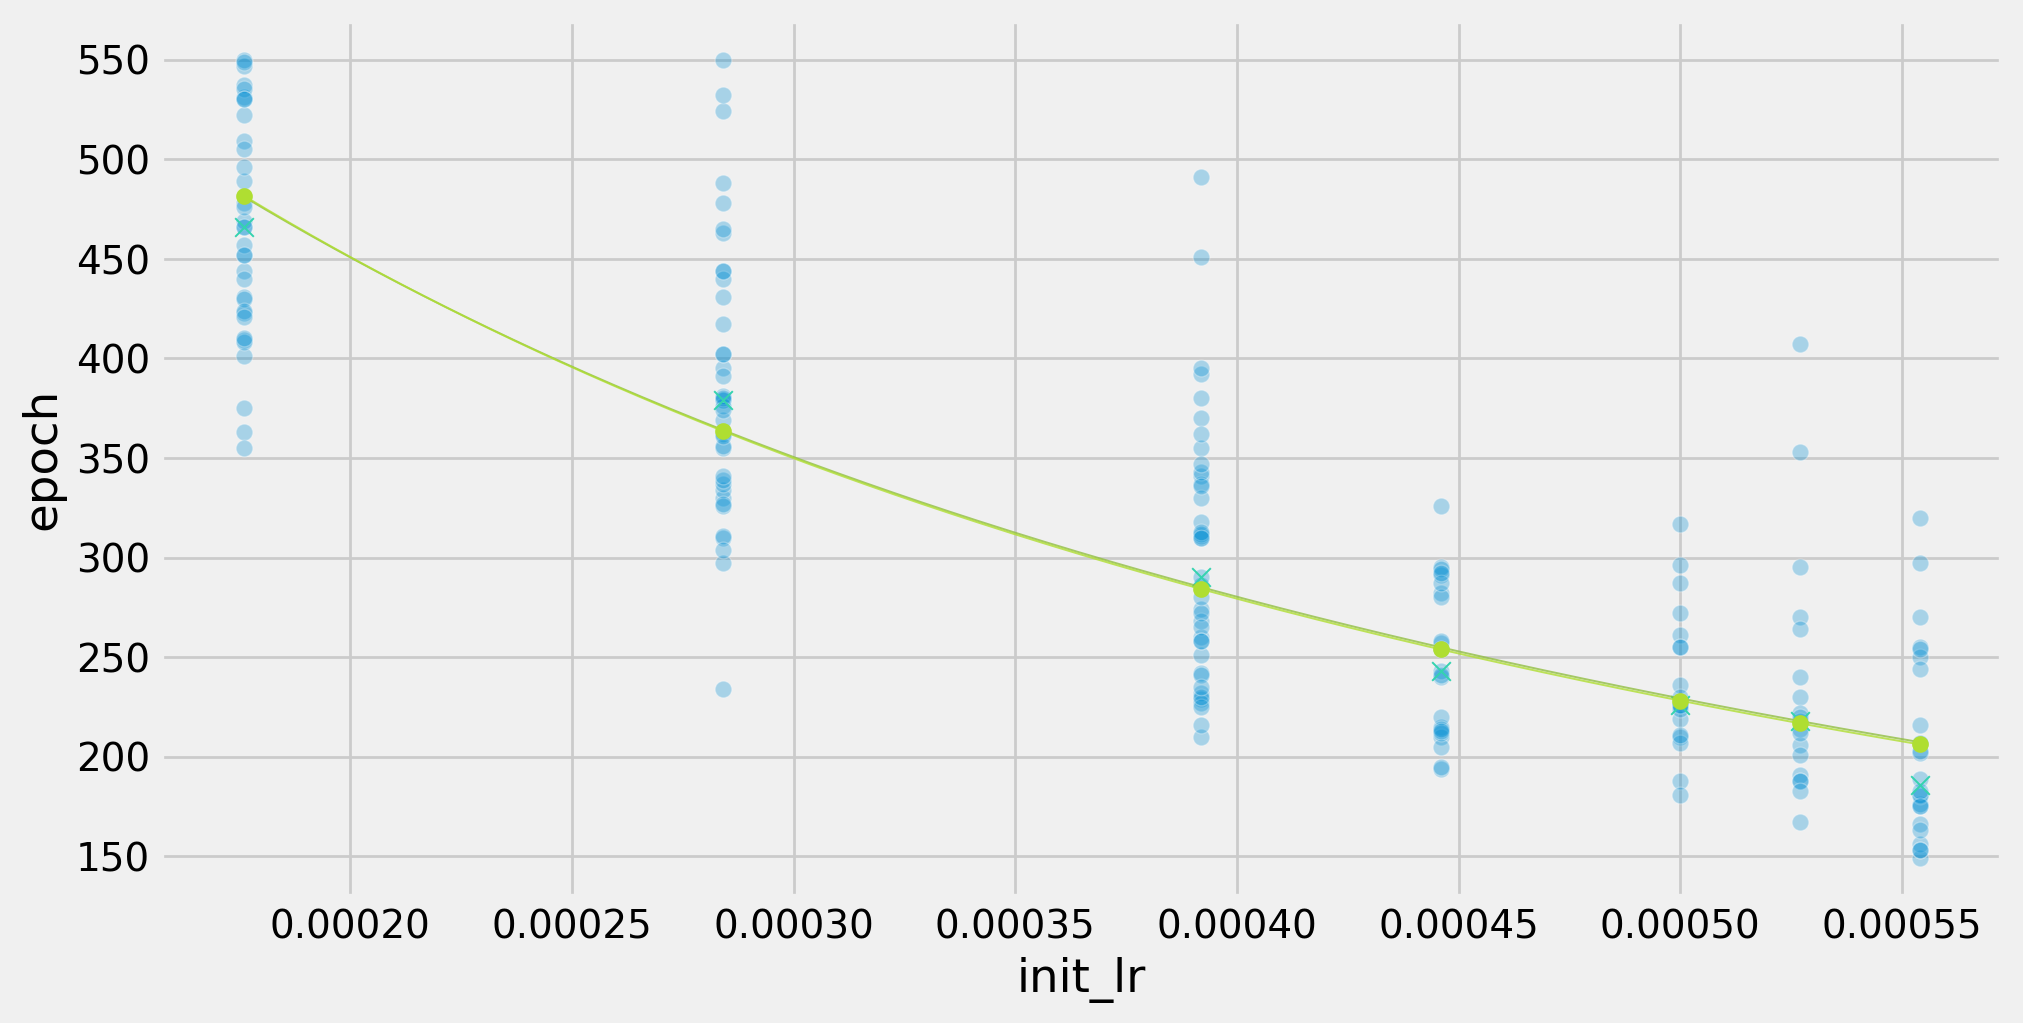

In [ ]:
epoch_r_mod = lambda x : np.power(x*a_mod+b_mod,-2)/coeff
df_whole['epoch_r_mod'] = epoch_r_mod(df_whole['init_lr'].values)
print(r2_score(df_whole['epoch'],df_whole['epoch_r_mod']), root_mean_squared_error(df_whole['epoch'],df_whole['epoch_r_mod']))

fig,ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=df_whole,x='init_lr',y='epoch',alpha=0.3)

ind = df_whole['init_lr'].drop_duplicates(keep='first').sort_values().index
x_epochr = np.linspace(df_whole['init_lr'].min(),df_whole['init_lr'].max(),300)
ax.plot(x_epochr,epoch_r(x_epochr),color='#91be42',lw=0.7,alpha=0.8)
ax.plot(x_epochr,epoch_r_mod(x_epochr),color='#afde32',lw=0.7,alpha=0.8)
ax.plot(df_whole.loc[ind,'init_lr'],df_whole.loc[ind,'epoch_r_mod'],color='#afde32',lw=0,marker='o',markersize=5)

ax.scatter(df_mode.lr.to_numpy(),df_mode[0].to_numpy(),lw=0.7,marker='x',s=45,color='#34d3af')

In [ ]:
display(df_whole[['init_lr','epoch_r_mod','epoch_r']].value_counts().sort_index())
display(df_mode)

init_lr   epoch_r_mod  epoch_r   
0.000176  481.645944   481.143616    35
0.000284  363.574413   364.100344    39
0.000392  284.141271   285.097407    41
0.000446  253.850616   254.908704    23
0.000500  228.157539   229.272924    19
0.000527  216.749722   217.881548    19
0.000554  206.176578   207.318520    24
Name: count, dtype: int64

lr      0
0  0.000176  466.0
2  0.000284  379.0
3  0.000392  290.0
4  0.000446  243.0
1  0.000500  226.0
6  0.000527  218.0
5  0.000554  186.0

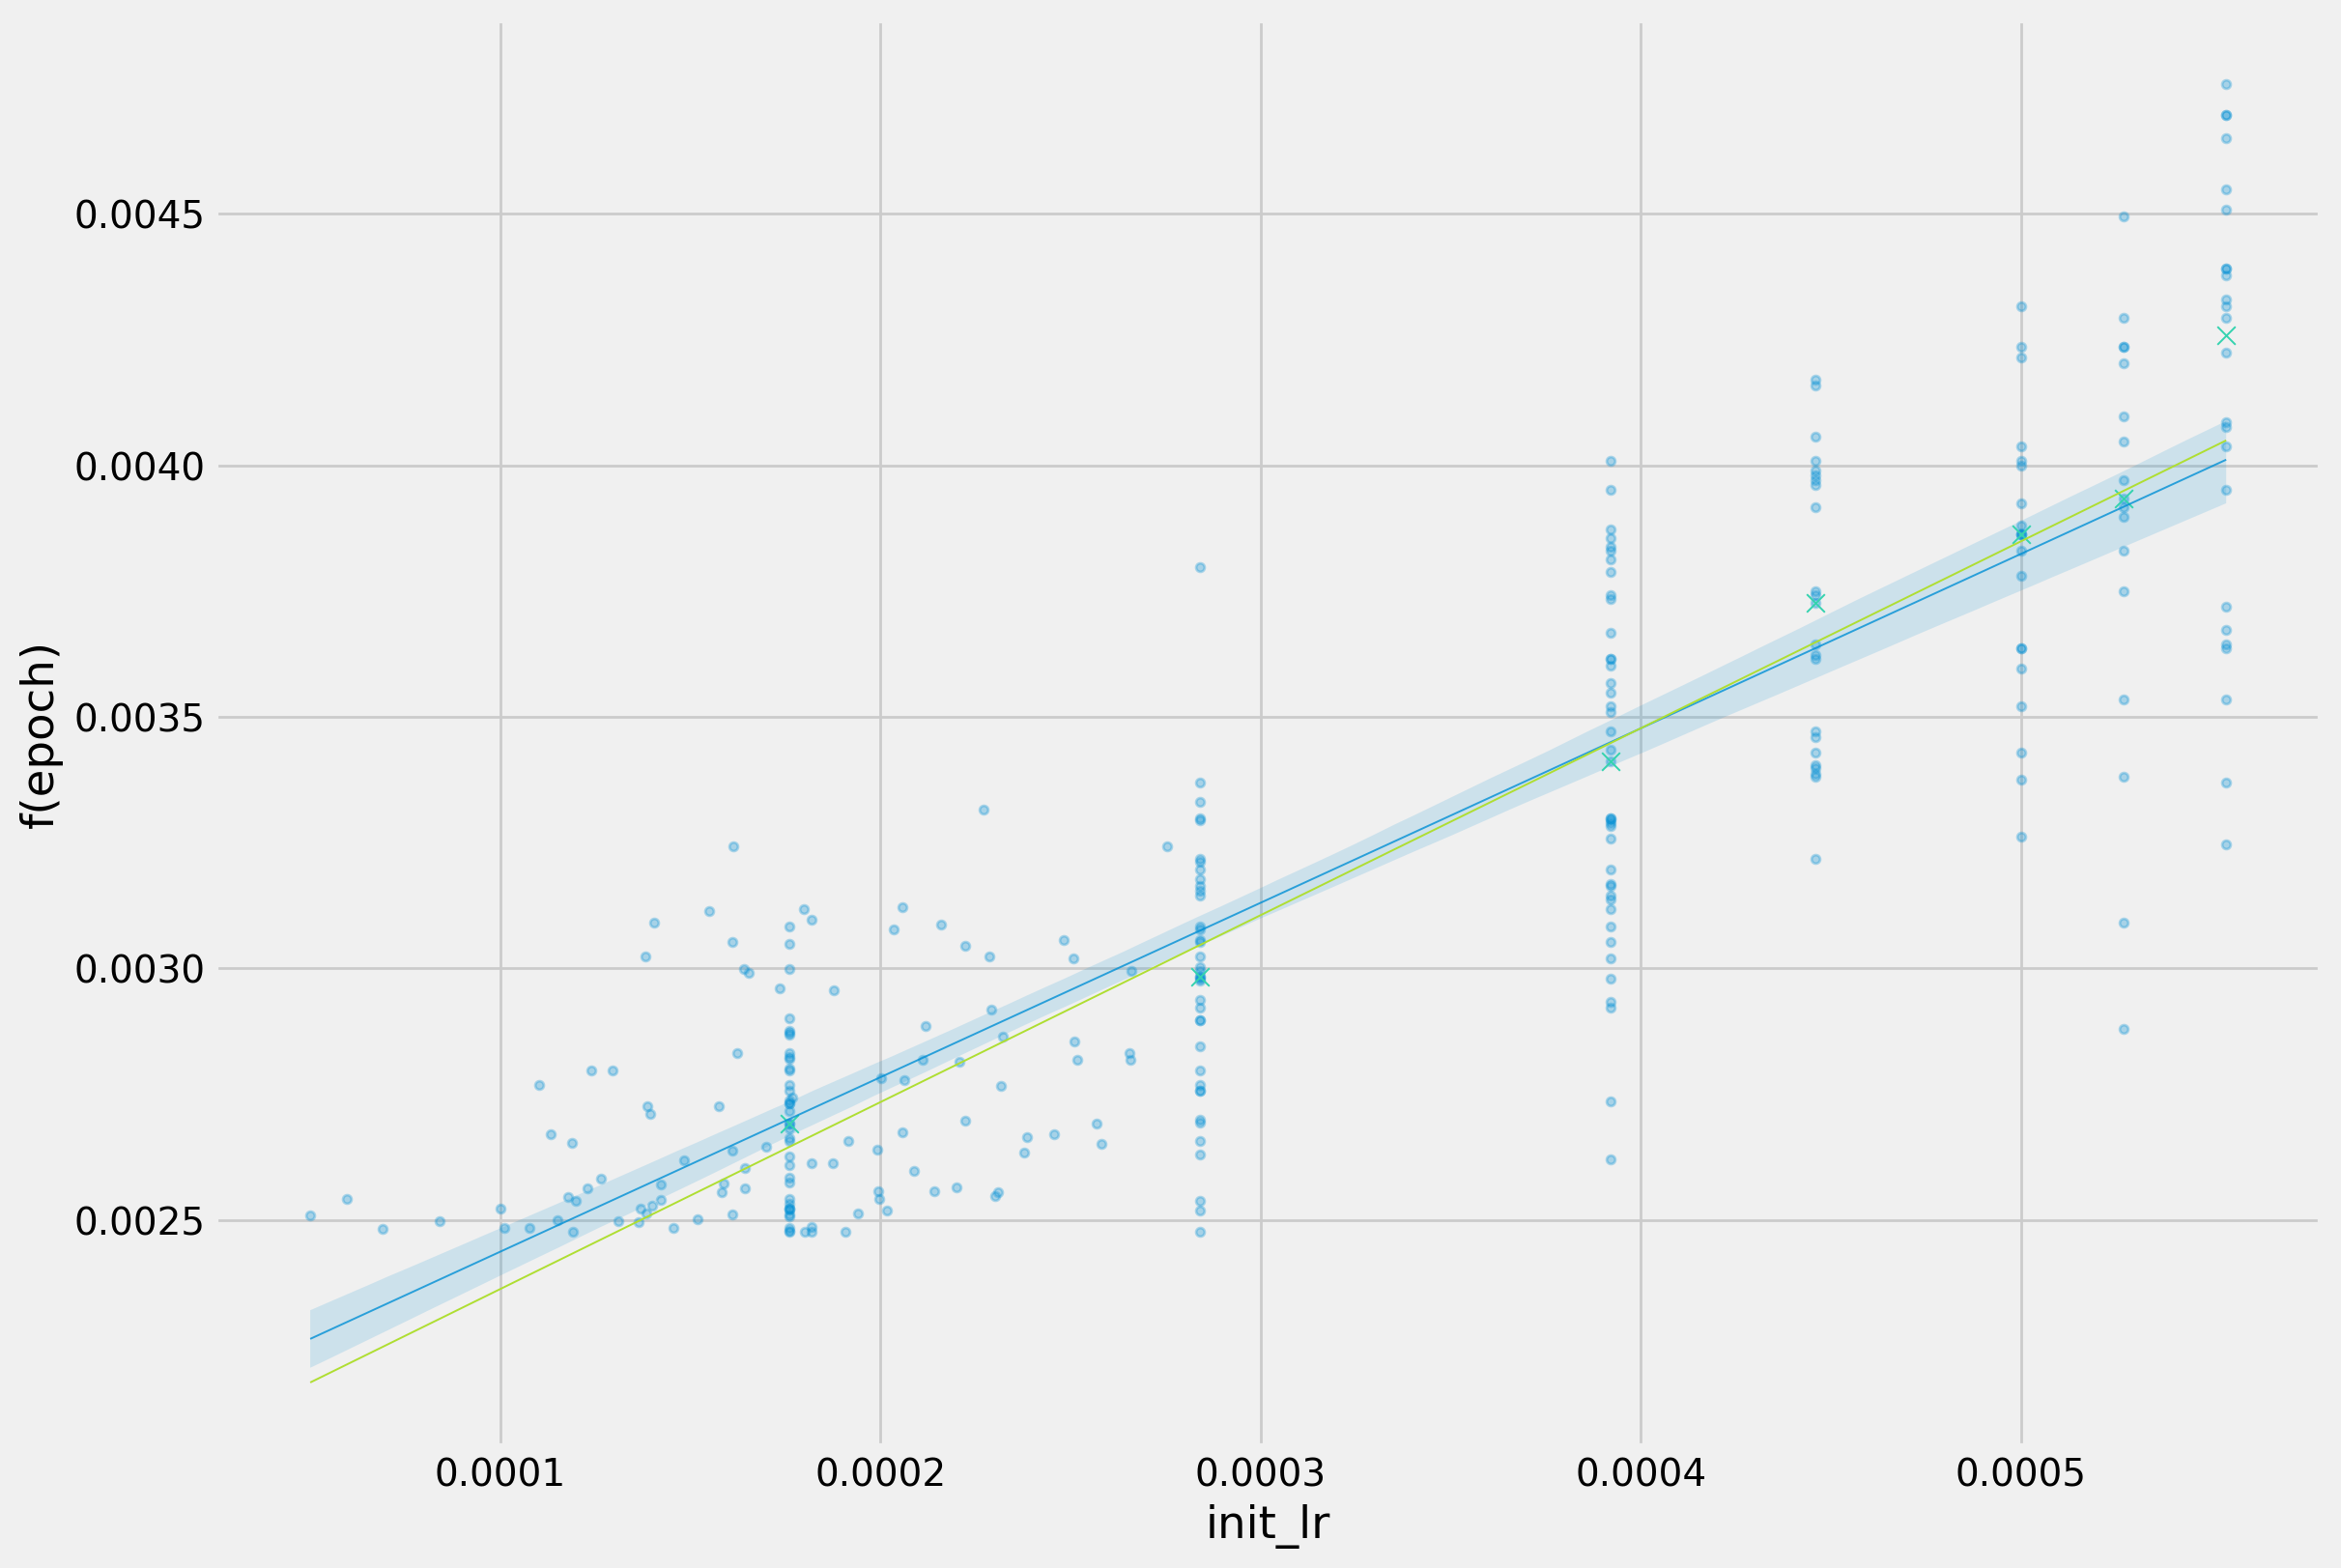

In [ ]:
df_expt_whole = get_expt_whole_rslt_df(os.path.join(RSLT_DIR,'model_test'),'20480_')
coeff = (len(data_dict['trn']['X'])/20480)*60
df_expt_whole['f(epoch)'] = np.power(coeff * df_expt_whole['epoch'],-0.5)

fig,ax = plt.subplots(figsize=(12,8))
#sns.scatterplot(data=df_whole,x='init_lr',y='f(epoch)',alpha=0.3,s=10,ax=ax)
sns.regplot(data=df_expt_whole,x='init_lr',y='f(epoch)',scatter_kws={'alpha':0.3,'s':10},line_kws={'alpha':0.8,'lw':0.7},ax=ax);

x_epochr = np.linspace(df_expt_whole['init_lr'].min(),df_expt_whole['init_lr'].max(),300)
ax.plot(x_epochr,(x_epochr*a_mod+b_mod),color='#afde32',lw=0.7)
ax.scatter(df_mode.lr.to_numpy(),np.power(df_mode[0].to_numpy()*coeff,-0.5),lw=0.7,marker='x',s=45,color='#34d3af')

In [ ]:
indx = epoch_r_mod(x_epochr)<520
lr_lwbnd = min(x_epochr[indx])

cond = df_expt_whole['init_lr'] >= lr_lwbnd
df_expt_bnded = df_expt_whole[cond]

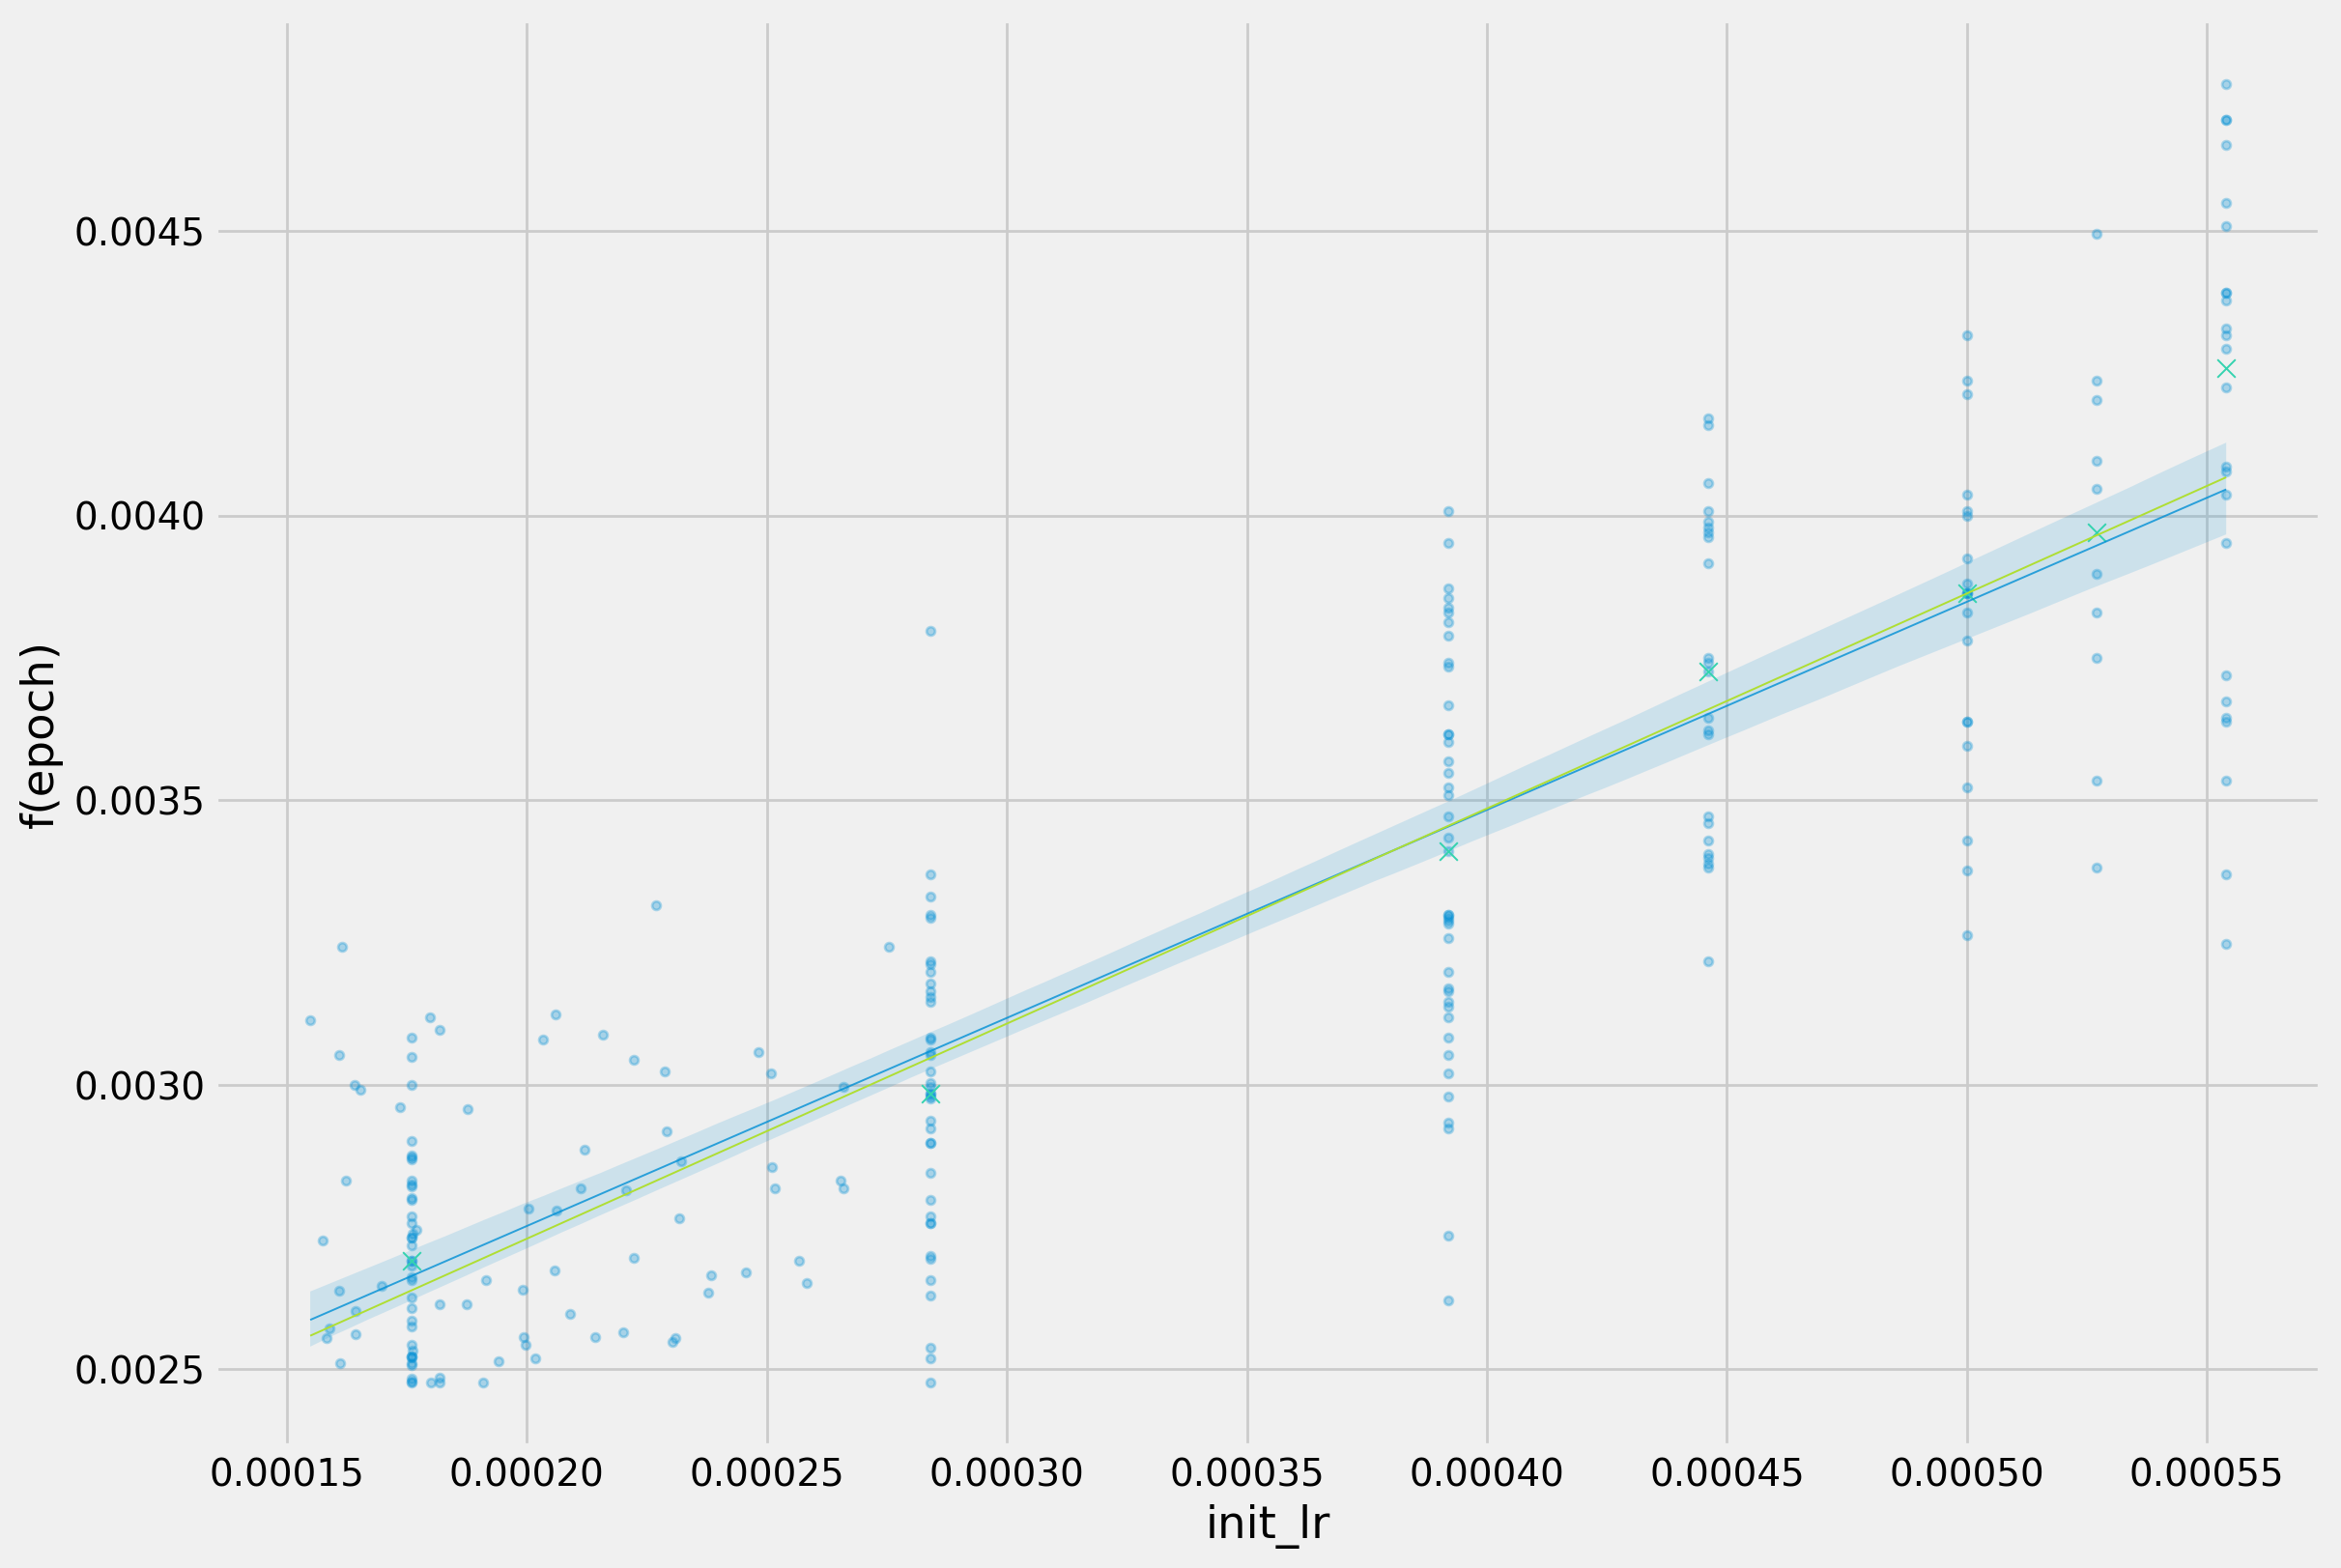

In [ ]:
fig,ax = plt.subplots(figsize=(12,8))
#sns.scatterplot(data=df_whole,x='init_lr',y='f(epoch)',alpha=0.3,s=10,ax=ax)
sns.regplot(data=df_expt_bnded,x='init_lr',y='f(epoch)',scatter_kws={'alpha':0.3,'s':10},line_kws={'alpha':0.8,'lw':0.7},ax=ax);

x_epochr = np.linspace(df_expt_bnded['init_lr'].min(),df_expt_bnded['init_lr'].max(),300)
ax.plot(x_epochr,(x_epochr*a_mod+b_mod),color='#afde32',lw=0.7)
ax.scatter(df_mode.lr.to_numpy(),np.power(df_mode[0].to_numpy()*coeff,-0.5),lw=0.7,marker='x',s=45,color='#34d3af')

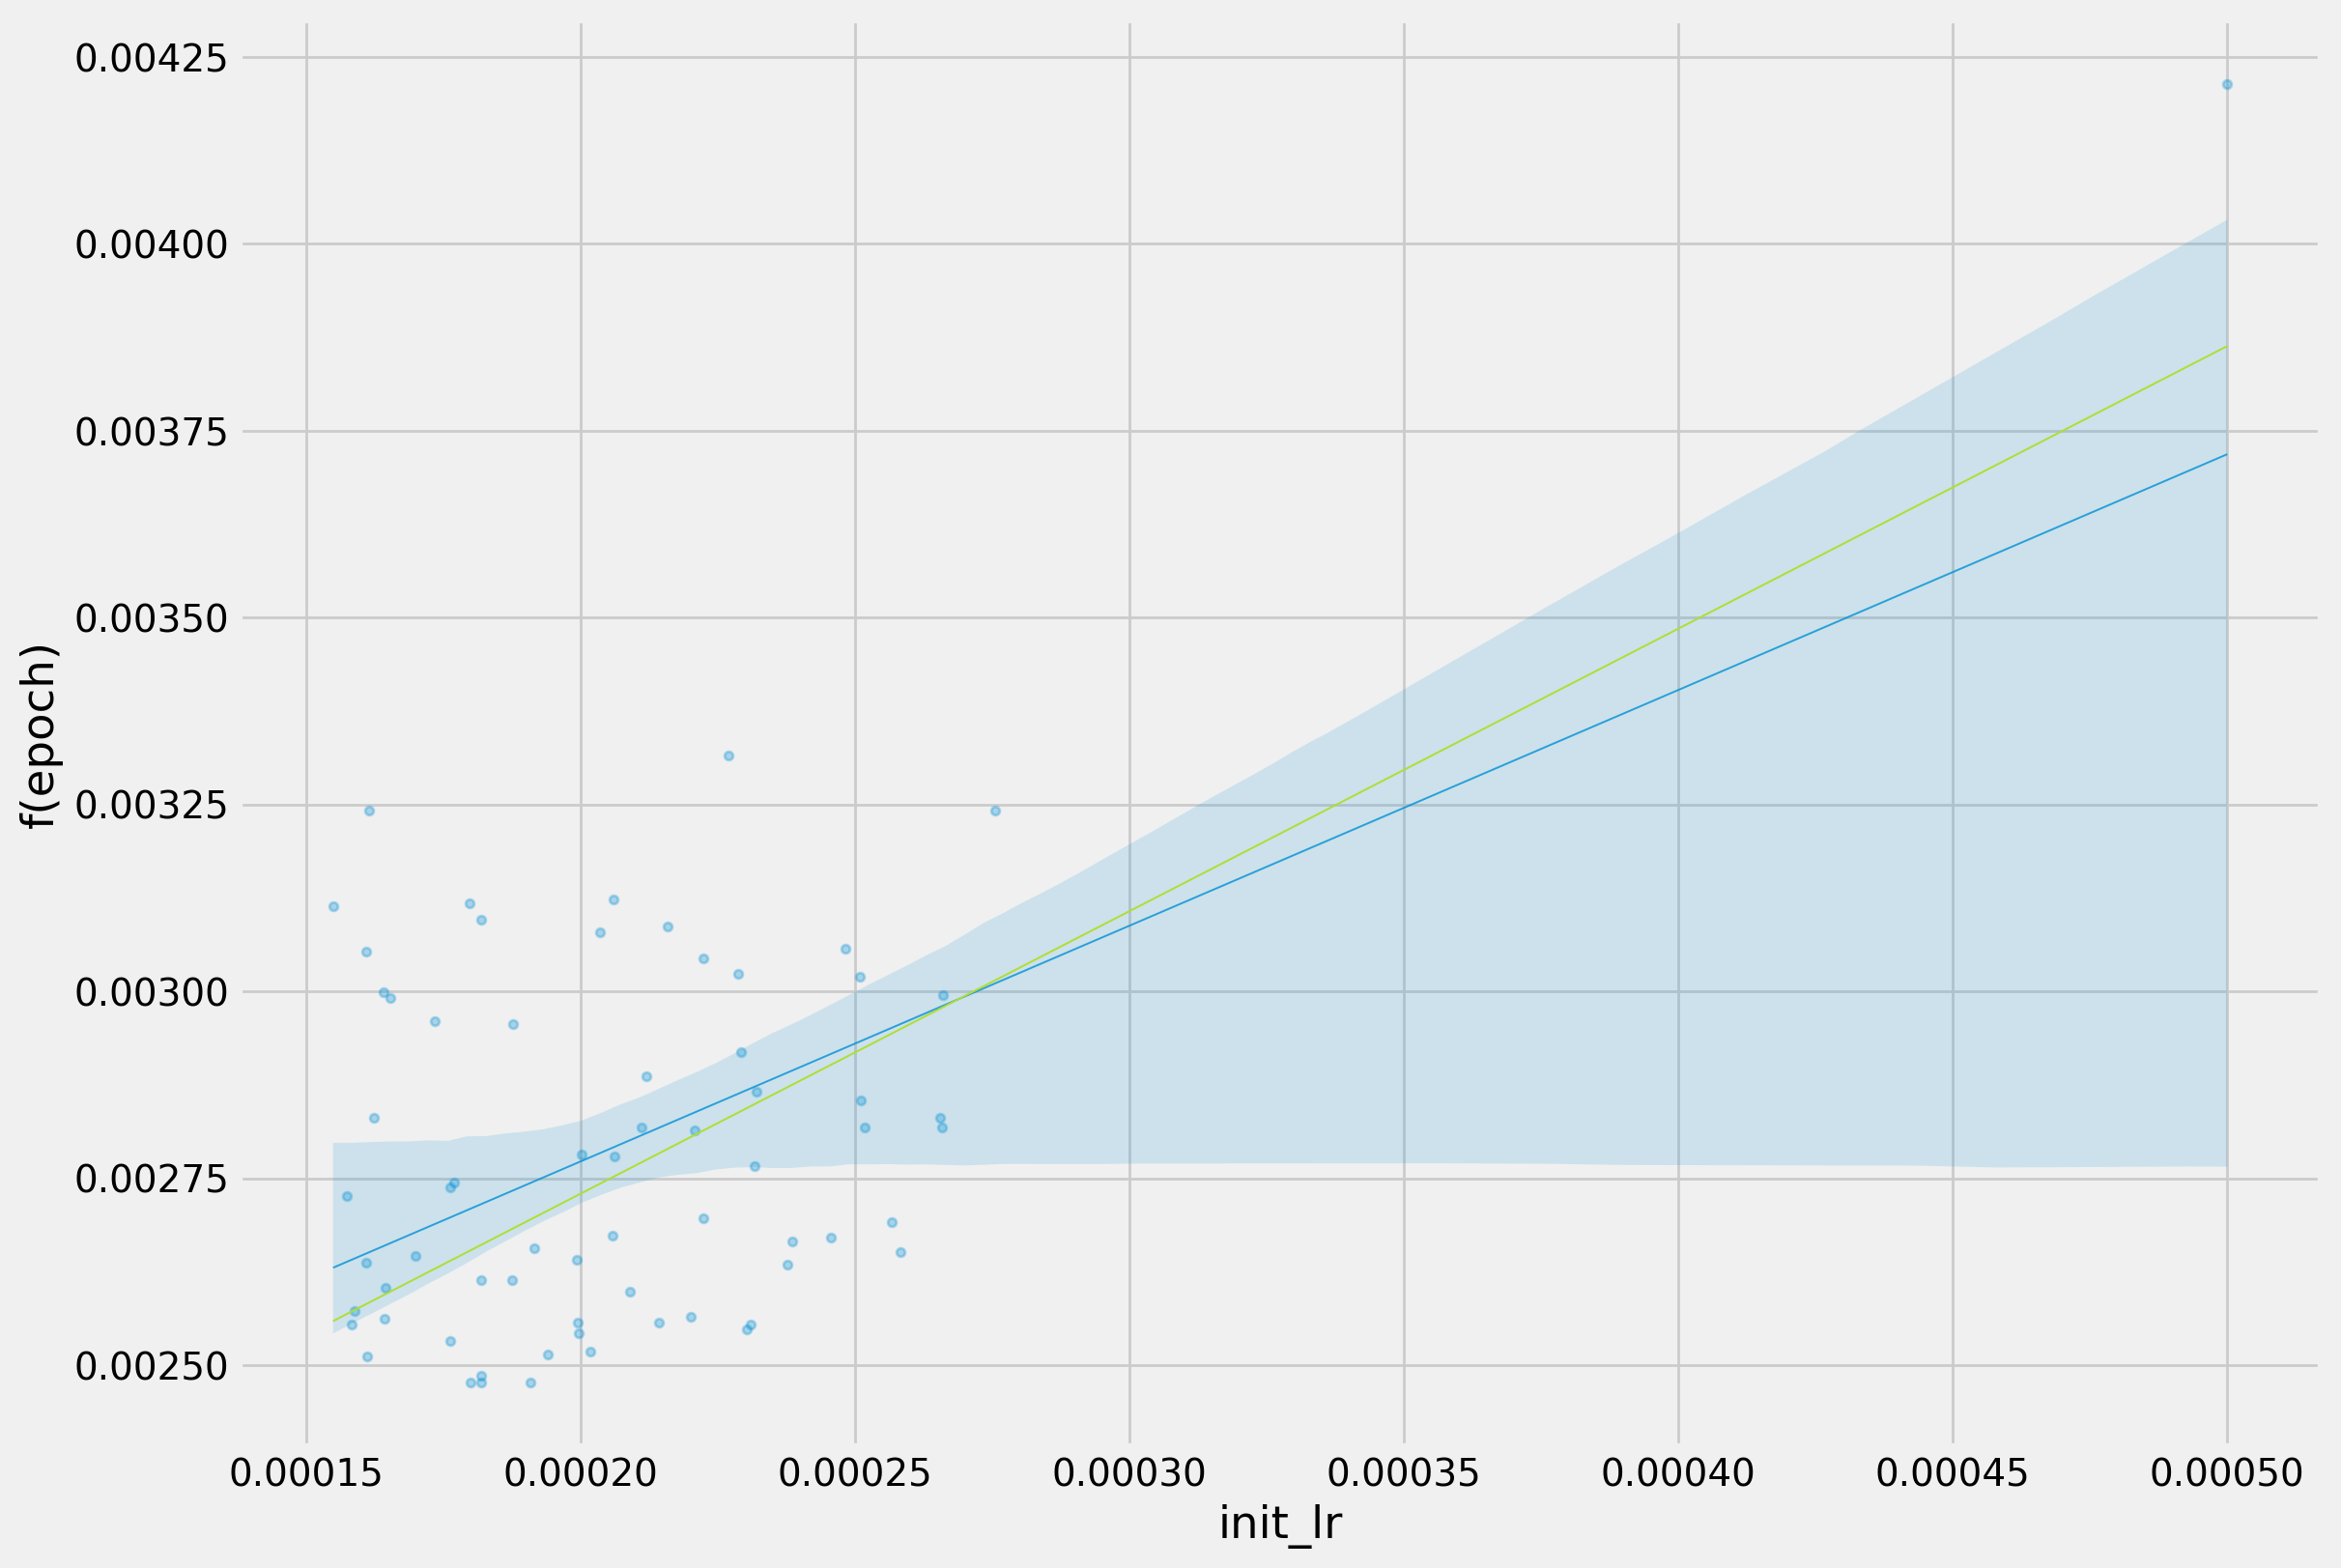

In [ ]:
df_expt1 = get_expt_whole_rslt_df(os.path.join(RSLT_DIR,'model_test'),'20480_1')
coeff = (len(data_dict['trn']['X'])/20480)*60
df_expt1['f(epoch)'] = np.power(coeff * df_expt1['epoch'],-0.5)

cond = (lr_lwbnd <= df_expt1['init_lr']) #& (df_expt1['init_lr']<5e-4)
df_expt1_bnded = df_expt1[cond]

fig,ax = plt.subplots(figsize=(12,8))
#sns.scatterplot(data=df_whole,x='init_lr',y='f(epoch)',alpha=0.3,s=10,ax=ax)
sns.regplot(data=df_expt1_bnded,x='init_lr',y='f(epoch)',scatter_kws={'alpha':0.3,'s':10},line_kws={'alpha':0.8,'lw':0.7},ax=ax);

x_epochr = np.linspace(df_expt1_bnded['init_lr'].min(),df_expt1['init_lr'].max(),300)
ax.plot(x_epochr,(x_epochr*a_mod+b_mod),color='#afde32',lw=0.7)
#ax.scatter(df_mode.lr.to_numpy(),np.power(df_mode[0].to_numpy()*coeff,-0.5),lw=0.7,marker='x',s=45,color='#34d3af')

0.6845733218545407 65.98275215727004


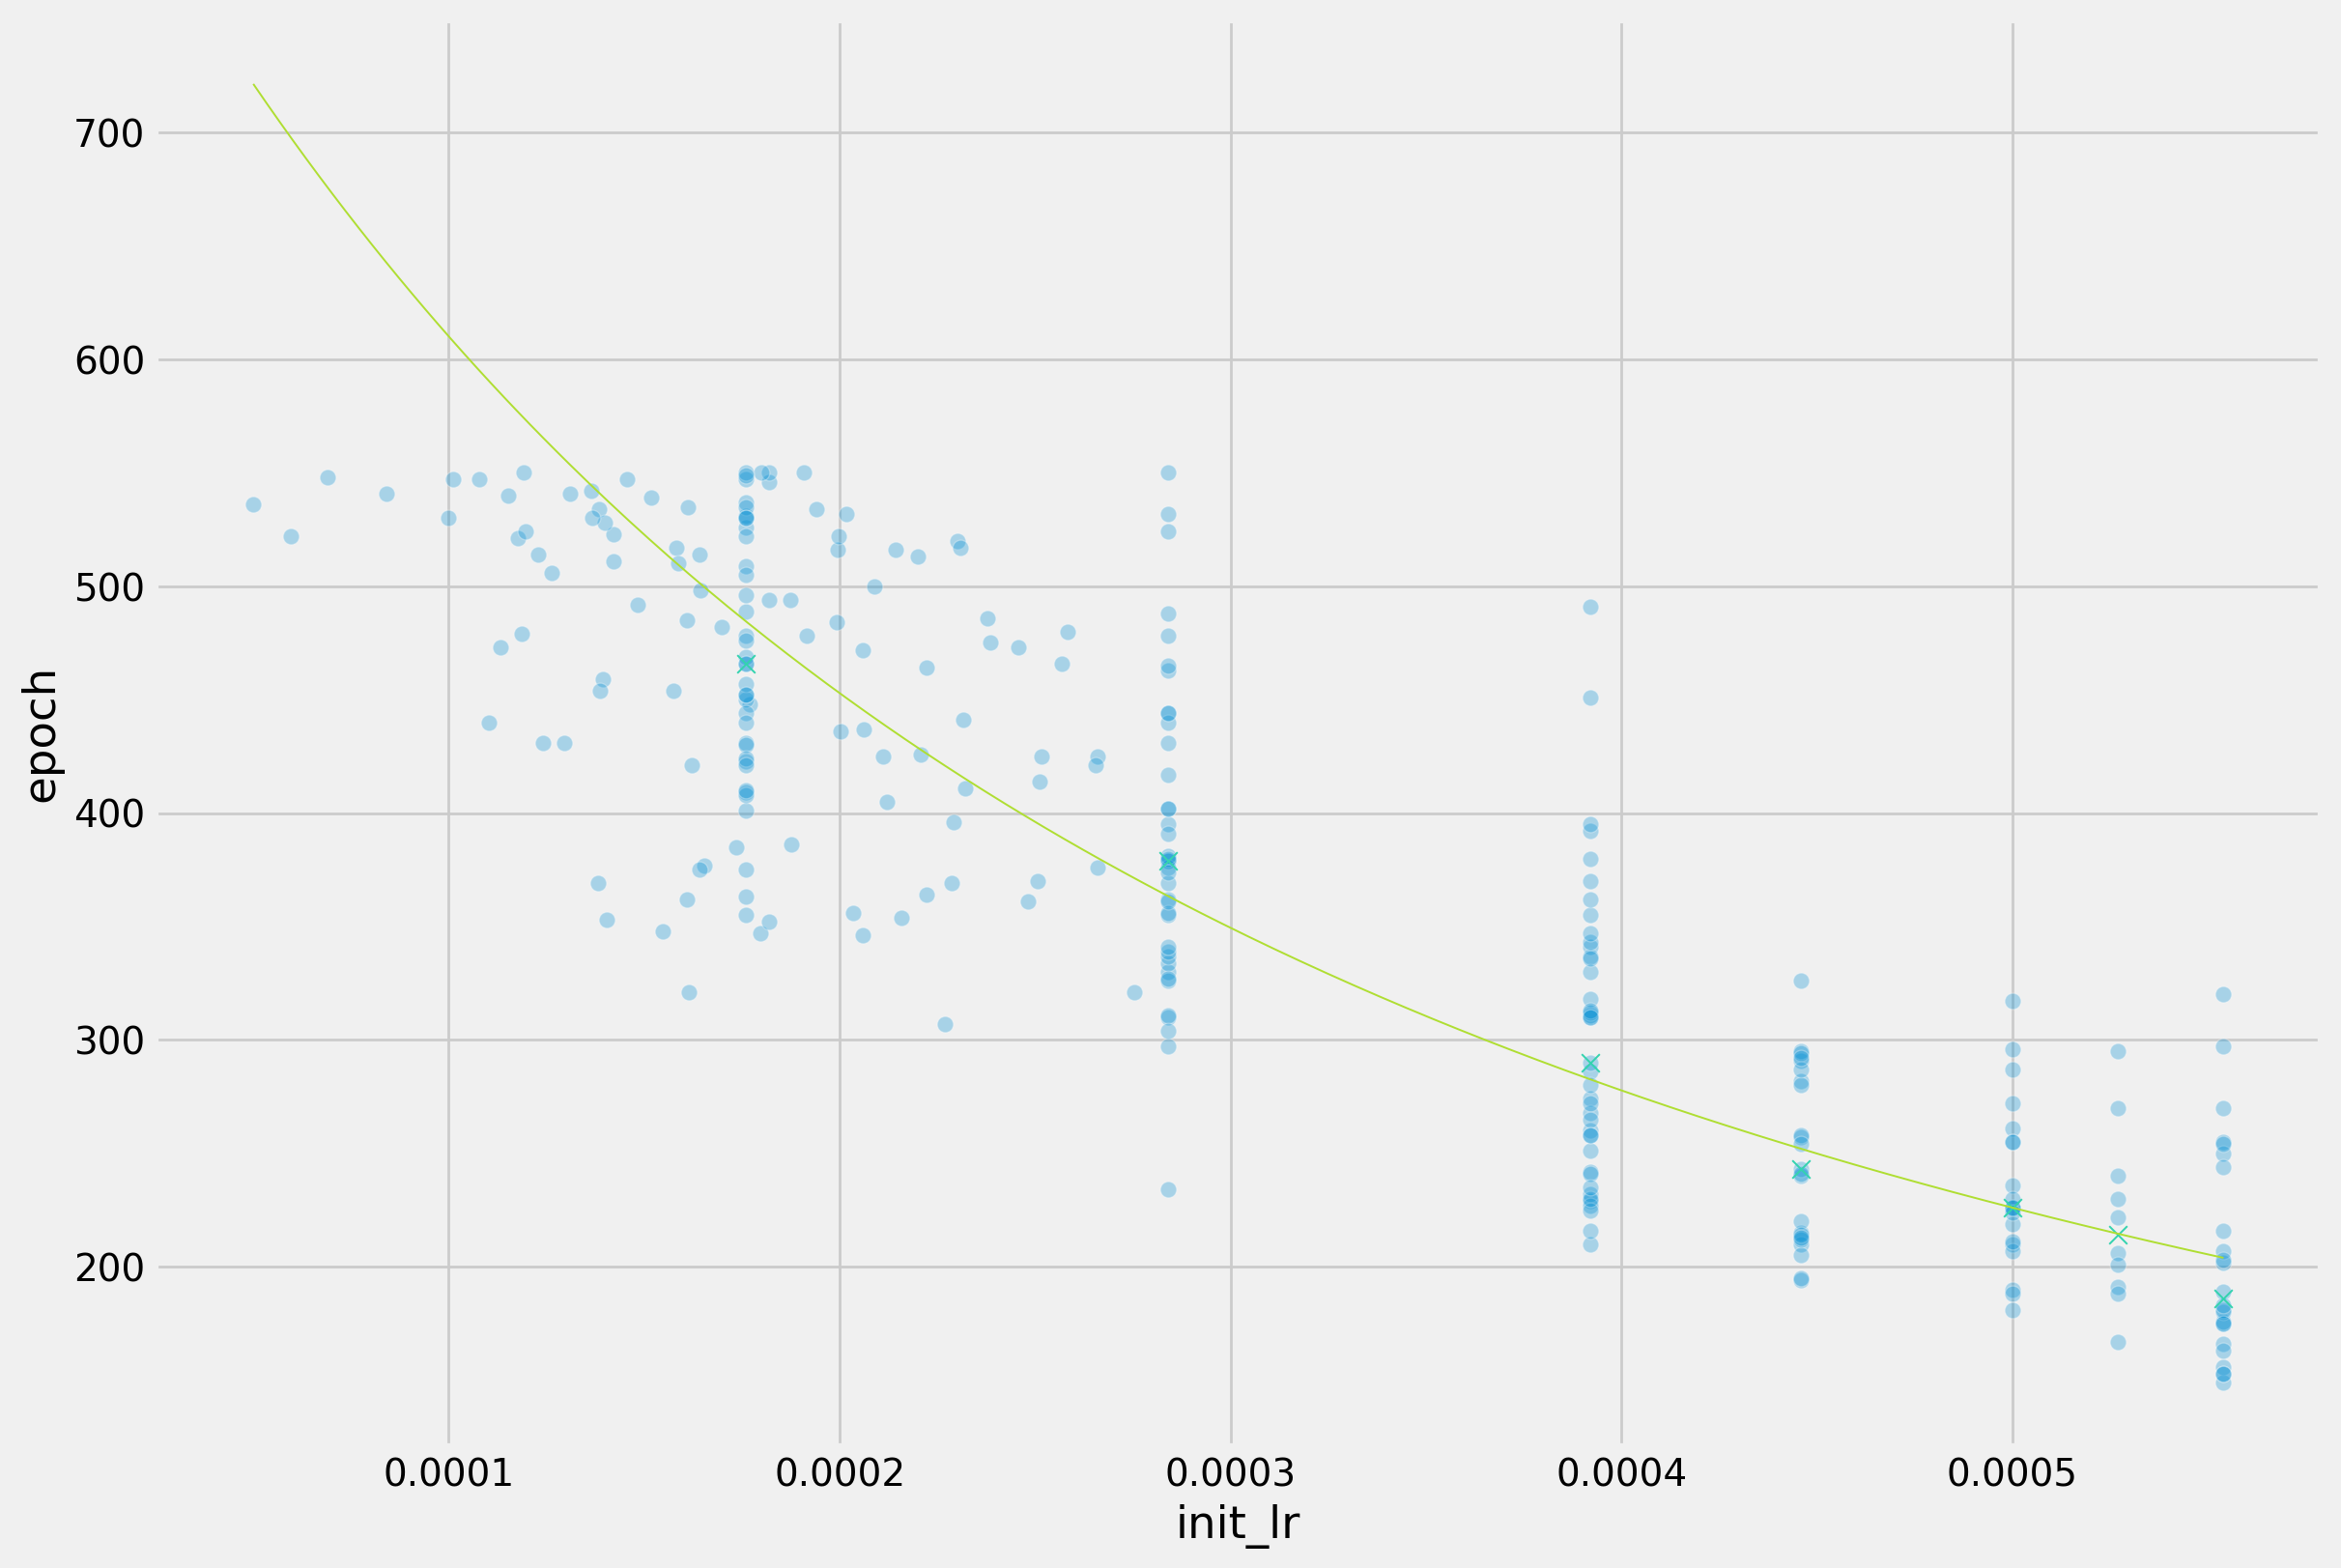

In [ ]:
df_expt_whole['epoch_r_mod'] = epoch_r_mod(df_expt_whole['init_lr'].values)
print(r2_score(df_expt_whole['epoch'],df_expt_whole['epoch_r_mod']), root_mean_squared_error(df_expt_whole['epoch'],df_expt_whole['epoch_r_mod']))

fig,ax = plt.subplots(figsize=(12,8))
sns.scatterplot(data=df_expt_whole,x='init_lr',y='epoch',alpha=0.3)

ind = df_expt_whole['init_lr'].drop_duplicates(keep='first').sort_values().index
x_epochr = np.linspace(df_expt_whole['init_lr'].min(),df_expt_whole['init_lr'].max(),300)
ax.plot(x_epochr,epoch_r_mod(x_epochr),color='#afde32',lw=0.7)
#ax.plot(df_expt_whole.loc[ind,'init_lr'],df_expt_whole.loc[ind,'epoch_r_mod'],color='#afde32',lw=0,marker='o',markersize=5)

ax.scatter(df_mode.lr.to_numpy(),df_mode[0].to_numpy(),lw=0.7,marker='x',s=45,color='#34d3af')